In [1]:
import math
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.io
from pysofaconventions import *
import sofa
from natsort import natsorted
import glob
from torch.utils.data import Dataset
import pandas as pd
#from torch.utils.tensorboard import SummaryWriter

In [2]:
def plot_noise_distribution(noise, predicted_noise):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))  # Create three subplots
    
    # Plot GT Noise
    axes[0].plot(noise.cpu().numpy()[0,0], label='GT Noise L', linewidth=0.5, marker='o', markersize=1)
    axes[0].plot(noise.cpu().numpy()[0,1], label='GT Noise R', linewidth=0.5, marker='o', markersize=1)
    axes[0].grid()
    axes[0].legend()
    
    # Plot Predicted Noise
    axes[1].plot(predicted_noise.cpu().numpy()[0,0], label='Pred Noise L', linewidth=0.5, marker='o', markersize=1)
    axes[1].plot(predicted_noise.cpu().numpy()[0,1], label='Pred Noise R', linewidth=0.5, marker='o', markersize=1)
    axes[1].grid()
    axes[1].legend()
    
    # Plot Noise Distribution
    axes[2].hist(noise.cpu().numpy().flatten(), density=True, alpha=0.8, label="Ground Truth Noise")
    axes[2].hist(predicted_noise.cpu().numpy().flatten(), density=True, alpha=0.8, label="Predicted Noise")
    axes[2].legend()
    
    plt.show()

In [3]:
class DiffusionModel:
    def __init__(self, start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps
        
        """
        if 
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod = [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]
            
        
        """ 
        self.betas = torch.linspace(start_schedule, end_schedule, timesteps)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward(self, x_0, t, device="cpu"):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.alphas_cumprod.sqrt(), t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x_0.shape)
            
        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
        
        return mean + variance, noise.to(device)
    
    @torch.no_grad()
    def backward(self, x, t, model, **kwargs):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t, **kwargs) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance

    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        out = values.gather(-1, t.long().cpu())
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [4]:
diffusion_model = DiffusionModel()

len data: 42240
measurement point:  0
Subject idx 0
Subject id:  1  Measurements:
Head Measurements: tensor([-0.4887, -0.3549, -0.4109, -0.7810, -0.7803, -0.5474, -0.6165, -0.5484,
        -0.1753,  0.2177,  2.6909,  0.3289,  1.4107], dtype=torch.float64)
Ear Measurements: tensor([ 1.7000,  0.8200,  1.7900,  2.1800,  5.9900,  3.2400,  0.7200,  1.1600,
         1.0900,  0.2300, 16.4941, 27.9157,  1.5800,  1.1100,  1.7700,  2.2700,
         6.0100,  3.1800,  0.7200,  1.1000,  1.1000,  0.2300, 12.2154, 25.2729],
       dtype=torch.float64)


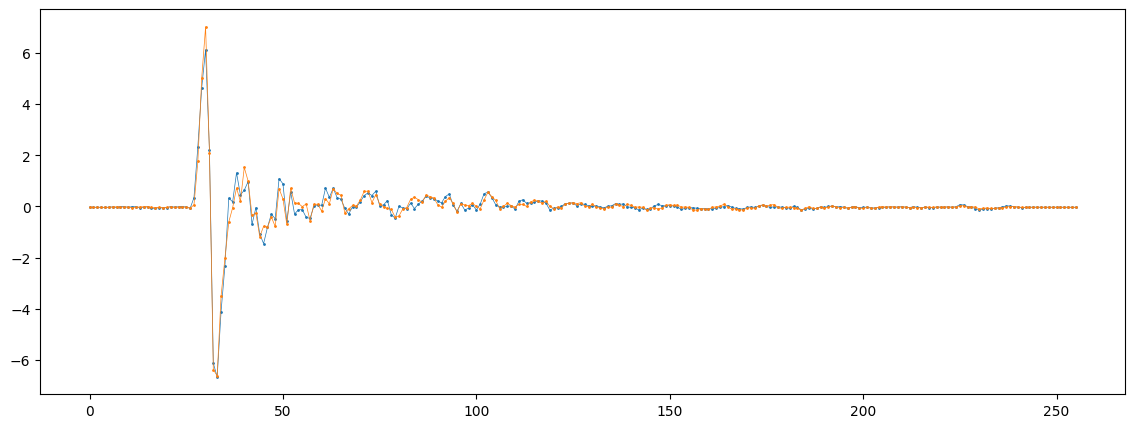

In [5]:
import os
import torch
import torchaudio
import pandas as pd
from torch.utils.data import Dataset

class HUTUBSDataset(Dataset):
    def __init__(self, hrtf_directory, anthro_csv_path):
        self.hrtf_directory = hrtf_directory
        self.anthro_csv_path = anthro_csv_path
        self.load_data()

    def load_data(self):
        subject = []
        all_hrtf = []
        hrtf_points = []
        for n in range(1, 97):
            file_path = os.path.join(self.hrtf_directory, f'pp{n}_HRIRs_measured.sofa')
            subject.append(SOFAFile(file_path, 'r'))
        #print(len(subject))
        for n in range(96):
            hrtf_data = subject[n].getDataIR()
            for point in range(440):
                hrtf_point = hrtf_data[point, :, :]
                hrtf_points.append({'hrtf': hrtf_point, 'point': point, 'subj':n})

        self.all_hrtf_data = torch.from_numpy(np.array([item['hrtf'] for item in hrtf_points]))
        self.all_hrtf_points = torch.from_numpy(np.array([item['point'] for item in hrtf_points]))
        #print(self.all_hrtf_points)
        # Normalize HRTF data
        self.global_mean = torch.mean(self.all_hrtf_data)
        self.global_std = torch.std(self.all_hrtf_data)

        af_csv = pd.read_csv(self.anthro_csv_path,header=0)
        #print("af_csv",af_csv.shape)
        self.subject_ids = torch.from_numpy(af_csv.iloc[:, 0].values)
        #print("subjects shape: ",self.subject_ids.shape)
        self.head_measurements = torch.from_numpy(af_csv.iloc[:, 1:14].values)
        #print("NaN in Head Measurements:", torch.isnan(self.head_measurements).any())
        self.head_measurements[torch.isnan(self.head_measurements)] = 0
        #print("NaN in Head Measurements:", torch.isnan(self.head_measurements).any())
        self.global_head_mean = torch.mean(self.head_measurements)
        self.global_head_std = torch.std(self.head_measurements)
        #print("head mean", self.global_head_mean)
        #print("head std", self.global_head_std)
        self.ear_measurements = torch.from_numpy(af_csv.iloc[:, 14:].values)
        #print("ear shape: ",self.ear_measurements.shape)

        self.normalized_dataset = [
            {
                'hrtf': (torch.from_numpy(item['hrtf'].data) - self.global_mean) / self.global_std,
                'subject_id': item['subj' ]+1,
                'measurement_point': item['point'],
                'head_measurements': (self.head_measurements[self.subject_ids[item['subj'] ]-1]- self.global_head_mean)/self.global_head_std,
                'ear_measurements': self.ear_measurements[self.subject_ids[item['subj'] ]-1],
            }
            for item in hrtf_points
            
        ]
        #print("What:", self.subject_ids[hrtf_points[95]['point']])
        #print("meas points: ", hrtf_points['point'])

    def __len__(self):
        return len(self.normalized_dataset)

    def __getitem__(self, idx):
        return self.normalized_dataset[idx]

hutubs_dataset = HUTUBSDataset(
    hrtf_directory='/nas/home/jalbarracin/datasets/HUTUBS/HRIRs',
    anthro_csv_path='/nas/home/jalbarracin/datasets/HUTUBS/AntrhopometricMeasures.csv'
)


# Getting sample from dataset
print("len data:", len(hutubs_dataset))
subject_idx = 0
measurement_point = 0

data_point = hutubs_dataset[subject_idx * 440 + measurement_point]


# Print measurements
print(f"measurement point: ", data_point["measurement_point"])
print(f"Subject idx {subject_idx}")
print(f"Subject id: ", data_point["subject_id"], " Measurements:")
print("Head Measurements:", data_point['head_measurements'])
print("Ear Measurements:", data_point['ear_measurements'])

plt.figure(figsize=(14, 5))
plt.plot(data_point['hrtf'][0],label='L', linewidth=0.5, marker='o', markersize=1)
plt.plot(data_point['hrtf'][1],label='R', linewidth=0.5, marker='o', markersize=1)

In [6]:
def collate_fn(batch):
  
    audio_batch = [item['hrtf'] for item in batch]
    measurement_point_batch = [item['measurement_point'] for item in batch]
    subject_id_batch = [item['subject_id'] for item in batch]
    head_measurements_batch = [item['head_measurements']for item in batch]
    ear_measurements_batch = [item['ear_measurements'] for item in batch]
  
    
    return {'hrtf': torch.stack(audio_batch), 
            'measurement_point': torch.tensor(measurement_point_batch),
            'subject_id': torch.LongTensor(subject_id_batch),
            'head_measurements': torch.stack(head_measurements_batch),
            'ear_measurements': torch.stack(ear_measurements_batch),
            }

In [7]:
# Define the percentage of data to use for training
train_percentage = 0.8  # 80% for training, 20% for testing

# Calculate the split index
split_index = int(len(hutubs_dataset) * train_percentage)

# Split the dataset into training and testing sets
train_dataset = HUTUBSDataset(
    hrtf_directory='/nas/home/jalbarracin/datasets/HUTUBS/HRIRs',
    anthro_csv_path='/nas/home/jalbarracin/datasets/HUTUBS/AntrhopometricMeasures.csv'
)[:split_index]

test_dataset = HUTUBSDataset(
    hrtf_directory='/nas/home/jalbarracin/datasets/HUTUBS/HRIRs',
    anthro_csv_path='/nas/home/jalbarracin/datasets/HUTUBS/AntrhopometricMeasures.csv'
)[split_index:]

In [20]:
BATCH_SIZE = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True,collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, drop_last=True,collate_fn=collate_fn)

In [17]:
batch = next(iter(train_loader))
audio_test = batch['hrtf']
measurement_point_test = batch['measurement_point']
idsub = batch['subject_id']

# Print information about the first sample in the batch
print(f"Subject ID: {idsub[0].item()}")
print(f"Measurement Point: {measurement_point_test[0].item()}")
print(f"HRTF Shape: {audio_test.shape}")


Subject ID: 68
Measurement Point: 89
HRTF Shape: torch.Size([128, 2, 256])


In [9]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
       
        return embeddings

In [10]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, channels_in, channels_out, time_embedding_dims, labels, head_measurement_dims=13, num_categories=96, num_filters=3, downsample=True):
        super().__init__()

        self.time_embedding_dims = time_embedding_dims
        self.time_embedding = nn.EmbeddingBag(num_categories, time_embedding_dims, sparse=True)
        self.labels = labels

        # Embedding for head measurements
        self.head_measurement_embedding = nn.EmbeddingBag(num_categories, head_measurement_dims, sparse=True)

        if labels:
            self.label_mlp = nn.Linear(1, channels_out)

        self.downsample = downsample

        if downsample:
            self.conv1 = nn.Conv1d(channels_in, channels_out, num_filters, padding=1)
            self.final = nn.Conv1d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv1d(2 * channels_in, channels_out, num_filters, padding=1)
            self.final = nn.ConvTranspose1d(channels_out, channels_out, 4, 2, 1)

        self.bnorm1 = nn.BatchNorm1d(channels_out)
        self.bnorm2 = nn.BatchNorm1d(channels_out)

        self.conv2 = nn.Conv1d(channels_out, channels_out, 3, padding=1)
        self.time_mlp = nn.Linear(time_embedding_dims, channels_out)
        self.head_measurement_mlp = nn.Linear(head_measurement_dims, channels_out)
        self.relu = nn.ReLU()

    def forward(self, x, t, **kwargs):
        o = self.bnorm1(self.relu(self.conv1(x)))

        # Embed time
        o_time = self.relu(self.time_mlp(self.time_embedding(t)))
        o = o + o_time.unsqueeze(2)

        if self.labels:
            # Embed head measurements
            head_measurements_offsets = kwargs.get('head_measurements_offsets')
            head_embedding = self.head_measurement_embedding(t, head_measurements_offsets)
            o_head = self.relu(self.head_measurement_mlp(head_embedding))
            o = o + o_head.unsqueeze(2)

            label = kwargs.get('labels')
            o_label = self.relu(self.label_mlp(label))
            o = o + o_label.unsqueeze(2)

        o = self.bnorm2(self.relu(self.conv2(o)))

        return self.final(o)

class UNet(nn.Module):
    def __init__(self, audio_channels=2, time_embedding_dims=128, head_measurement_dims=13, num_categories=96, labels=False, sequence_channels=(64, 128, 256, 512, 1024)):
        super().__init__()
        self.time_embedding_dims = time_embedding_dims
        sequence_channels_rev = reversed(sequence_channels)
        
        # Embedding layer for subject ids
        self.subject_embedding = nn.Embedding(num_embeddings=num_categories, embedding_dim=time_embedding_dims)
        
        self.downsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels, head_measurement_dims, num_categories) for channels_in, channels_out in zip(sequence_channels, sequence_channels[1:])])
        self.upsampling = nn.ModuleList([Block(channels_in, channels_out, time_embedding_dims, labels, head_measurement_dims, num_categories, downsample=False) for channels_in, channels_out in zip(sequence_channels[::-1], sequence_channels[::-1][1:])])
        self.conv1 = nn.Conv1d(audio_channels, sequence_channels[0], 3, padding=1)  # Change to 1D convolution
        self.conv2 = nn.Conv1d(sequence_channels[0], audio_channels, 1)

    def forward(self, x, t, **kwargs):
        # Embed subject IDs
        subject_embedded = self.subject_embedding(t)
        
        residuals = []
        o = self.conv1(x)
        for ds in self.downsampling:
            o = ds(o, t, head_measurements_offsets=subject_embedded, **kwargs)
            residuals.append(o)
        for us, res in zip(self.upsampling, reversed(residuals)):
            o = us(torch.cat((o, res), dim=1), t, head_measurements_offsets=subject_embedded, **kwargs)
            
        return self.conv2(o)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
NO_EPOCHS = 100 
PRINT_FREQUENCY = 10
LR = 0.001
VERBOSE = True
unet = UNet(labels=True).float()
unet.to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=LR)

In [25]:
for epoch in range(NO_EPOCHS):
    mean_epoch_loss = []
    mean_epoch_loss_val = []
    
    for data in train_loader:
        batch = data['hrtf'].to(device)
        subjects = data['subject_id'].to(device)
        meas_label = data['measurement_point'].to(device).float()
        head_measurements_offsets = data['head_measurements'].to(device).long()
        #af_encoded = head_enc(af_label)
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).long().to(device)
        '''
        batch = batch.to(device)
        print("batch: ", batch.shape)
        print("meas: ", meas_label.shape)
        print("af: ", af_label.shape)
        print("t: ", t.shape)
        '''
        batch_noisy, noise = diffusion_model.forward(batch, t, device) 
        #batch_noisy = batch_noisy.unsqueeze(1).expand(-1, 2, -1)
        batch_noisy = batch_noisy.float()
        #print("batch_noisy:", batch_noisy.shape)
        #print("t",t.shape)
        predicted_noise = unet(batch_noisy, t,labels=meas_label.reshape(-1,1), head_measurements_offsets=head_measurements_offsets)
        
        optimizer.zero_grad()
        loss = torch.nn.functional.l1_loss(noise, predicted_noise) 
        mean_epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    for data in test_loader:
        batch = data['hrtf'].to(device)
        label = data['measurement_point'].to(device).float()
        
        t = torch.randint(0, diffusion_model.timesteps, (BATCH_SIZE,)).float().to(device)
        batch = batch.to(device)
        batch = batch.float()

        batch_noisy, noise = diffusion_model.forward(batch, t, device)
        batch_noisy = batch_noisy.float()
        #print("batch noisy: ",batch_noisy.shape)
        predicted_noise = unet(batch_noisy, t, labels=label.reshape(-1, 1))
        
        loss = torch.nn.functional.l1_loss(noise, predicted_noise) 
        mean_epoch_loss_val.append(loss.item())

    if epoch % PRINT_FREQUENCY == 0:
        print('---')
        print(f"Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        #plot_noise_distribution(noise, predicted_noise)
        if VERBOSE:
            with torch.no_grad():
                plot_noise_distribution(noise, predicted_noise)
                
        torch.save(unet.state_dict(), f"epoch: {epoch}")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [56]:
unet = UNet(labels=True)
unet.load_state_dict(torch.load(("epoch: 350")))

<All keys matched successfully>

In [6]:
classes = ('0', '5', '10', '15',
           '20', '25', '30', '35')

In [57]:
NUM_CLASSES = 36
NUM_DISPLAY_IMAGES = 5

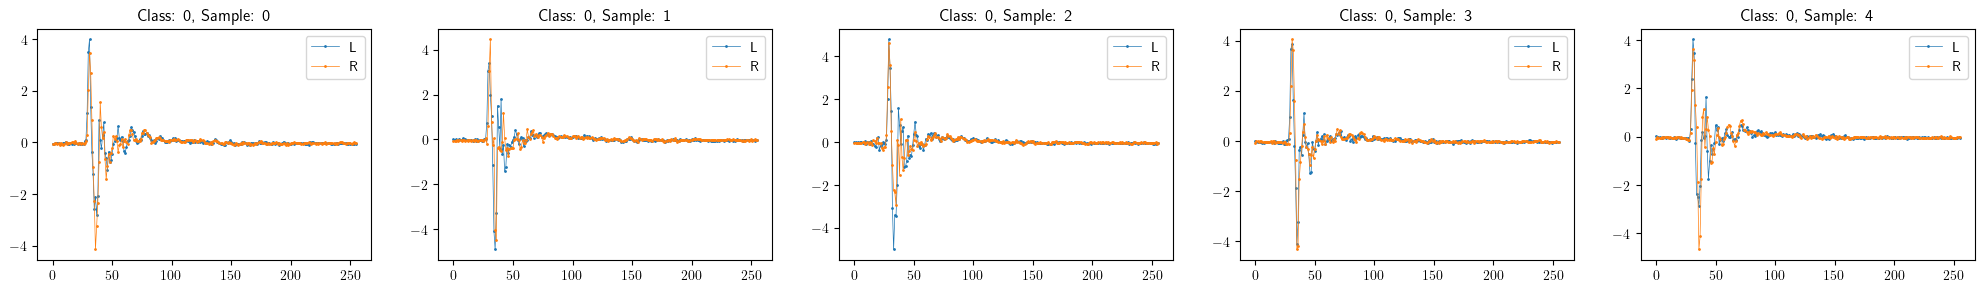

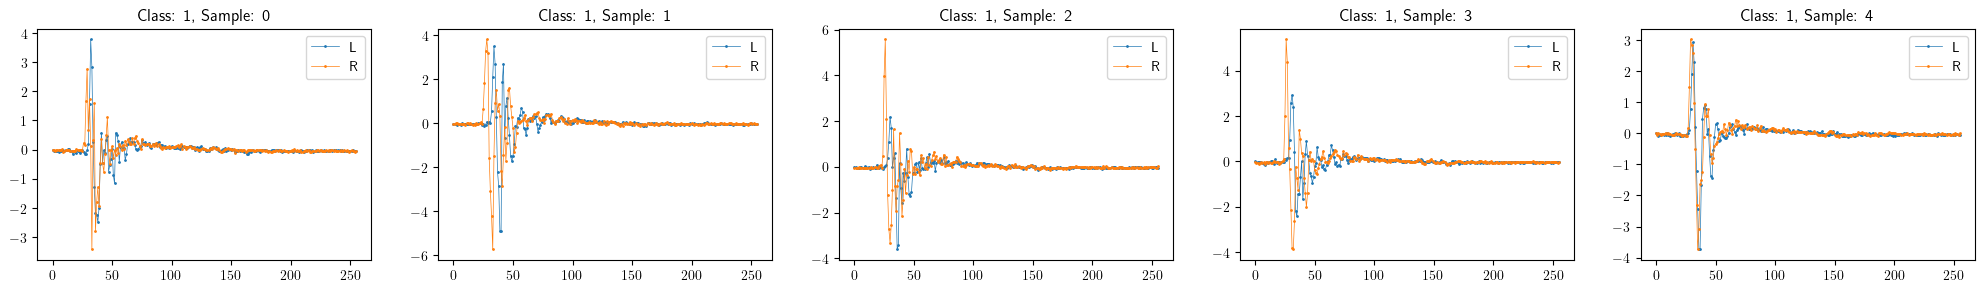

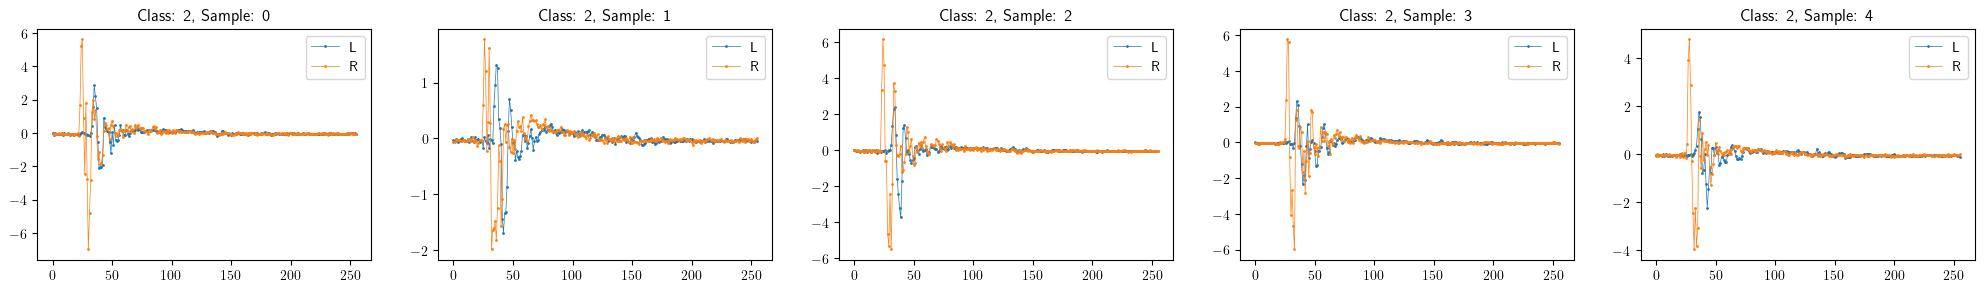

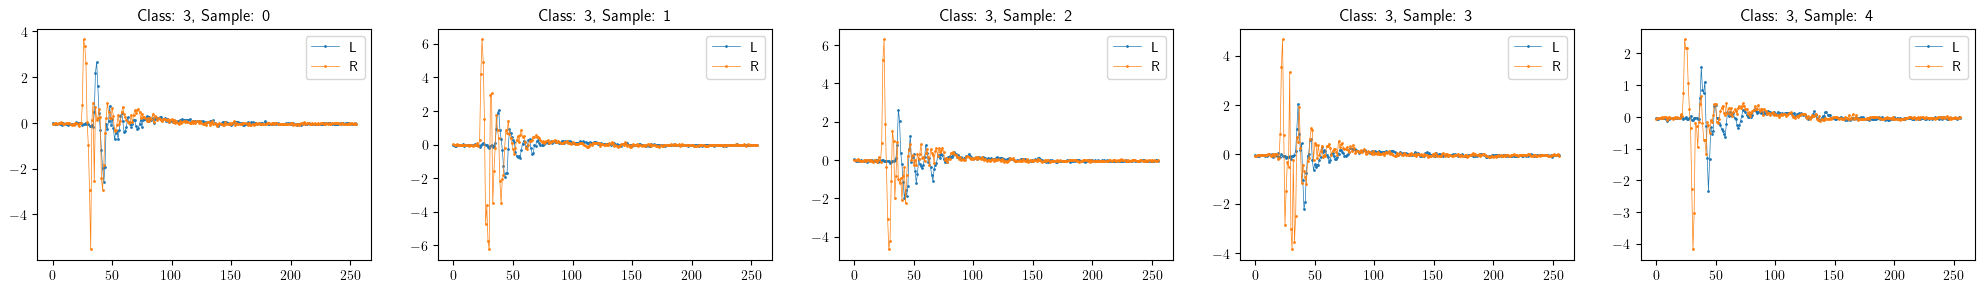

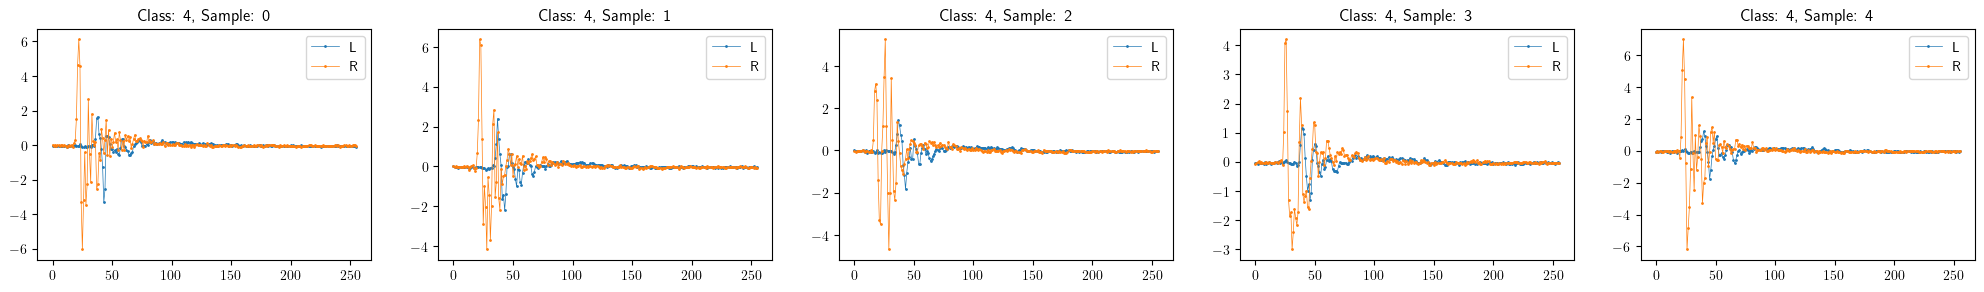

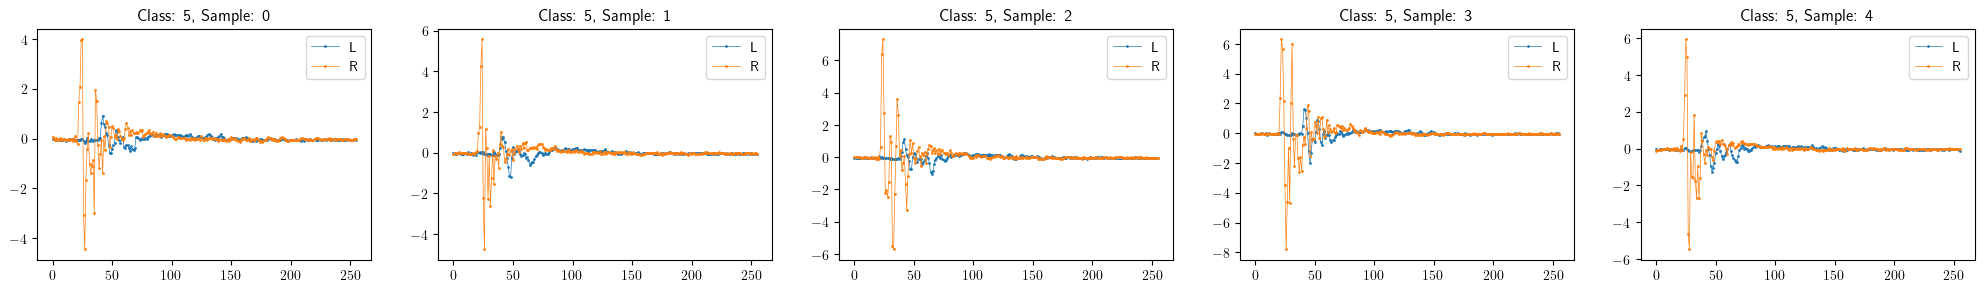

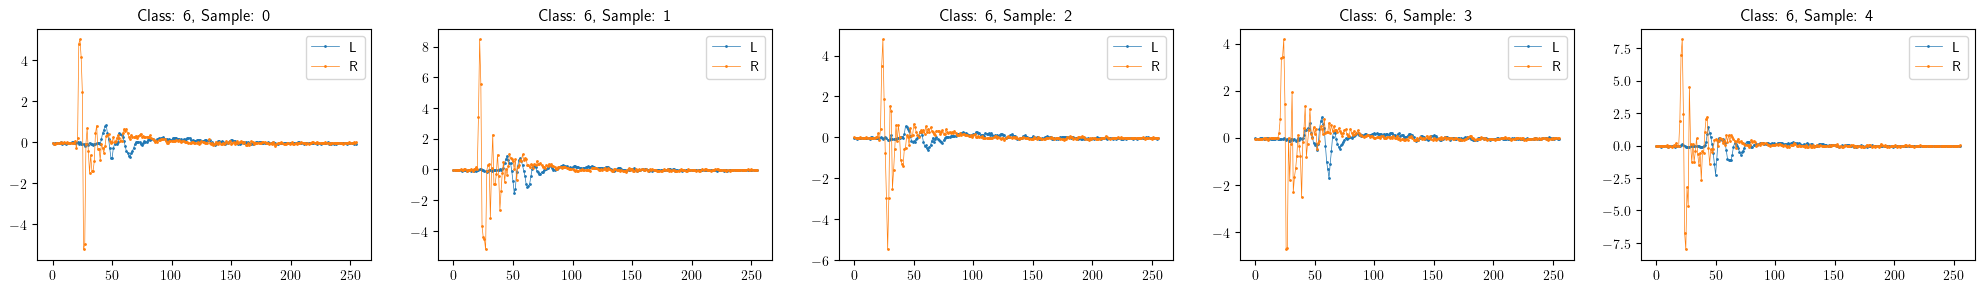

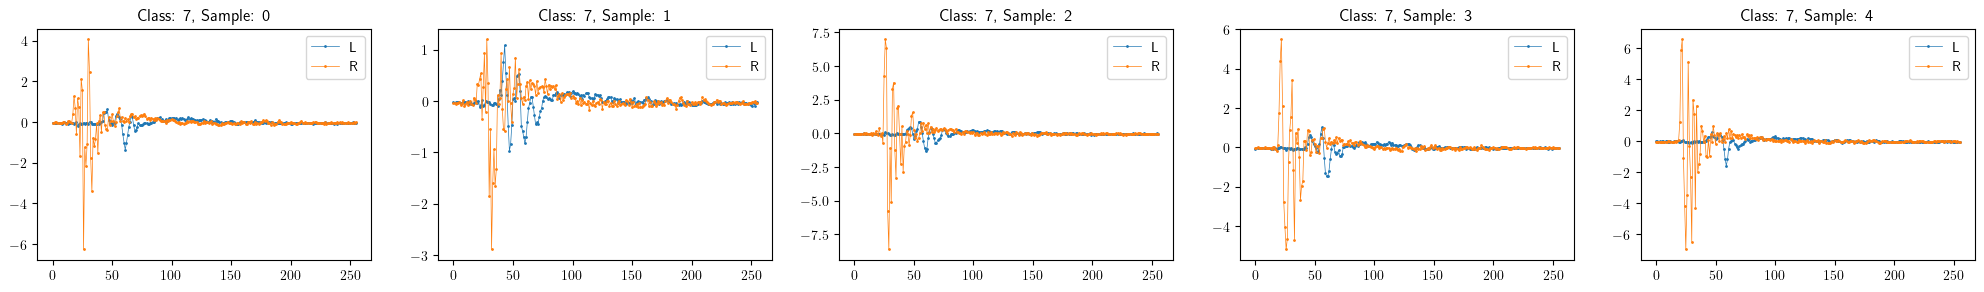

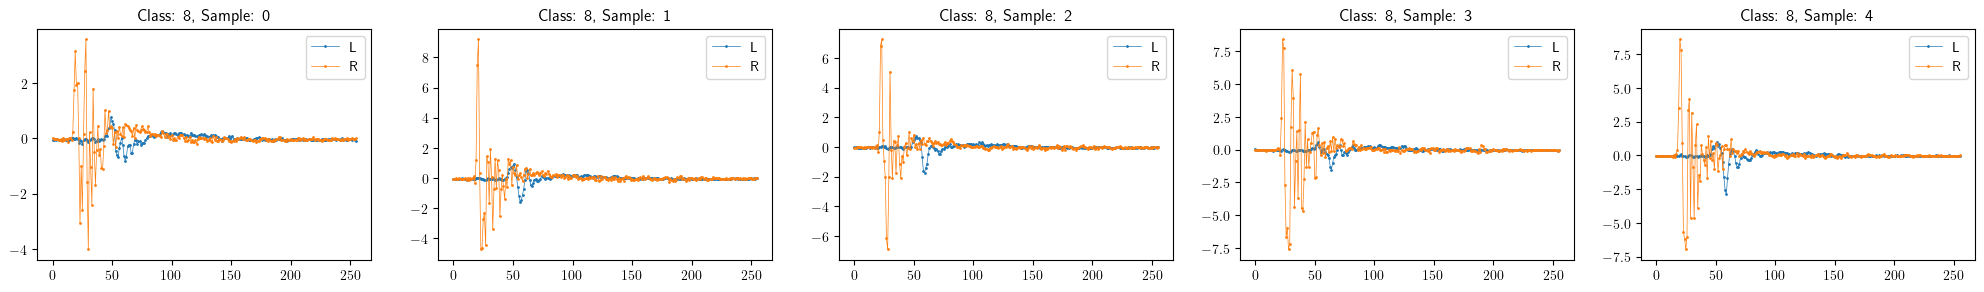

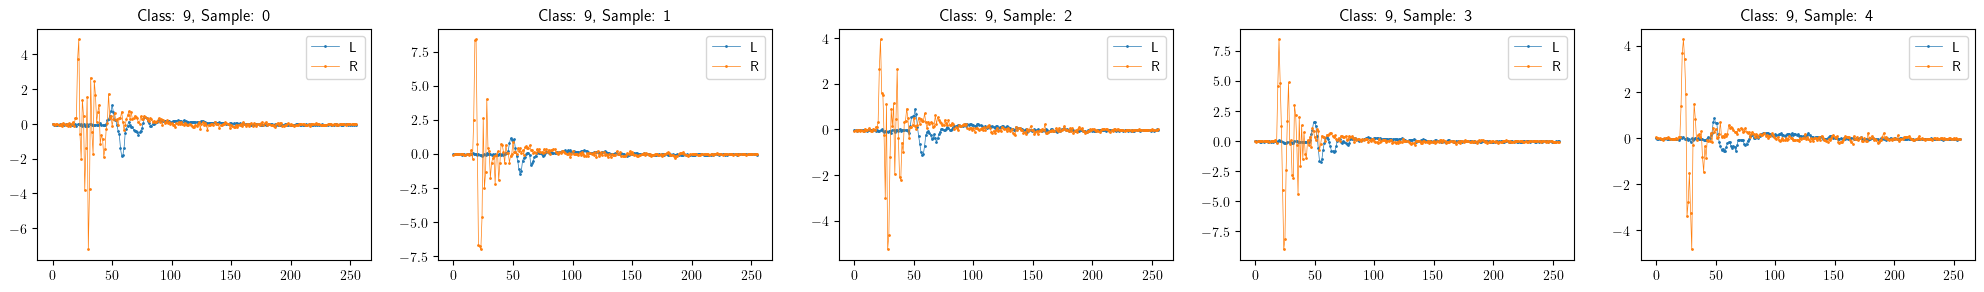

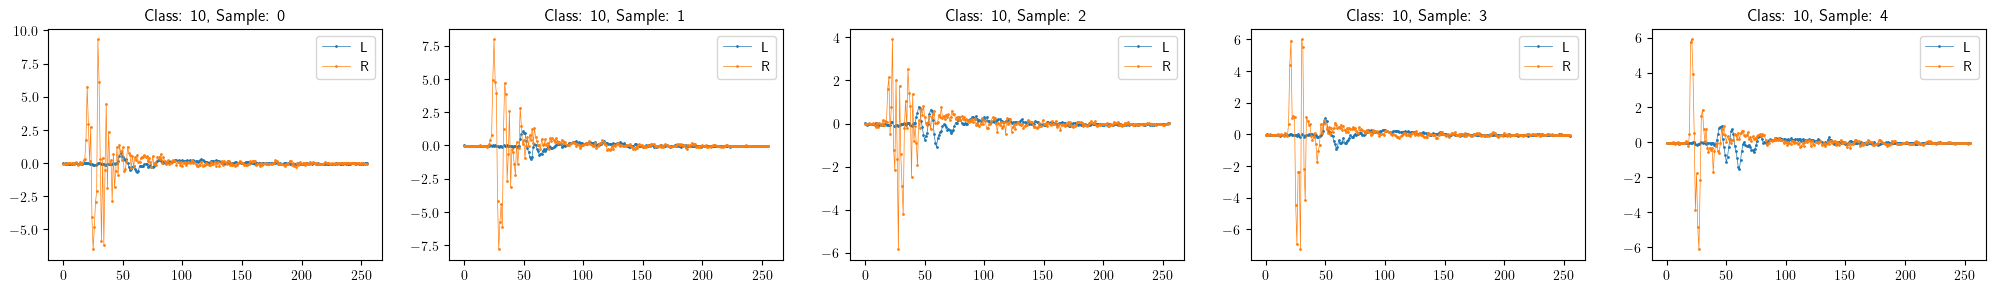

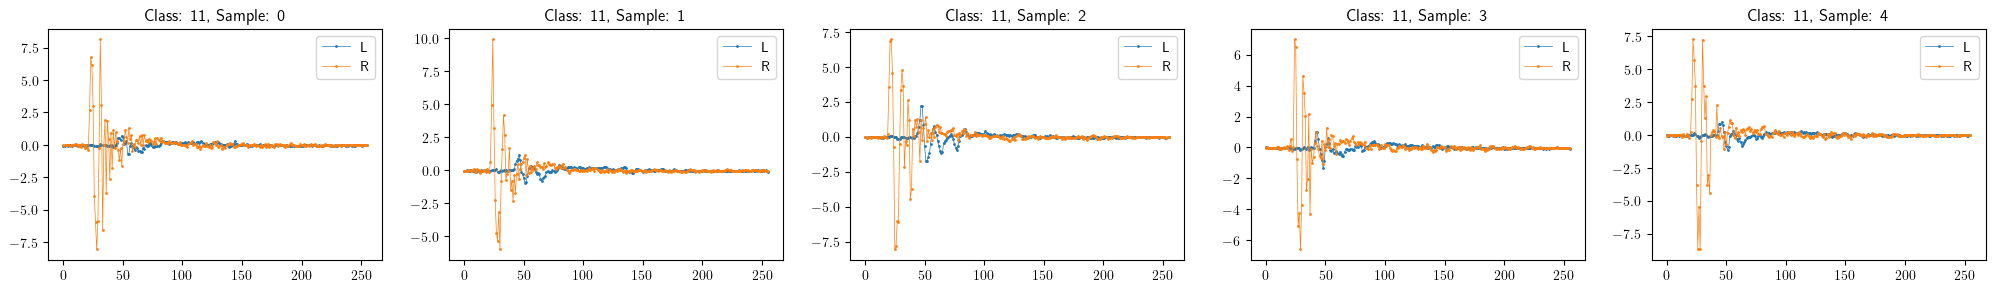

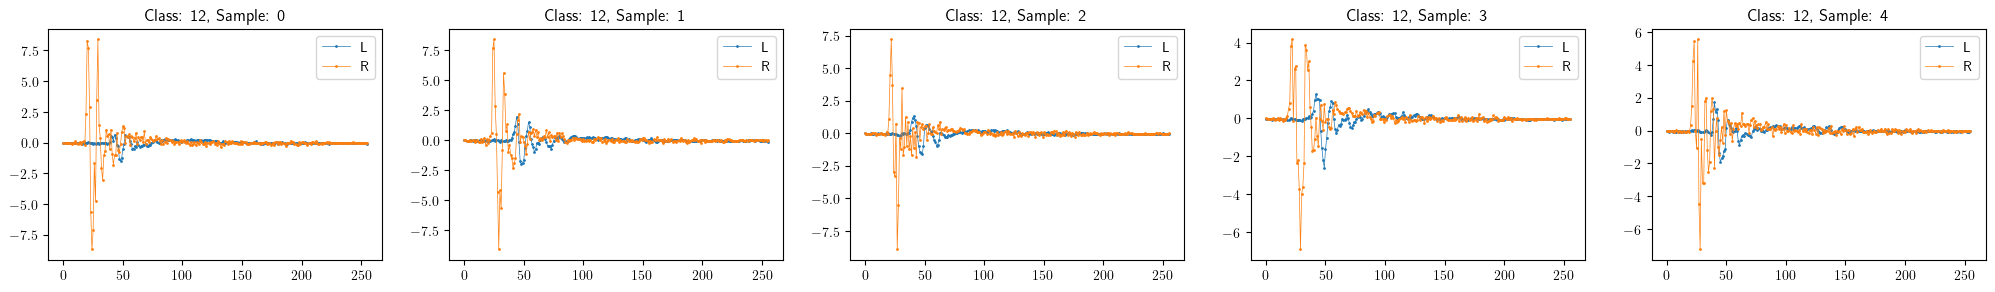

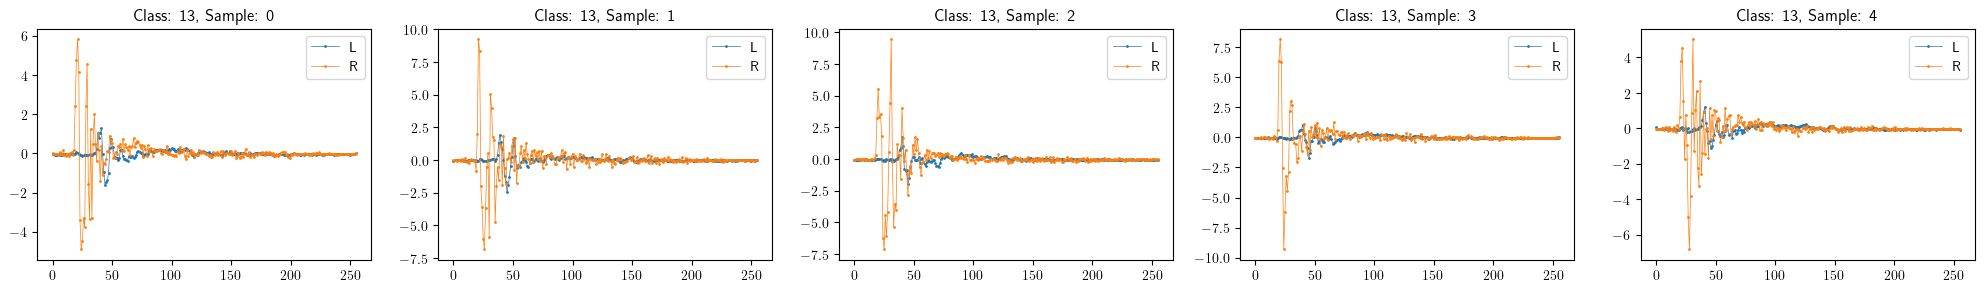

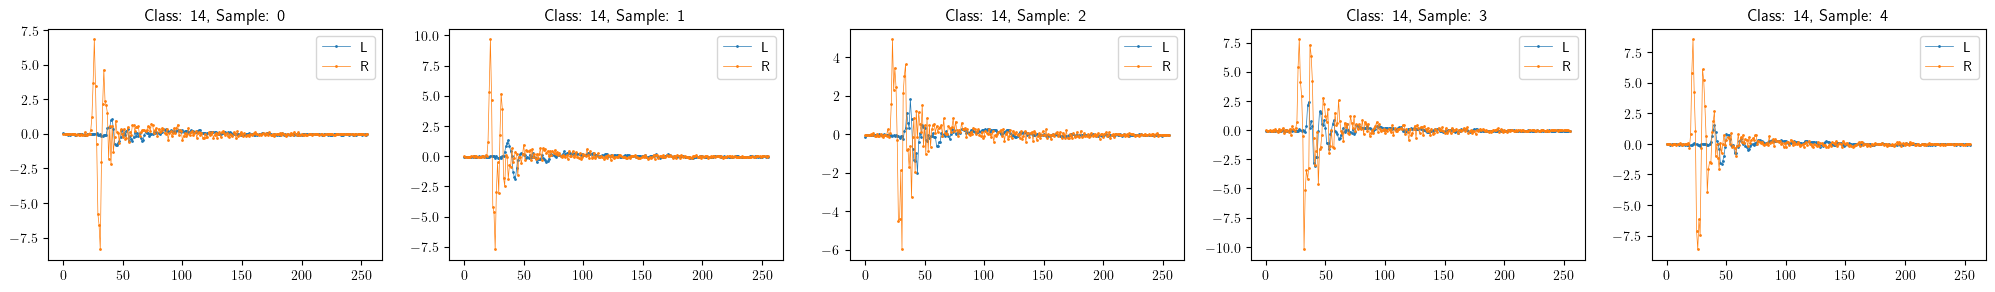

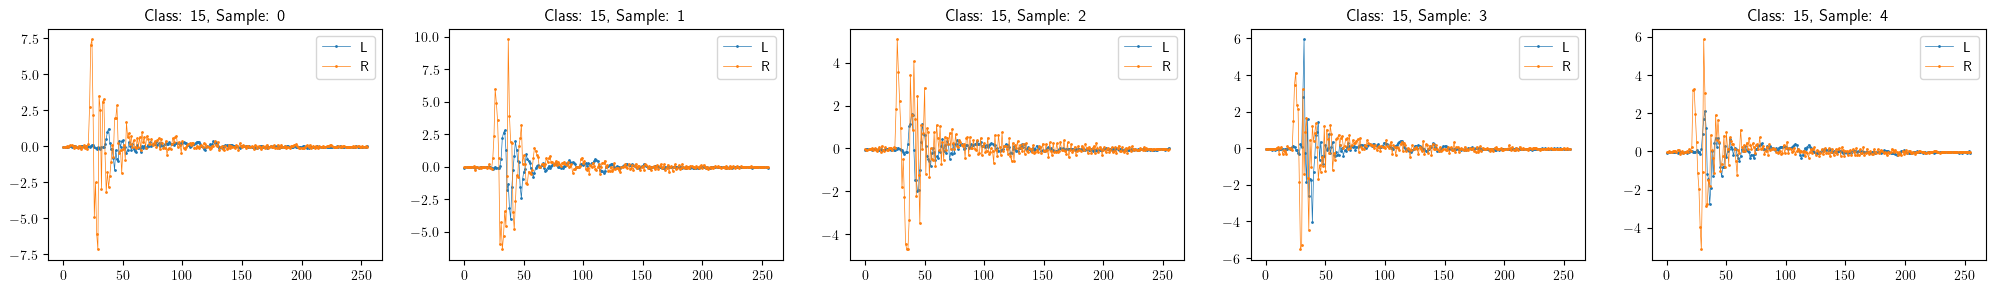

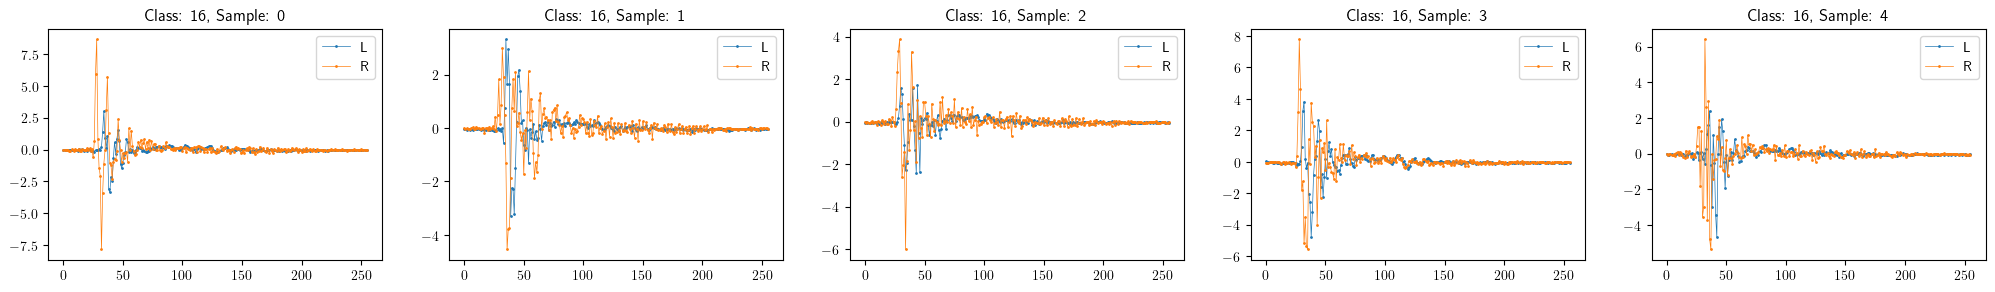

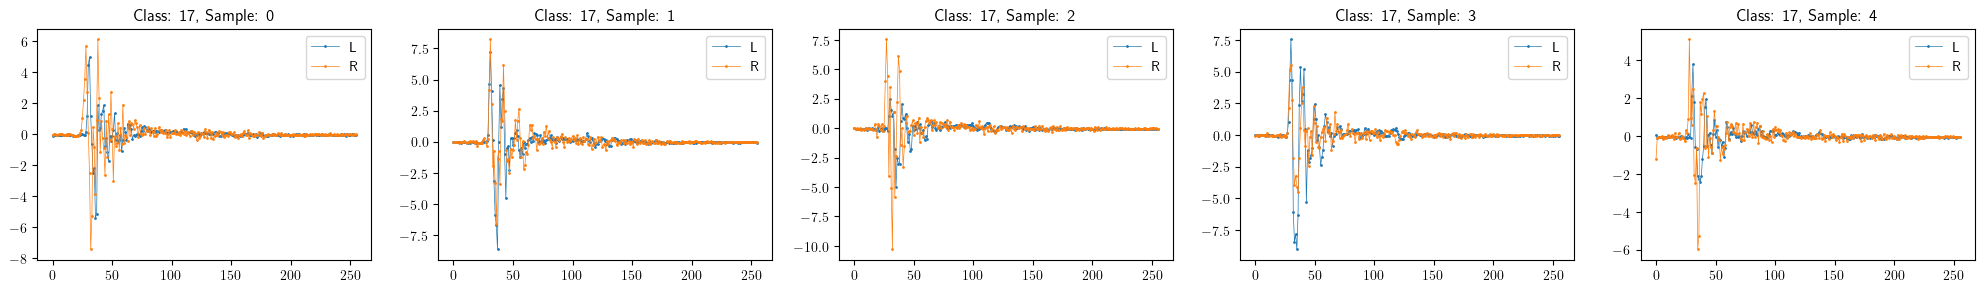

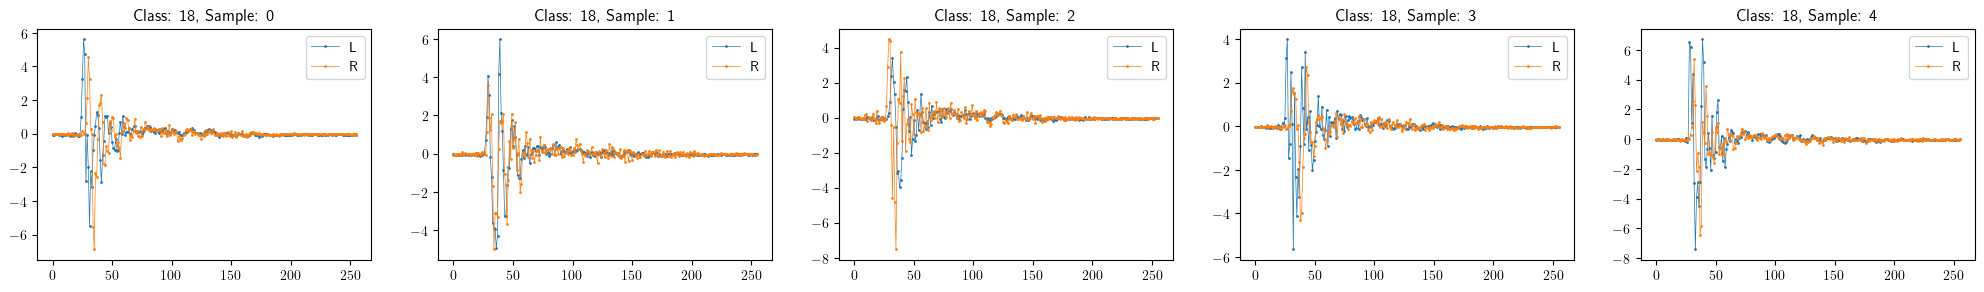

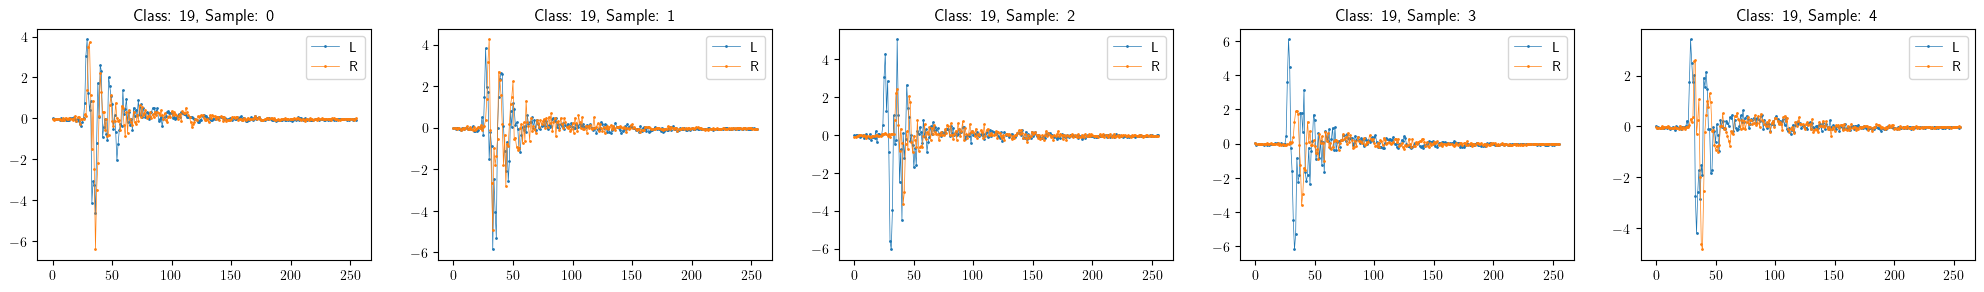

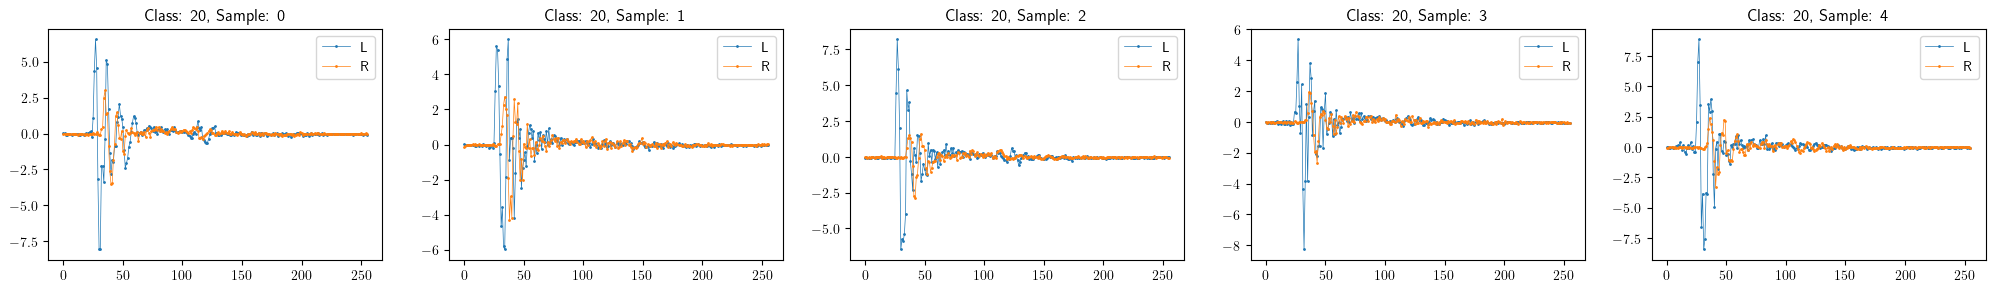

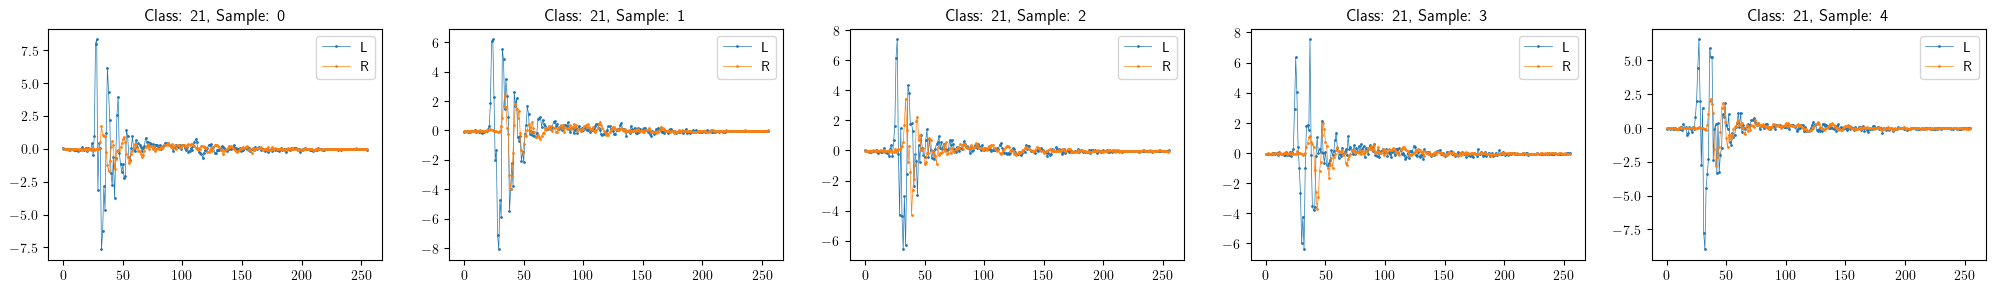

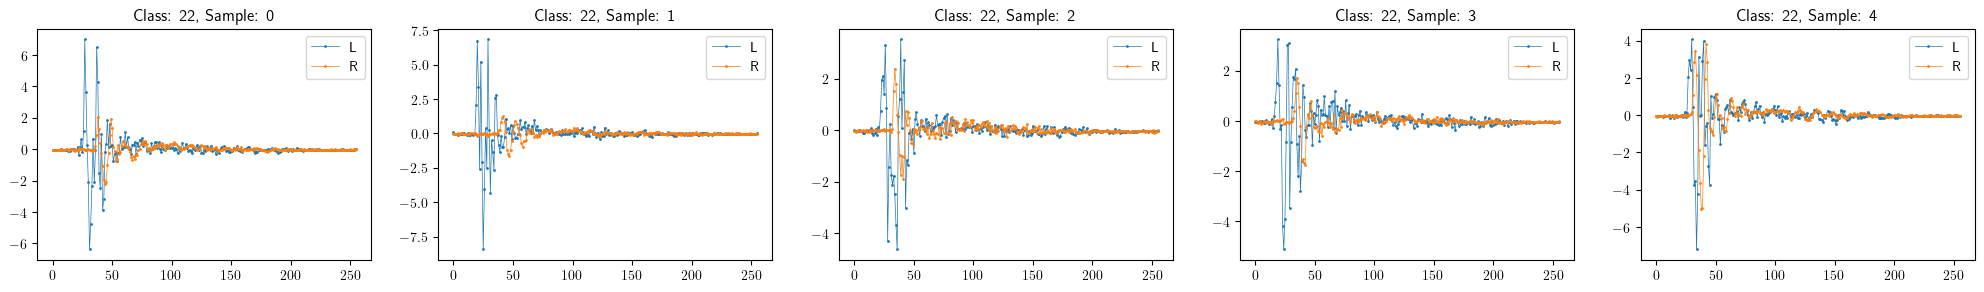

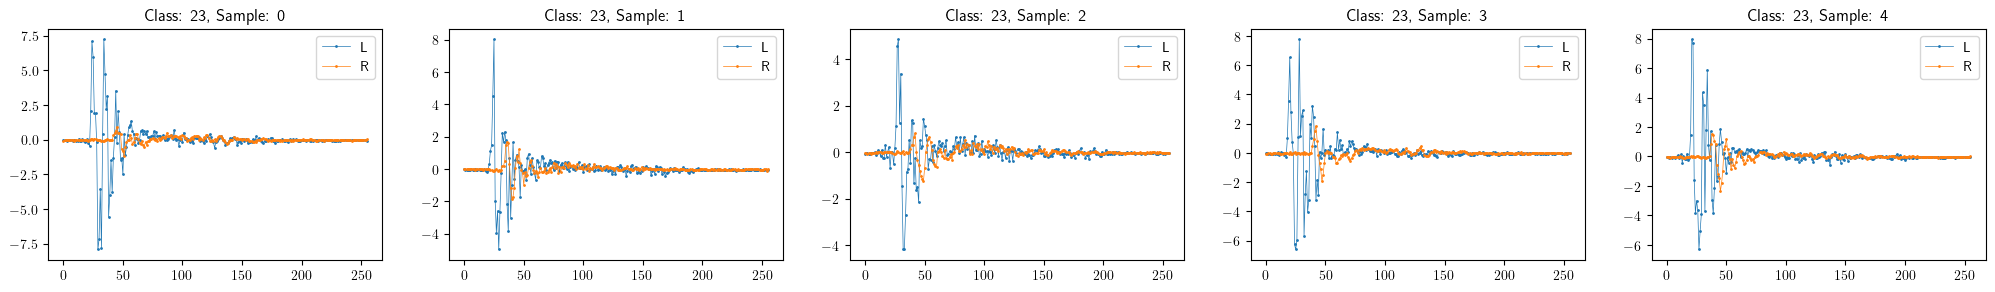

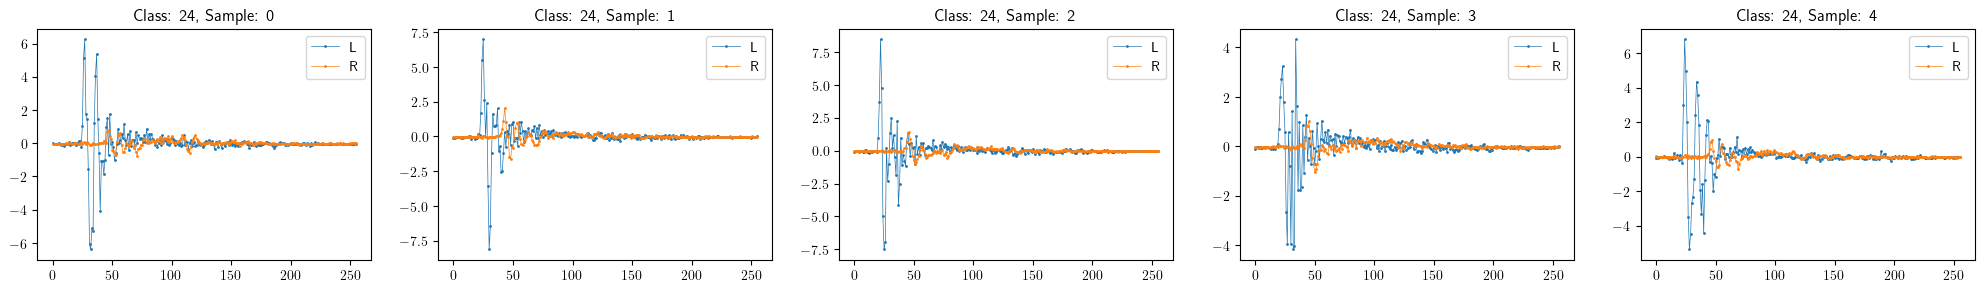

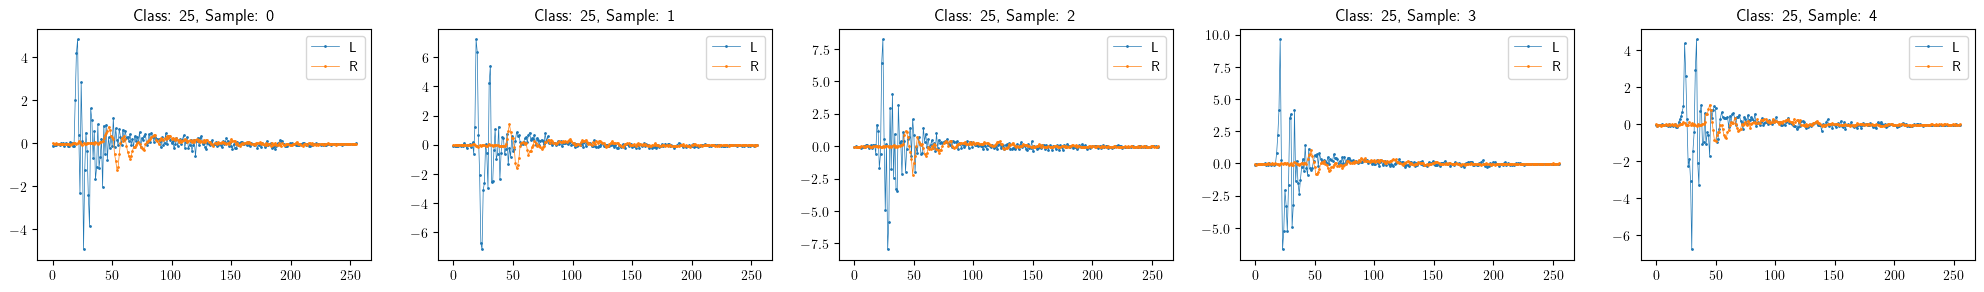

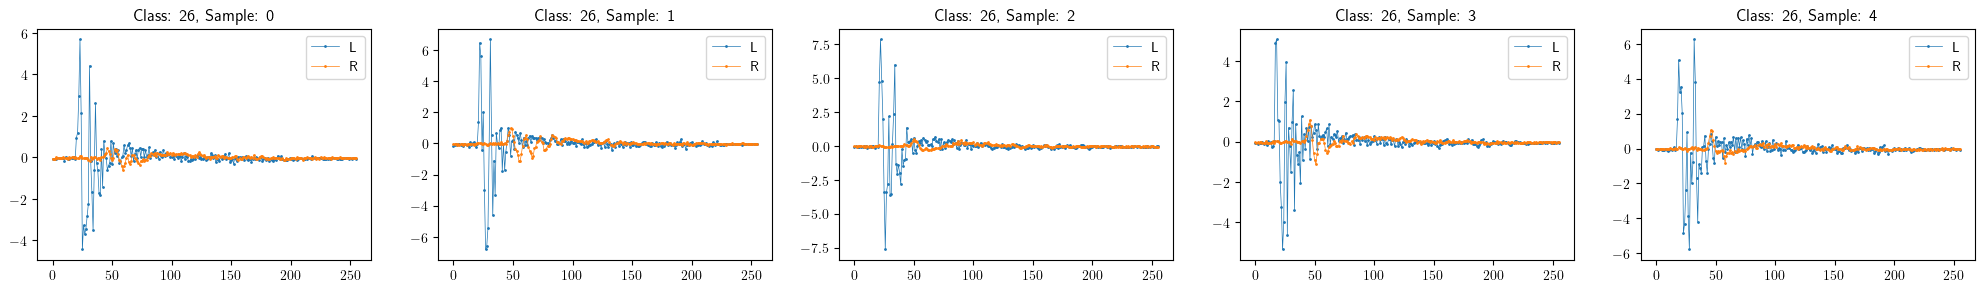

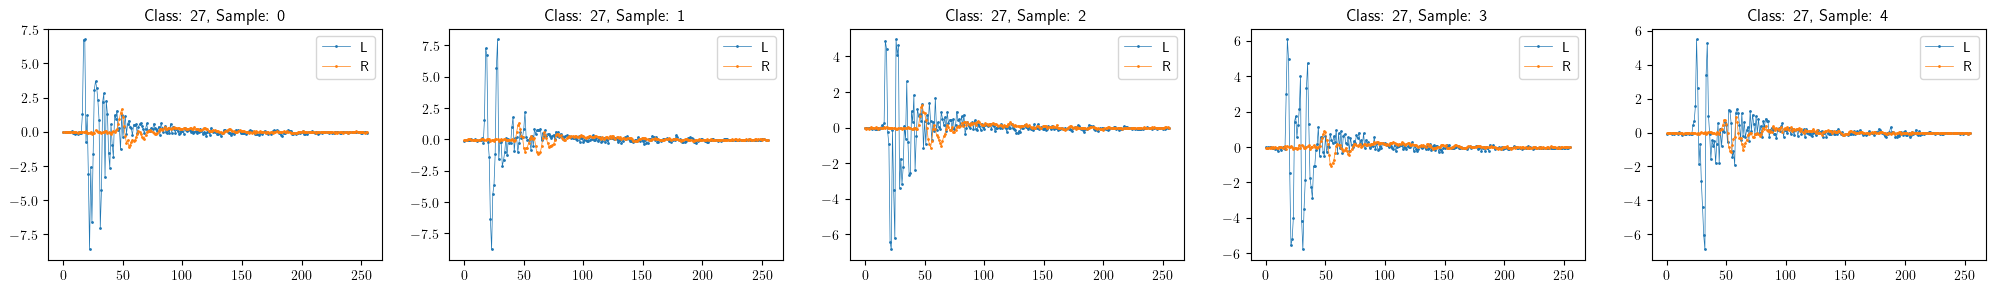

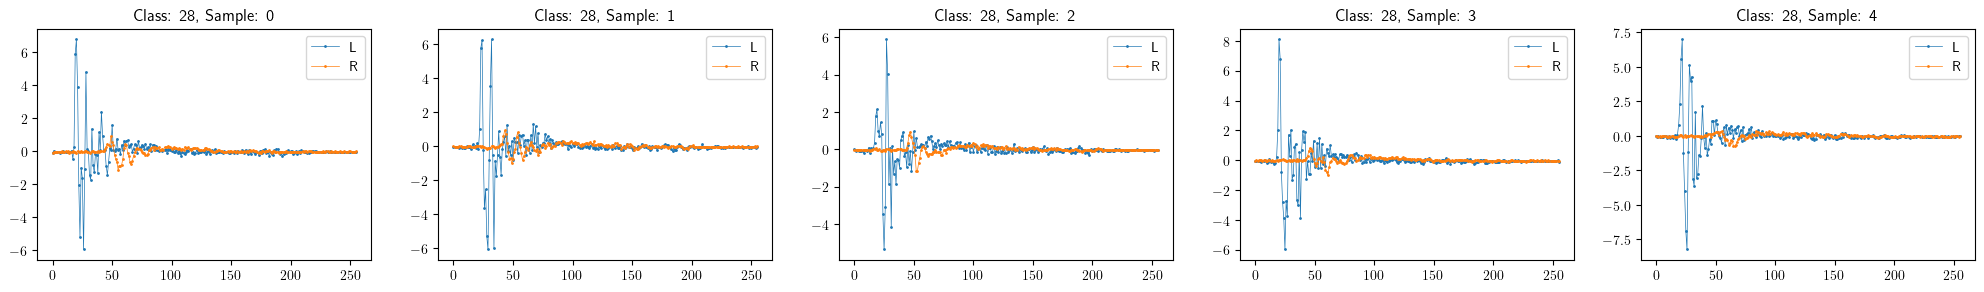

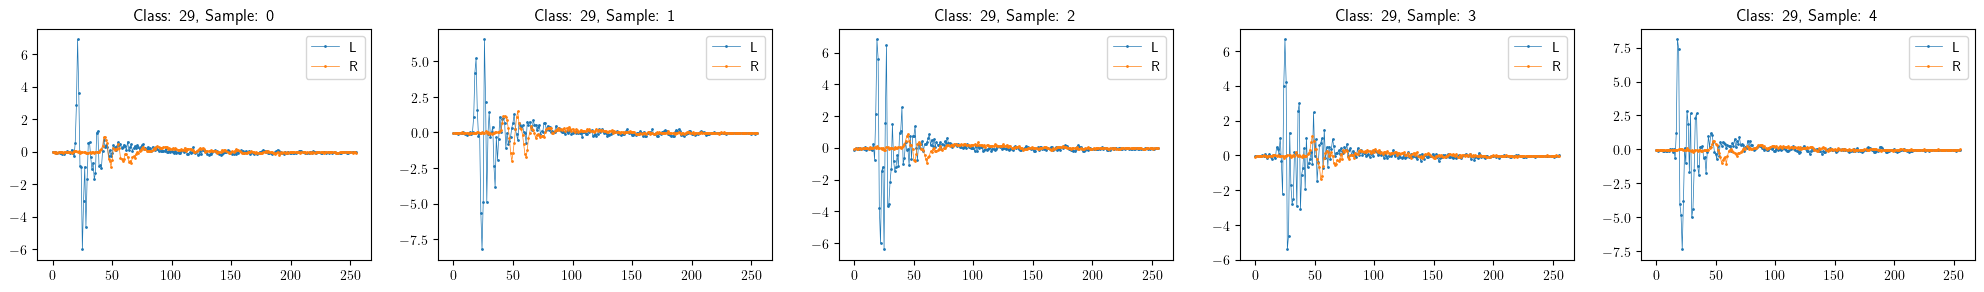

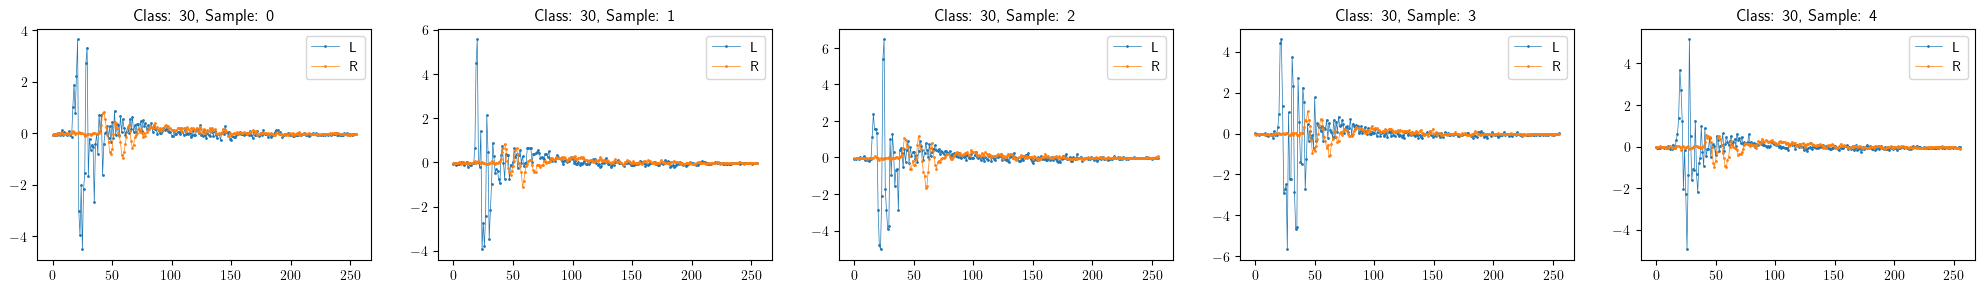

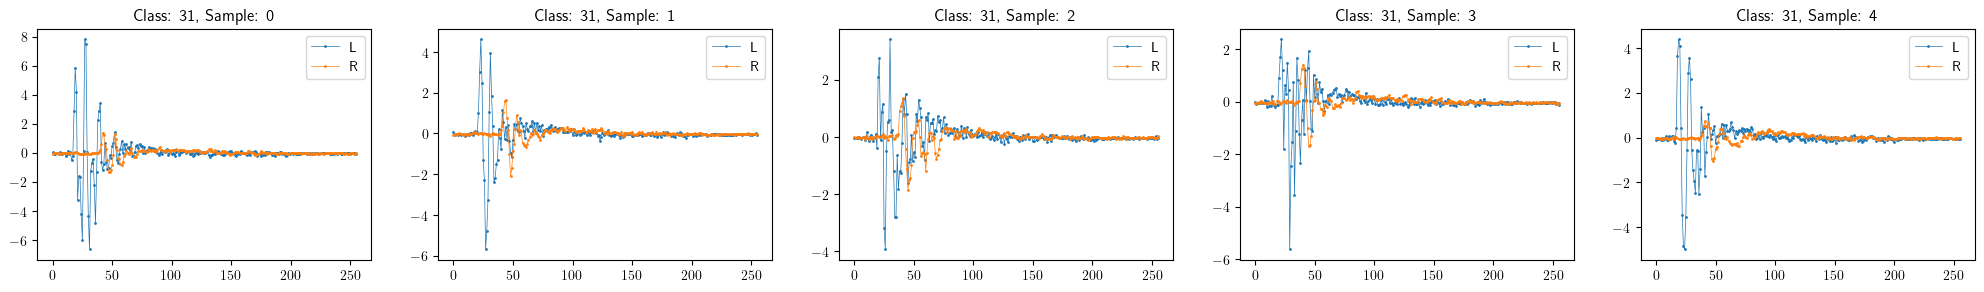

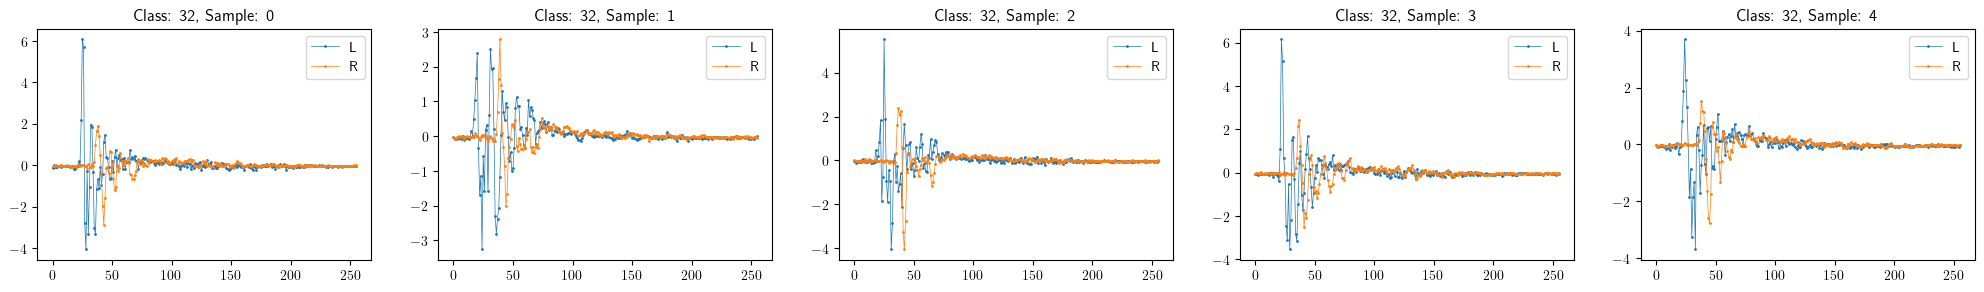

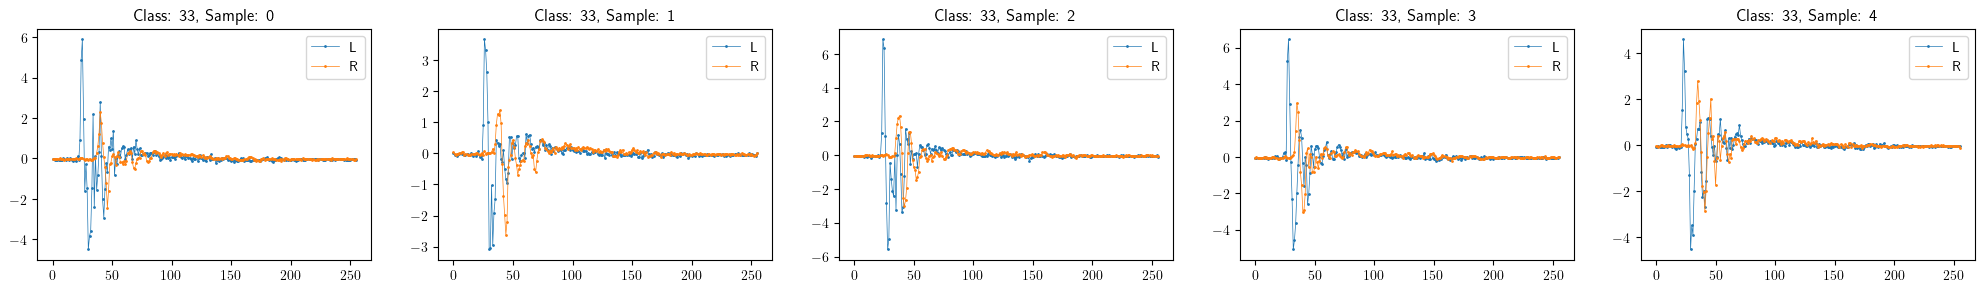

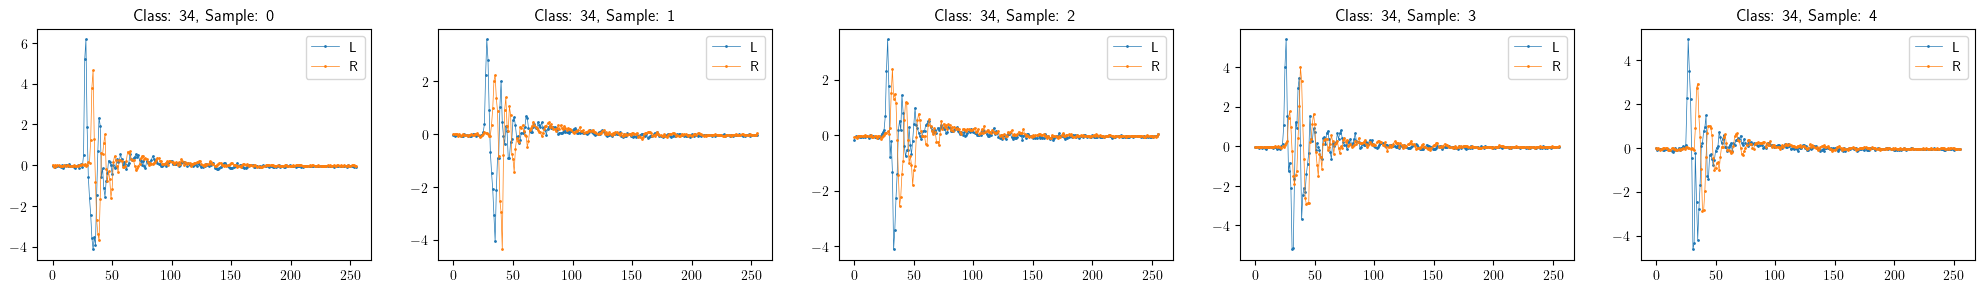

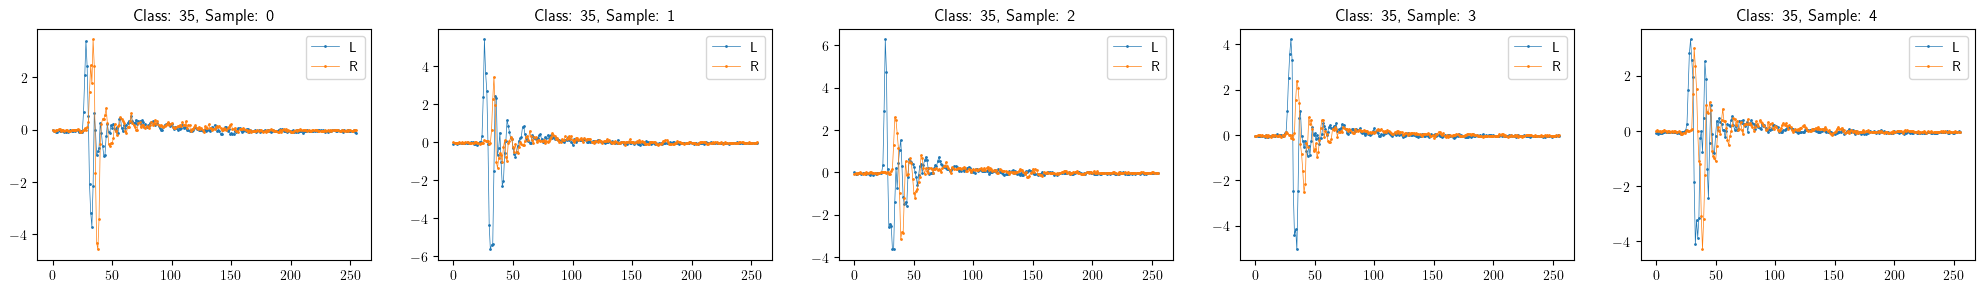

In [58]:
torch.manual_seed(16)
all_hrir = []
samples0 = []
samples3 = []
samples4 = []
# Iterate over classes
for c in range(NUM_CLASSES):
    # Create a single row of subplots for each class
    fig, axes = plt.subplots(1, NUM_DISPLAY_IMAGES, figsize=(25, 3))
    
    # Create subplots for each display image
    for idx in range(NUM_DISPLAY_IMAGES):
        # Generate random audio data
        audio_result = torch.randn((1,) + (2, 256)).to(device)

        # Iterate over time steps in reverse
        for i in reversed(range(diffusion_model.timesteps)):
            t = torch.full((1,), i, dtype=torch.long, device=device)
            labels = torch.tensor([c]).float().to(device).view(1, 1)
            
            # Run the diffusion model backward
            audio_result = diffusion_model.backward(x=audio_result, t=t, model=unet.eval().to(device), labels=labels)
        all_hrir.append(audio_result.clone().detach().cpu())
        if idx == 0:
            samples0.append(audio_result.clone().detach().cpu())
        elif idx == 3:
            samples3.append(audio_result.clone().detach().cpu())
        elif idx == 4:
            samples4.append(audio_result.clone().detach().cpu())
        
        
        axes[idx].plot(audio_result[0, 0].detach().cpu(), label='L', linewidth=0.5, marker='o', markersize=1)
        axes[idx].plot(audio_result[0, 1].detach().cpu(), label='R', linewidth=0.5, marker='o', markersize=1)
        axes[idx].legend()
        axes[idx].set_title(f"Class: {c}, Sample: {idx}")
    
    plt.subplots_adjust(wspace=0.2) 
    plt.show()

In [38]:
print(all_hrir[0].shape)
print(samples0[0].shape)
print(samples3[0].shape)
print(samples4[0].shape)

torch.Size([1, 2, 256])
torch.Size([1, 2, 256])
torch.Size([1, 2, 256])
torch.Size([1, 2, 256])


In [59]:
def energy_based_novelty(x,denorm=True, N=4, c=NUM_CLASSES, type=0):
    #print(x[0][0, 0, :].shape)
    x_l = [None] * c
    x_r = [None] * c
    xl_square = [None] * c
    xr_square = [None] * c
    energy_l_local = [None] * c
    energy_r_local = [None] * c
    energy_l_local_diff = [None] * c
    energy_r_local_diff = [None] * c
    novelty_l_energy = [None] * c
    novelty_r_energy = [None] * c
    peaks_l = [None] * c
    peaks_r = [None] * c
    properties_l = [None] * c
    properties_r = [None] * c
    w = scipy.signal.windows.hann(N)
    if denorm is True:
        for n in range(c):
            #print(n)
            x[n] = (x[n] * global_std) + global_mean
    
    for n in range(c):    
        fig, axes = plt.subplots(1, 1, figsize=(25, 3))
        
        if type==0:
            x_l[n] = x[n][0][0,:]
            x_r[n] = x[n][0][1,:]
        if type==1:
            x_l[n] = x[n][0,0,:]
            x_r[n] = x[n][0,1,:]
            
        xl_square[n] = x_l[n]**2
        xr_square[n] = x_r[n]**2
        energy_l_local[n] = np.convolve(xl_square[n],w**2,'same')
        energy_r_local[n] = np.convolve(xr_square[n],w**2,'same')
        
        #Differentiation and half-wave rectification
        energy_l_local_diff[n] = np.diff(energy_l_local[n])
        energy_l_local_diff[n] = np.concatenate((energy_l_local_diff[n], np.array([0])))
        novelty_l_energy[n] = np.copy(energy_l_local_diff[n])
        novelty_l_energy[n][energy_l_local_diff[n] < 0] = 0

        energy_r_local_diff[n] = np.diff(energy_r_local[n])
        energy_r_local_diff[n] = np.concatenate((energy_r_local_diff[n], np.array([0])))
        novelty_r_energy[n] = np.copy(energy_r_local_diff[n])
        novelty_r_energy[n][energy_r_local_diff[n] < 0] = 0
        
        novelty_l_energy[n] = novelty_l_energy[n]/max(novelty_l_energy[n])
        novelty_r_energy[n] = novelty_r_energy[n]/max(novelty_r_energy[n])
        
        peaks_l[n], properties_l[n] = scipy.signal.find_peaks(novelty_l_energy[n], prominence=0.1)
        peaks_r[n],properties_r[n] = scipy.signal.find_peaks(novelty_r_energy[n], prominence=0.1)
        

        
        axes.plot(novelty_l_energy[n], linewidth=0.5, marker='o', markersize=1)
        axes.plot(novelty_r_energy[n], linewidth=0.5, marker='o', markersize=1)
        axes.scatter(peaks_l[n],novelty_l_energy[n][peaks_l[n]], marker='o', color='red' )
        axes.scatter(peaks_r[n],novelty_r_energy[n][peaks_r[n]], marker='o', color='red' )
        #axes.legend()
        axes.set_title(f"Class: {n}")
        
    return peaks_l, peaks_r

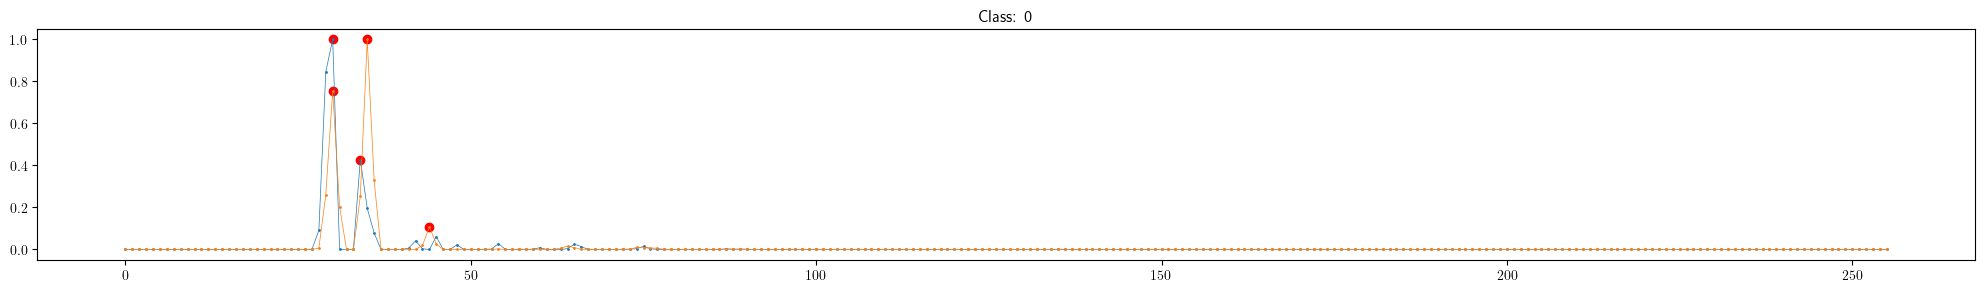

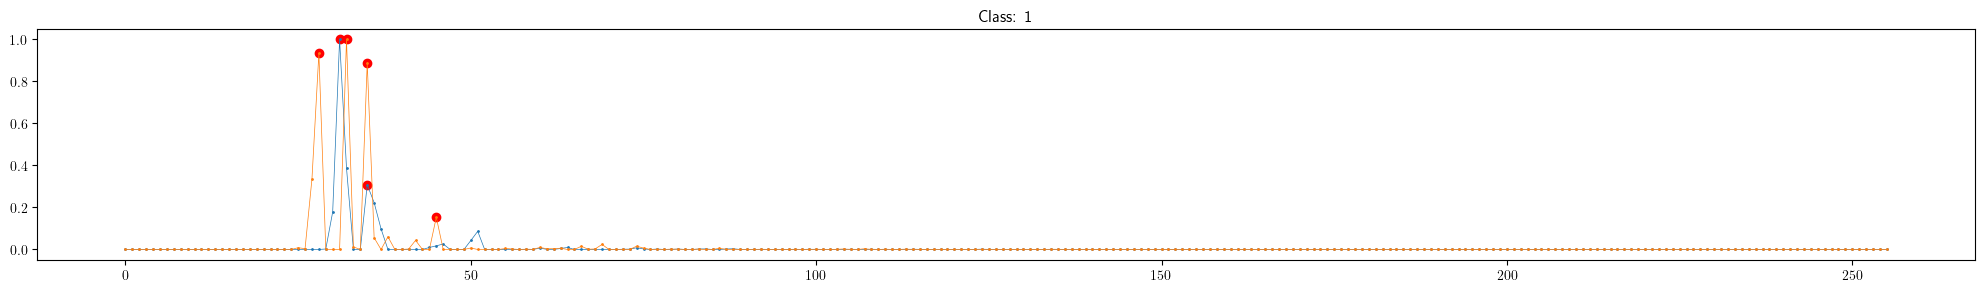

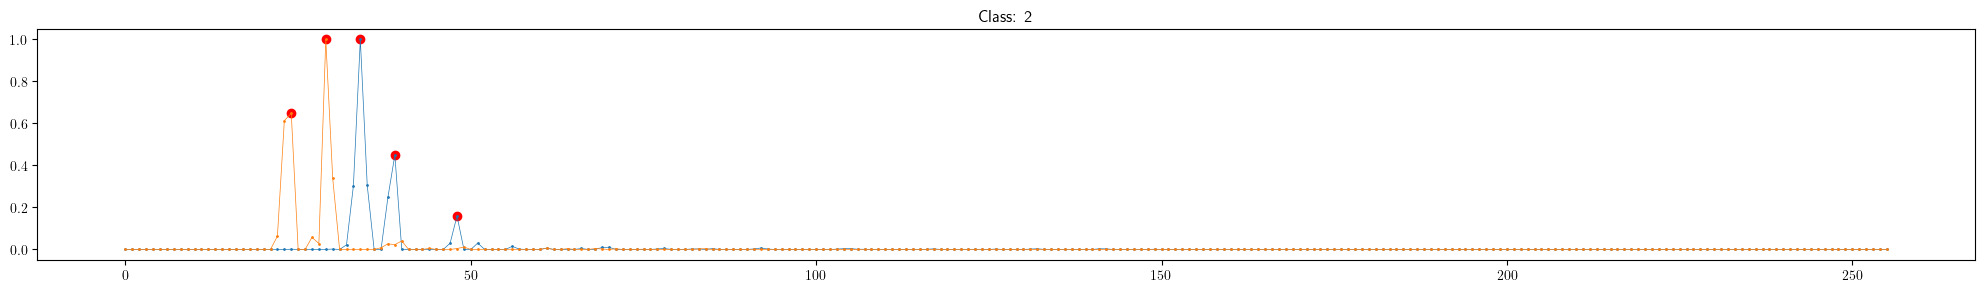

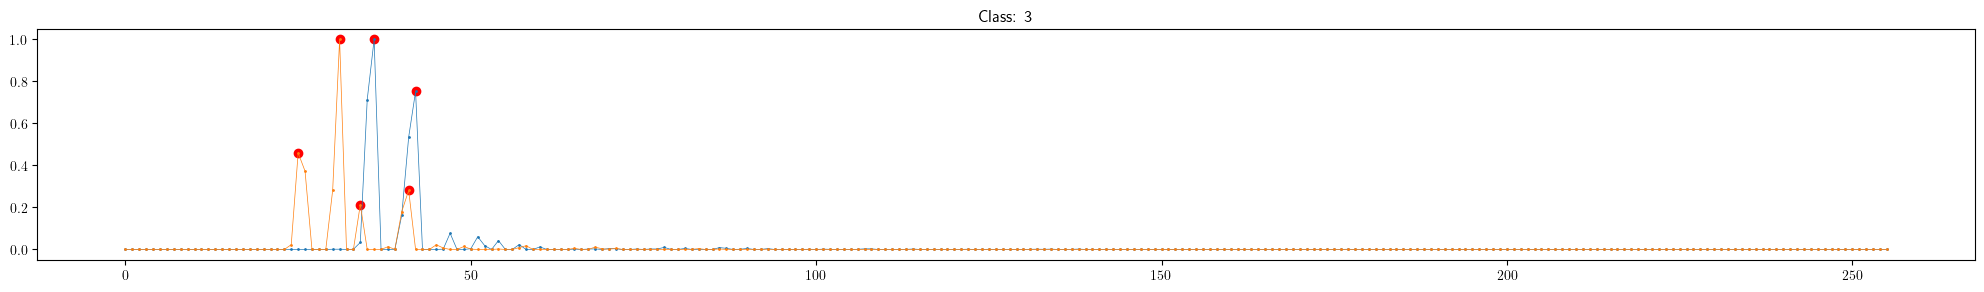

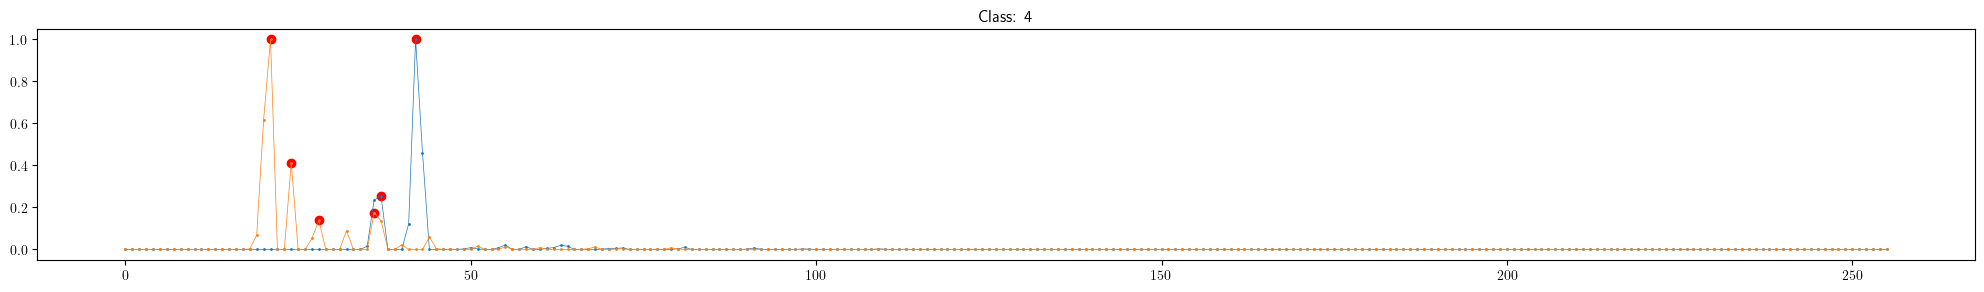

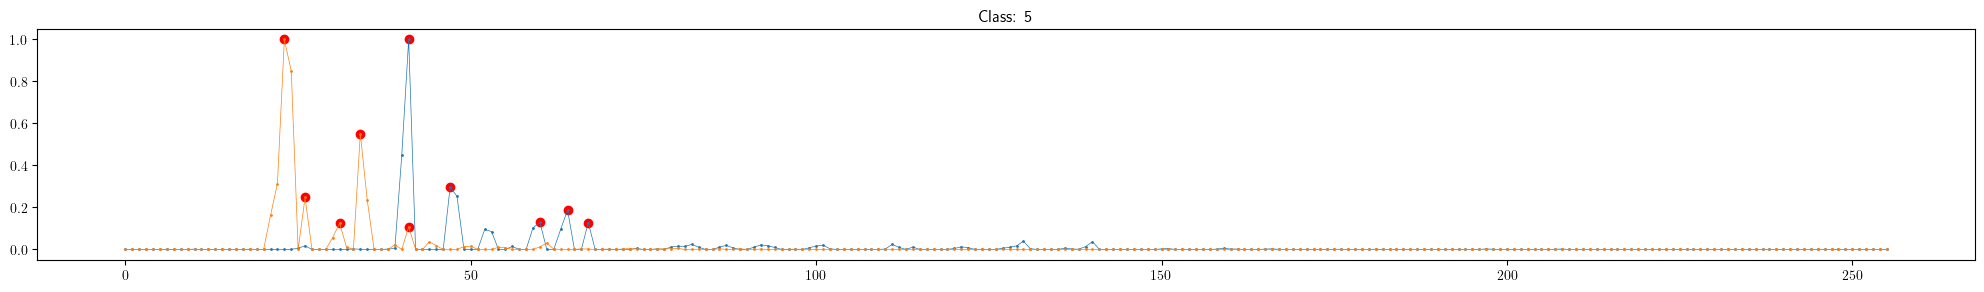

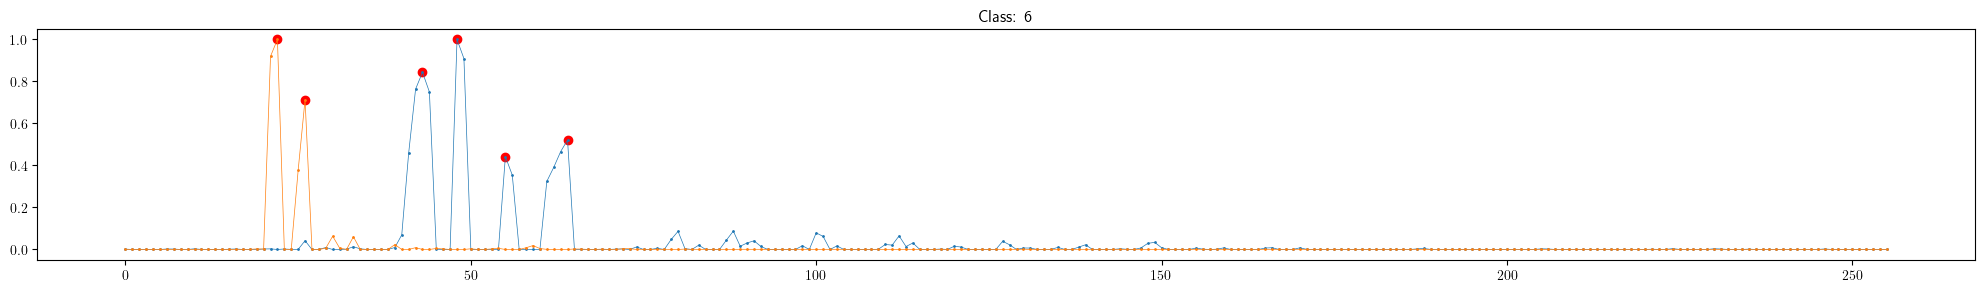

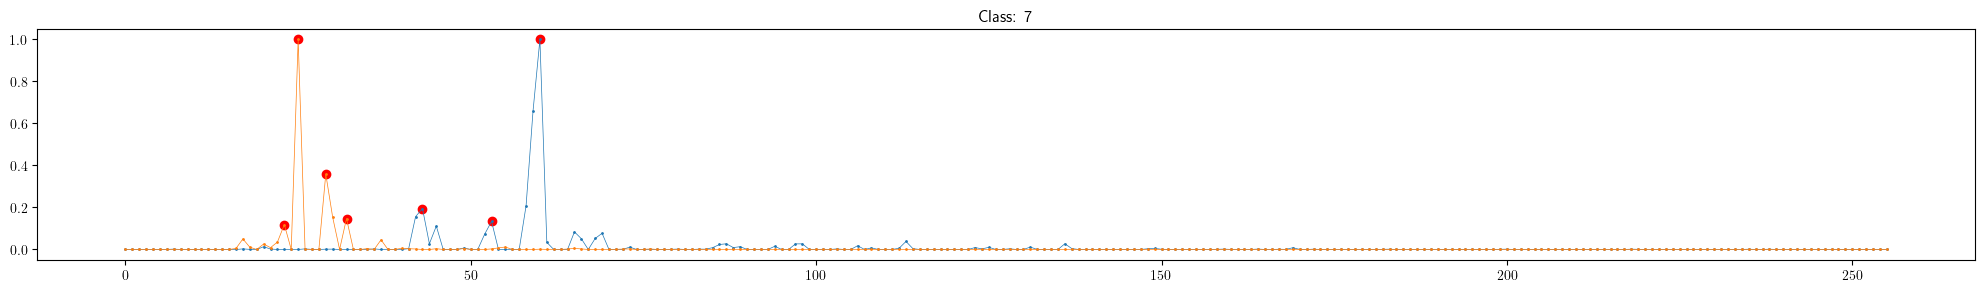

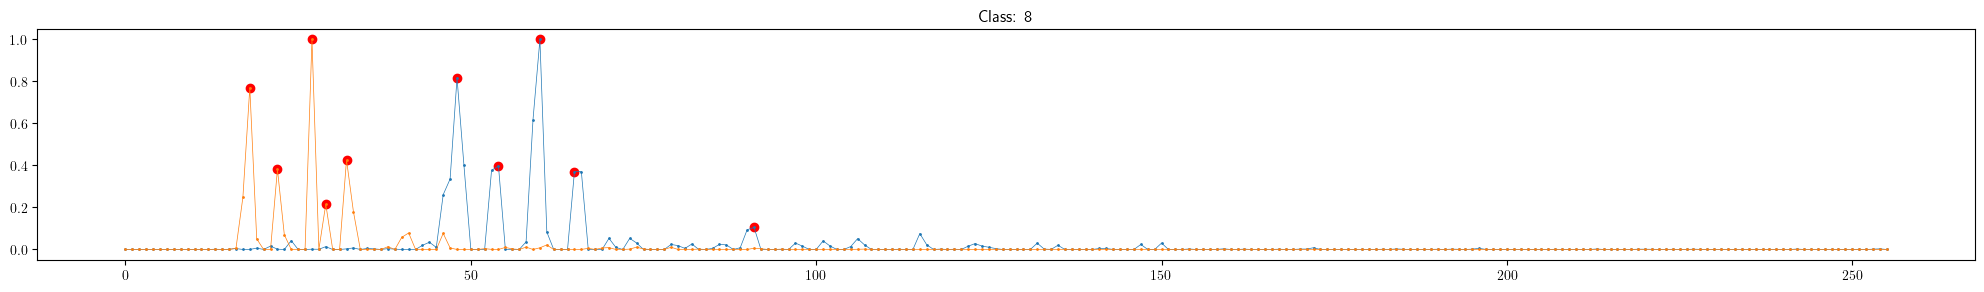

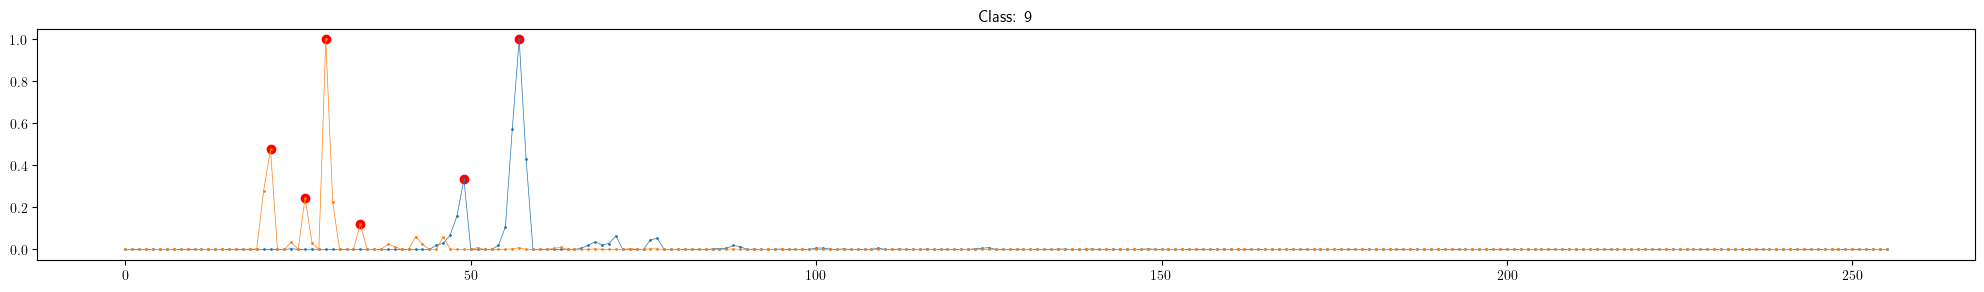

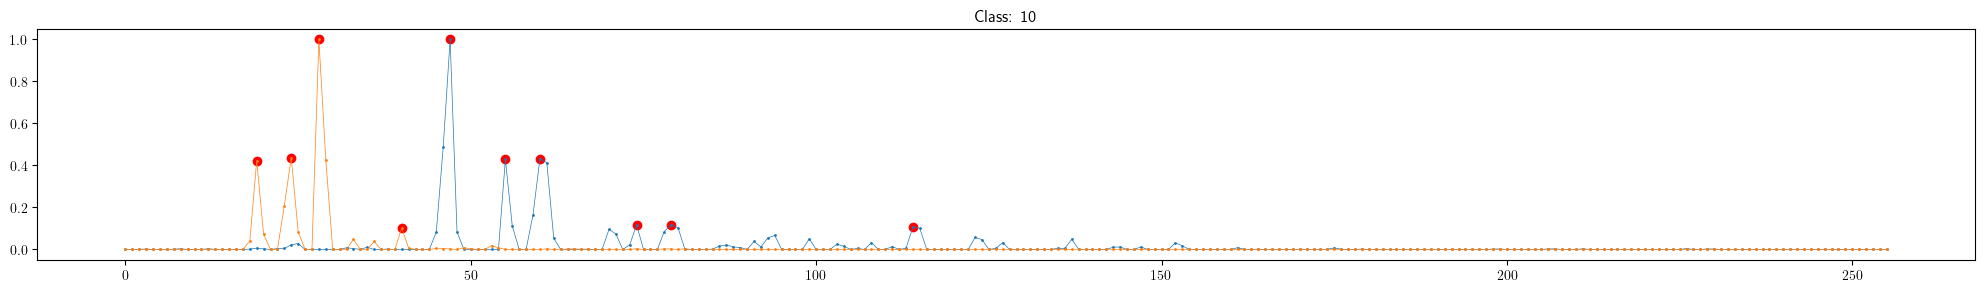

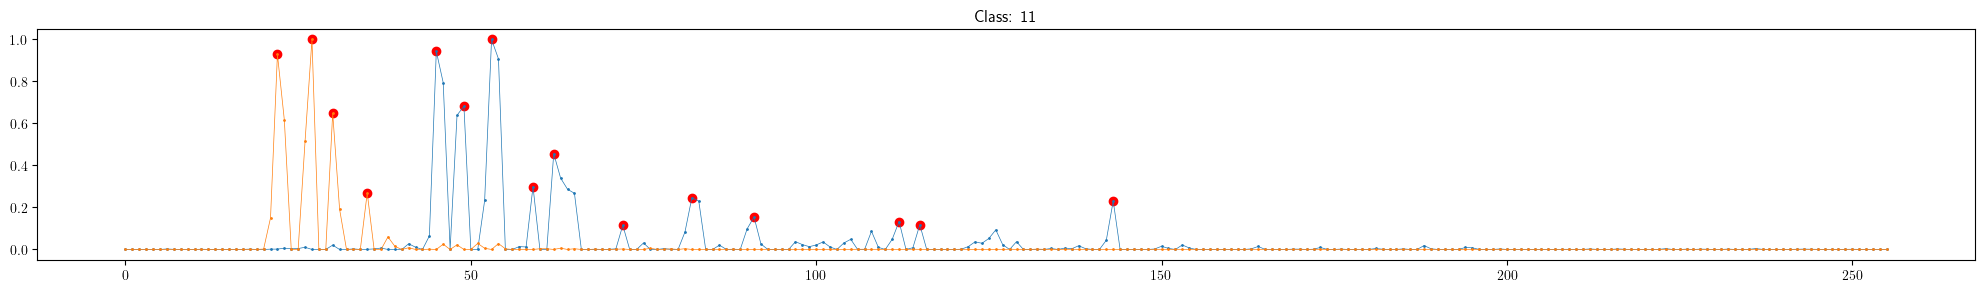

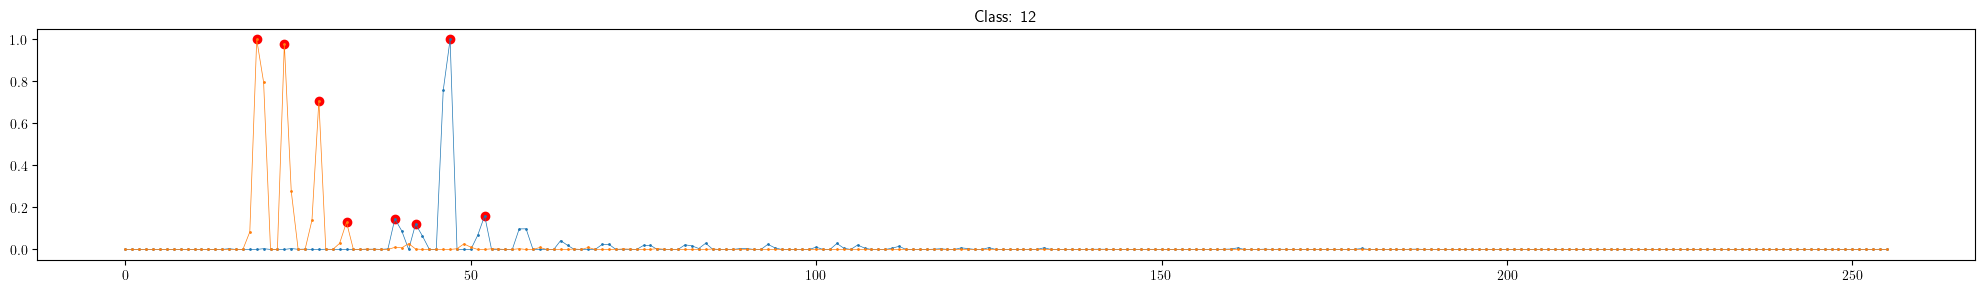

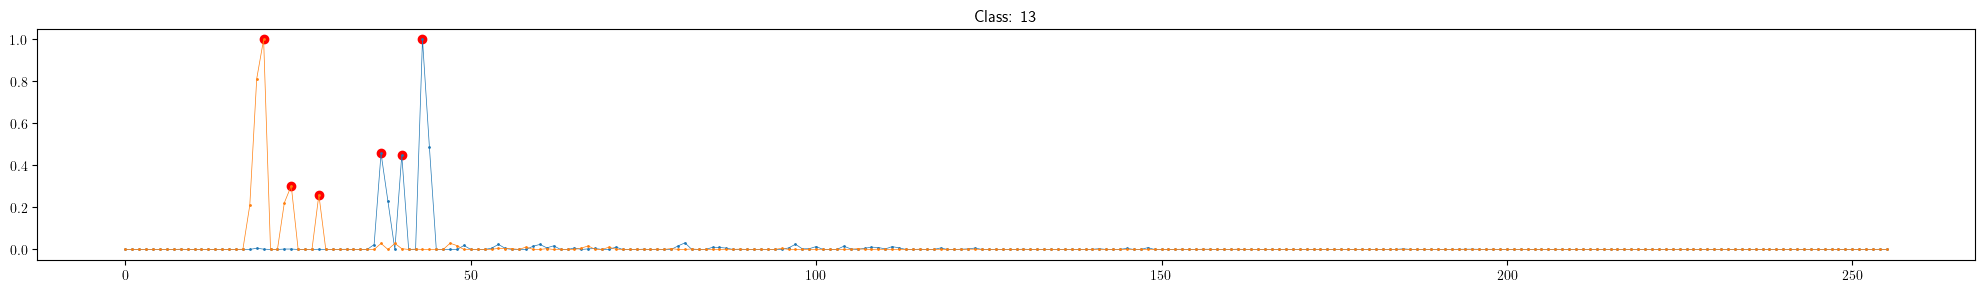

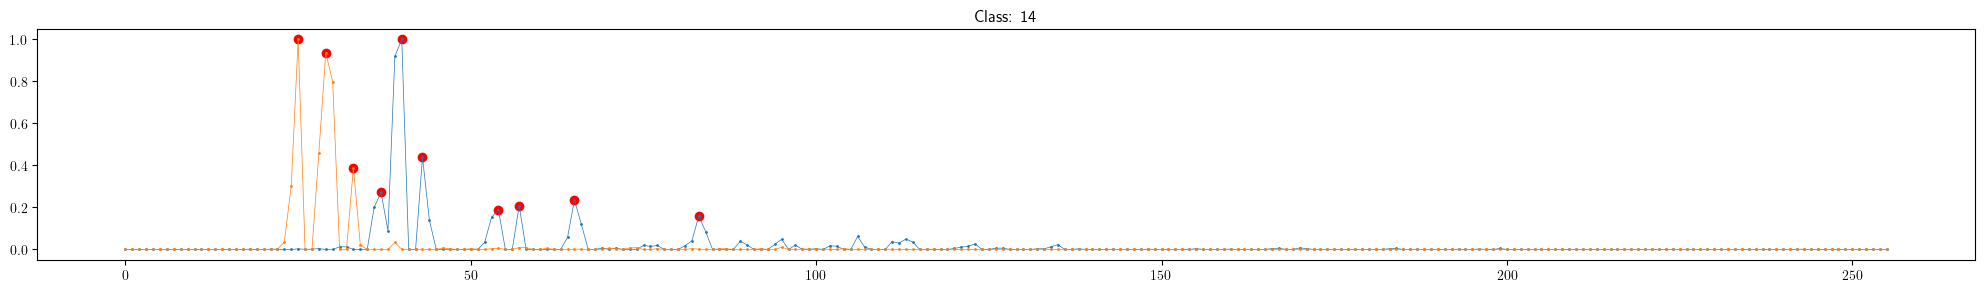

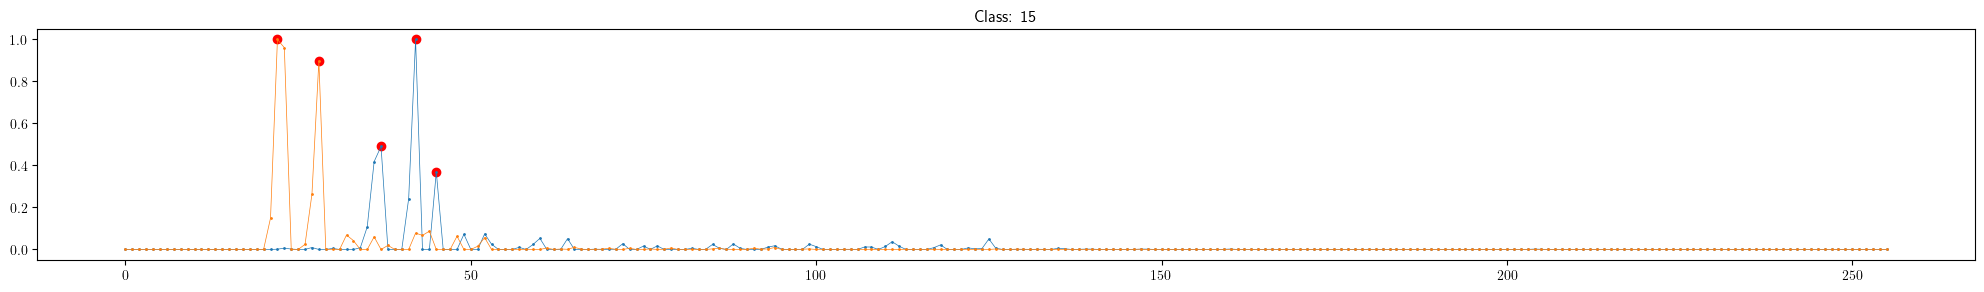

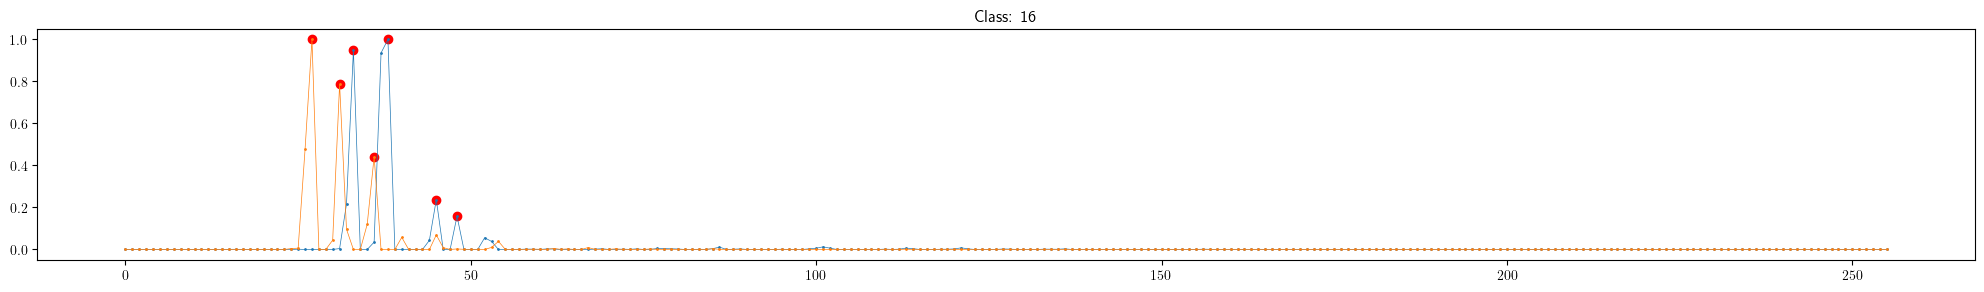

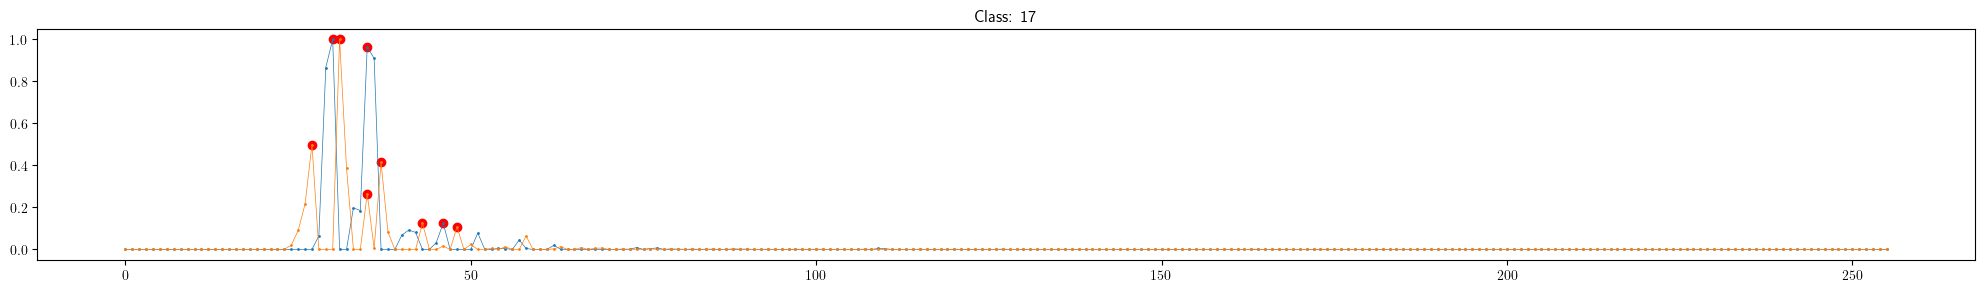

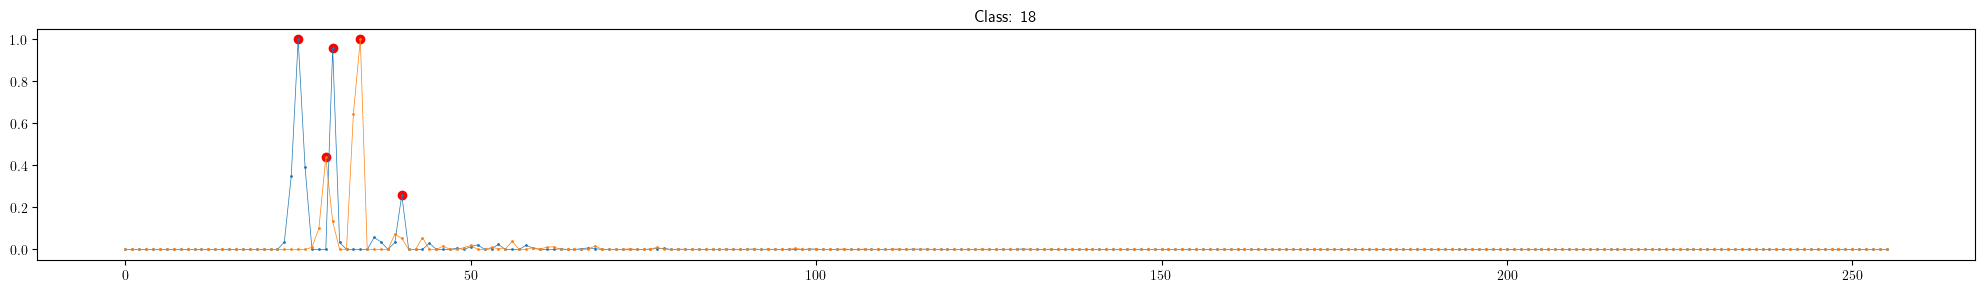

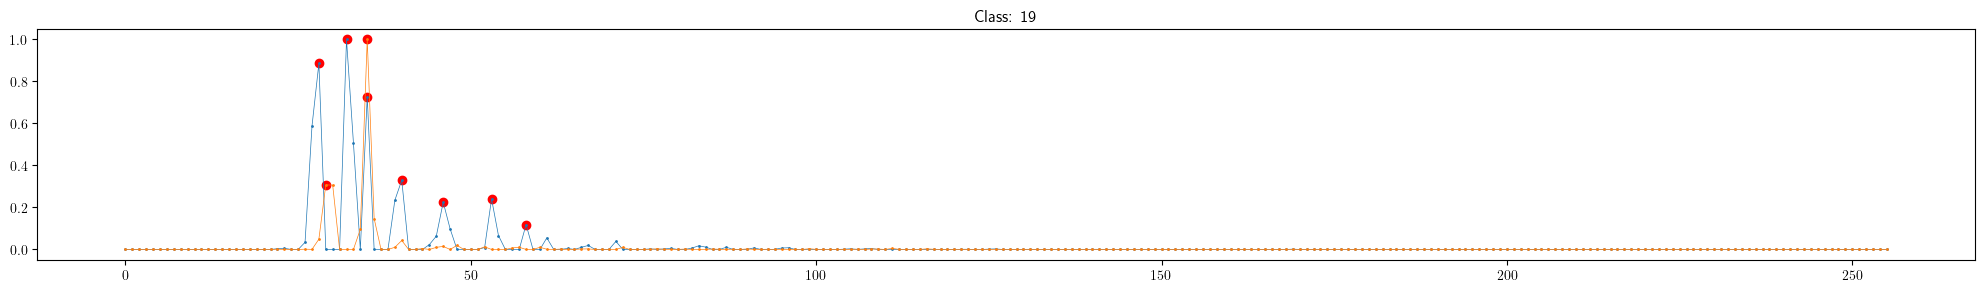

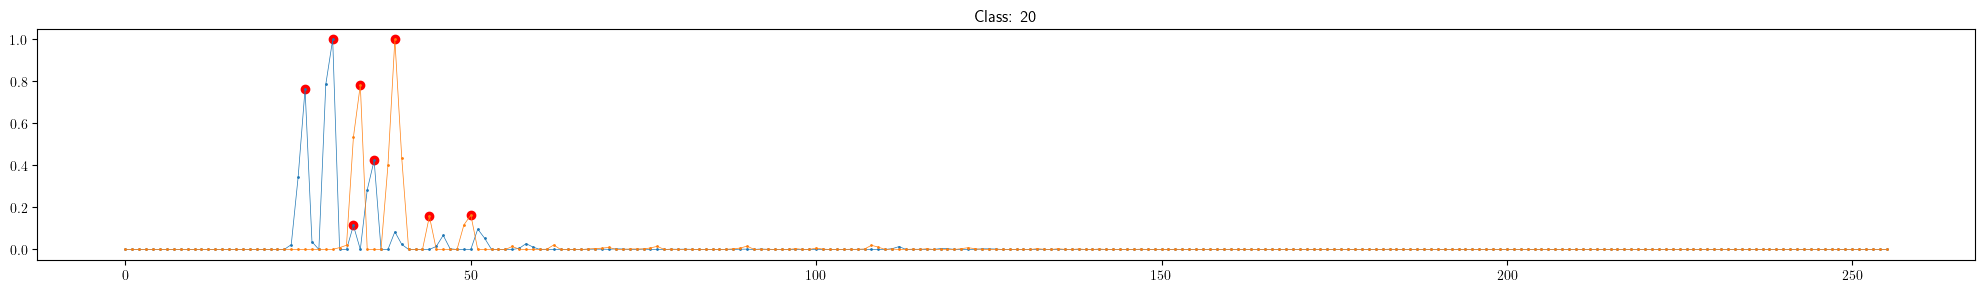

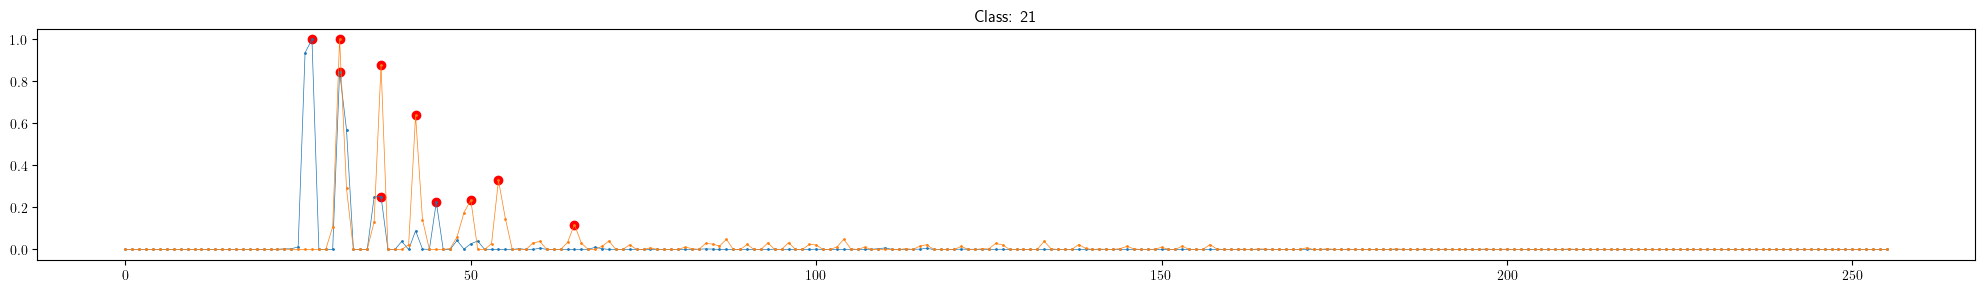

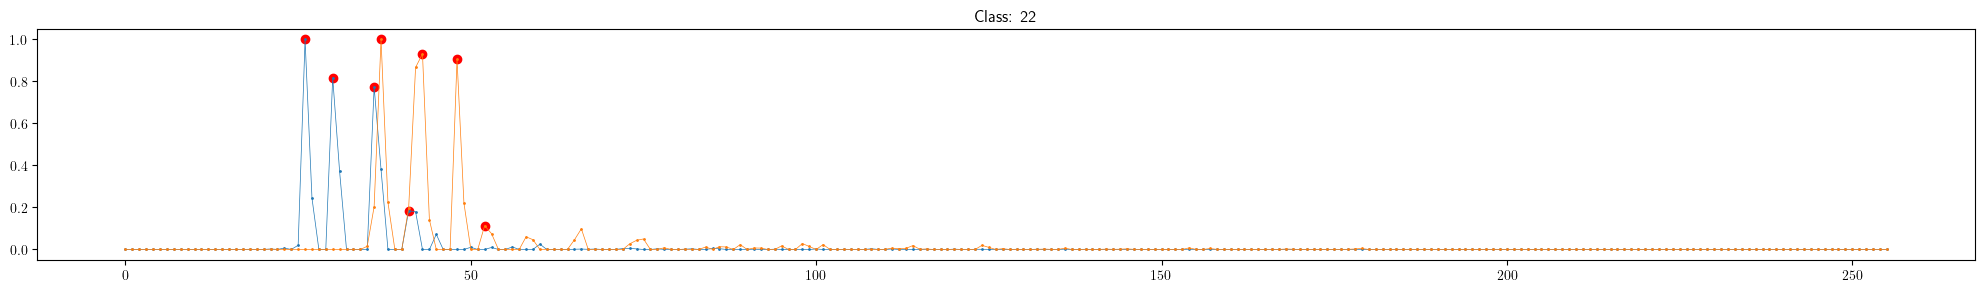

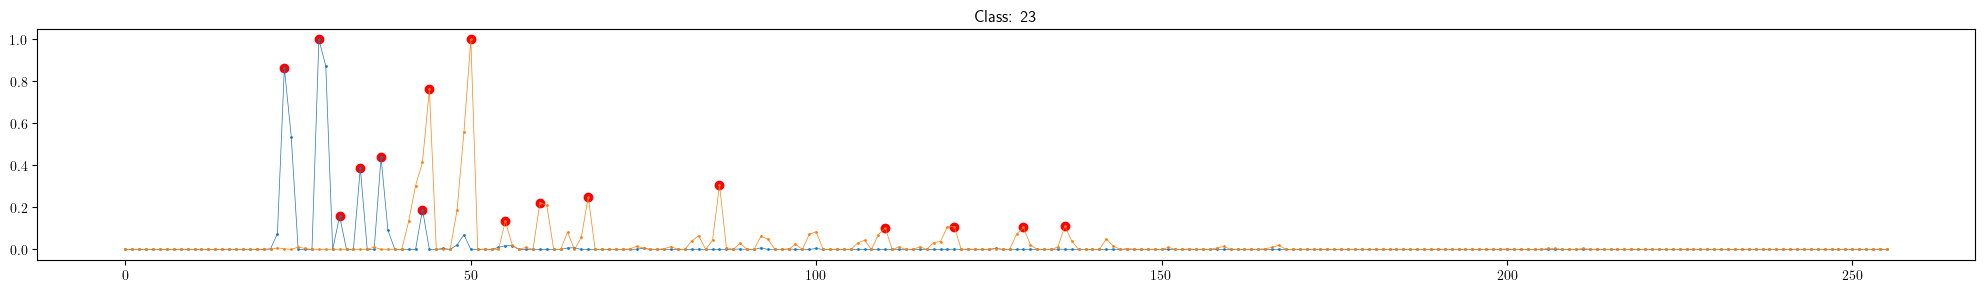

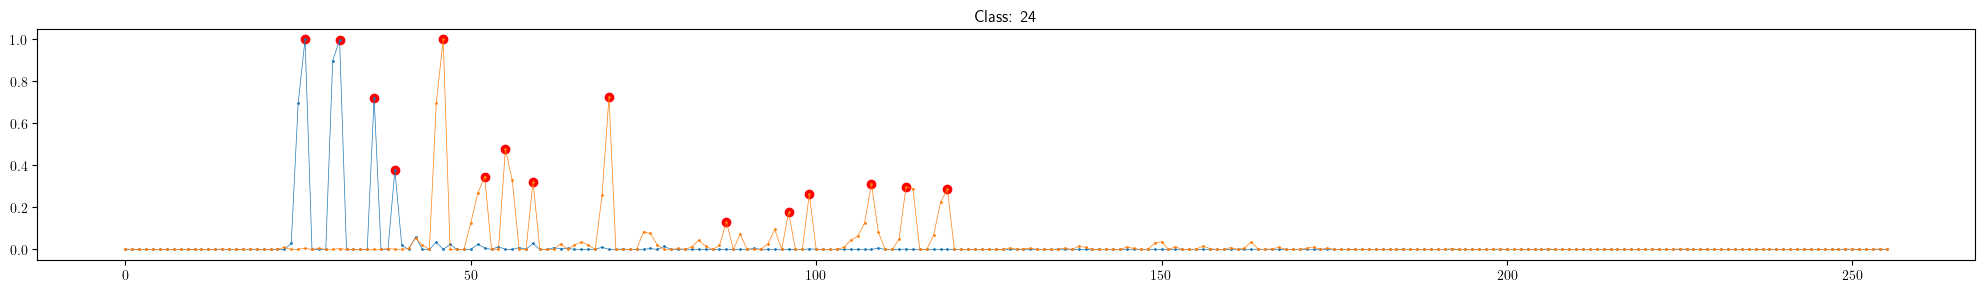

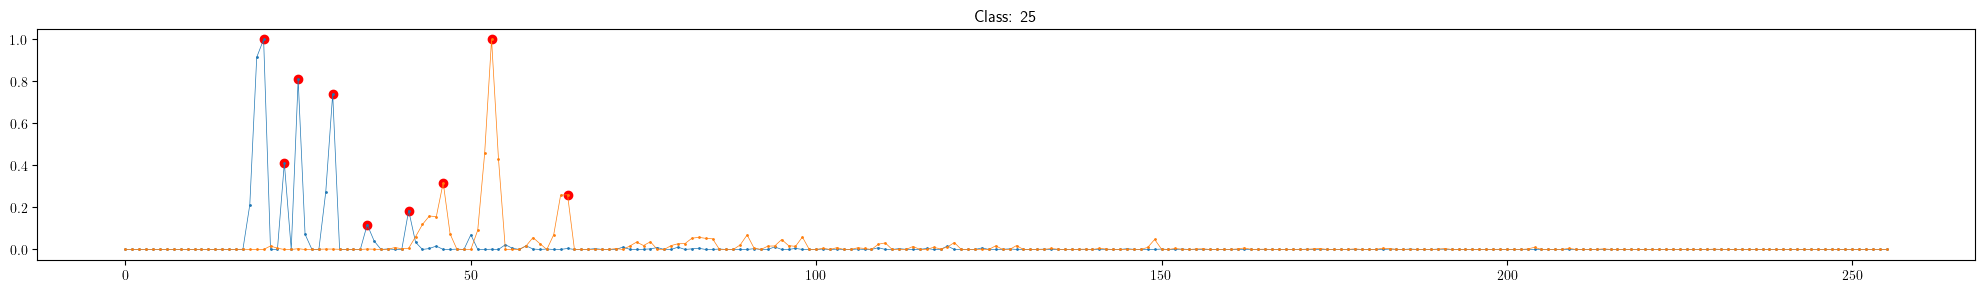

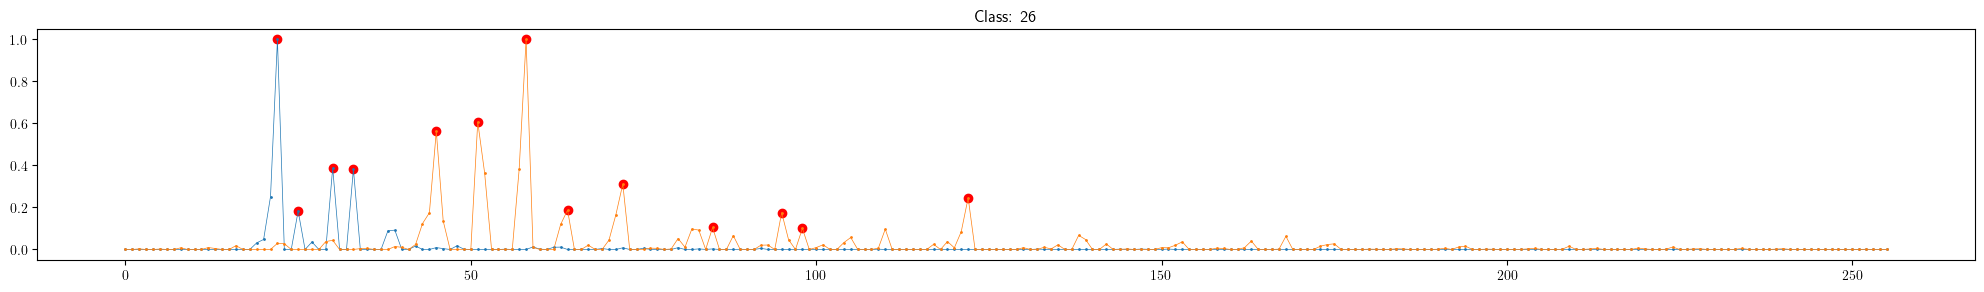

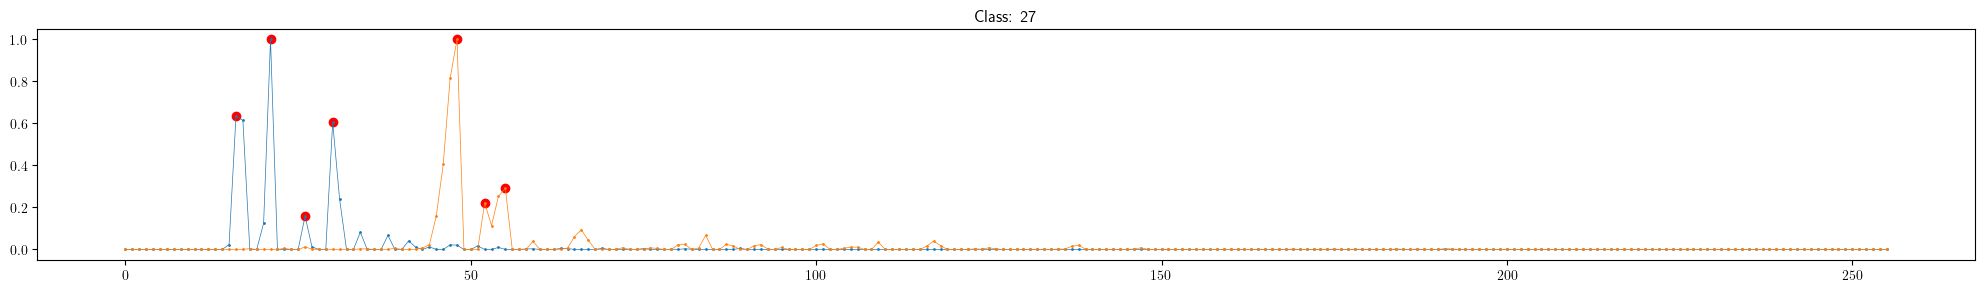

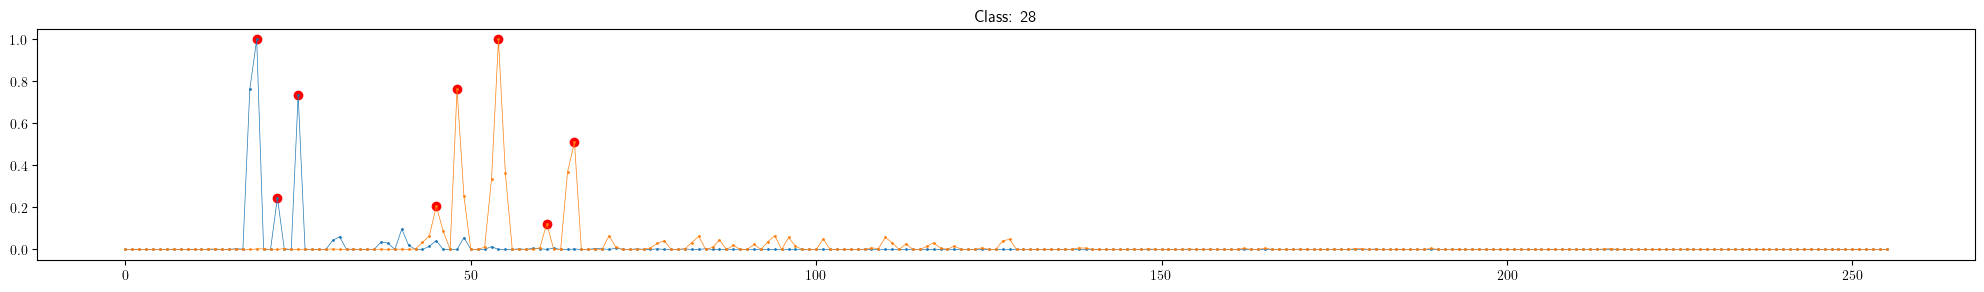

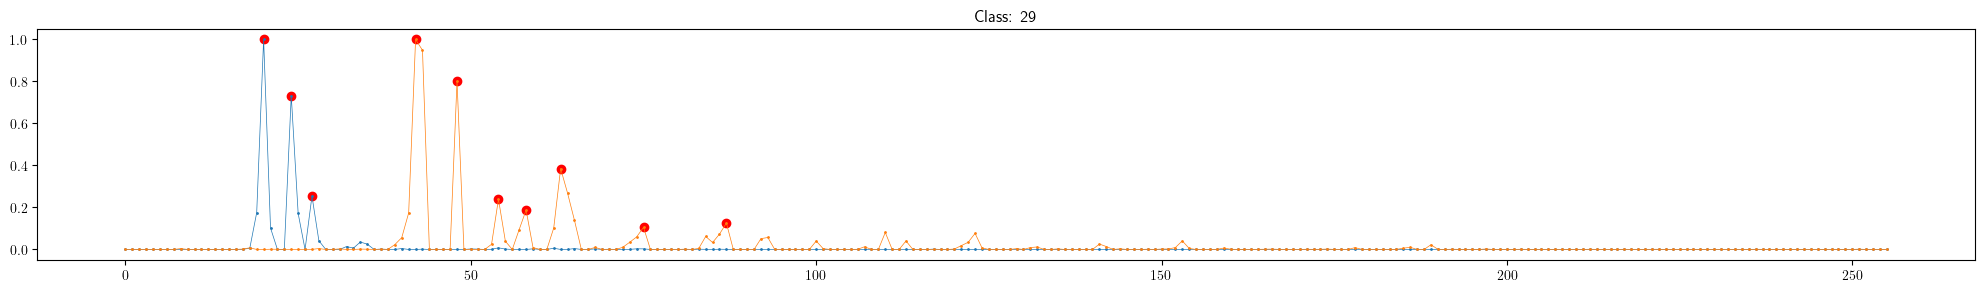

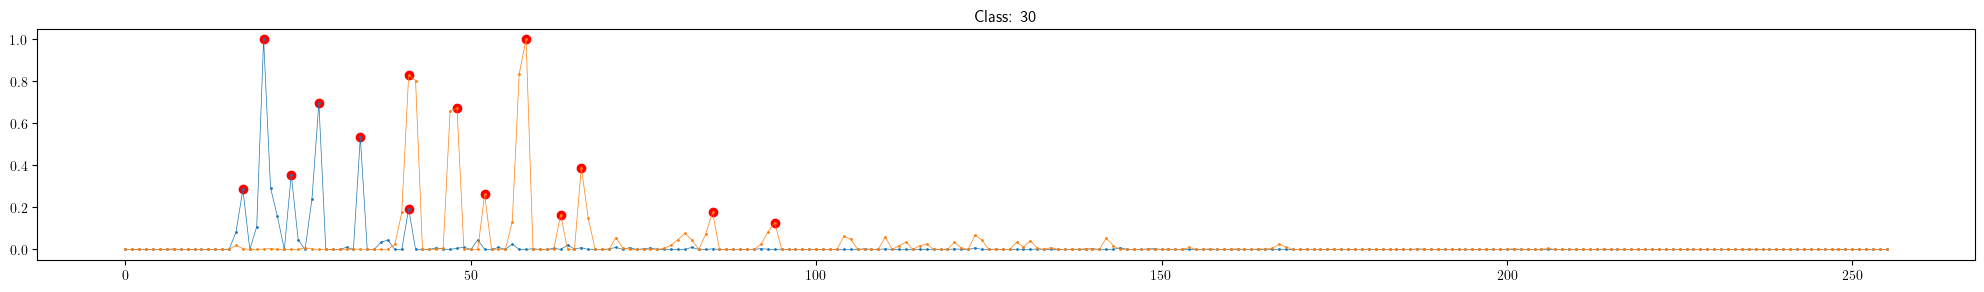

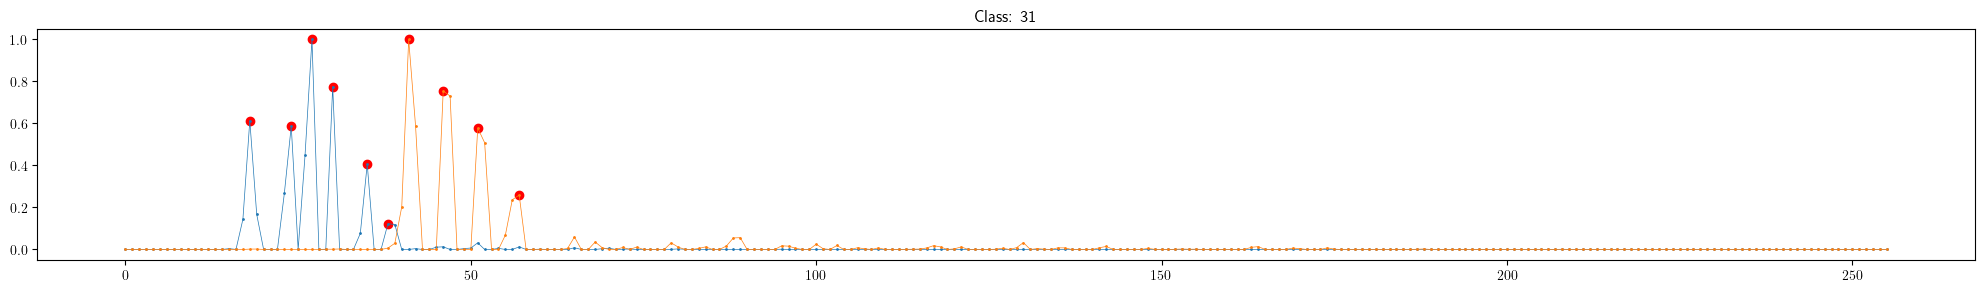

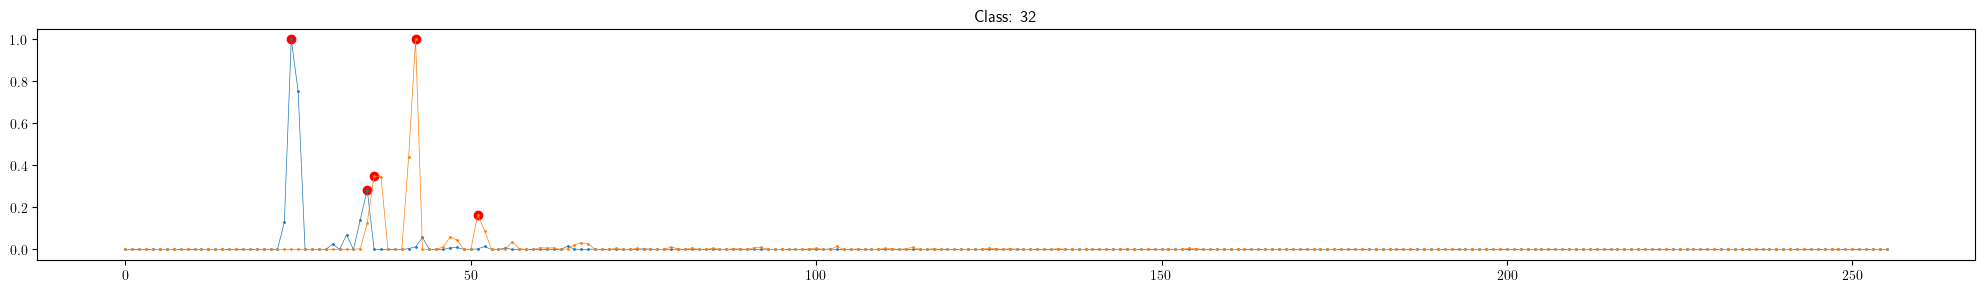

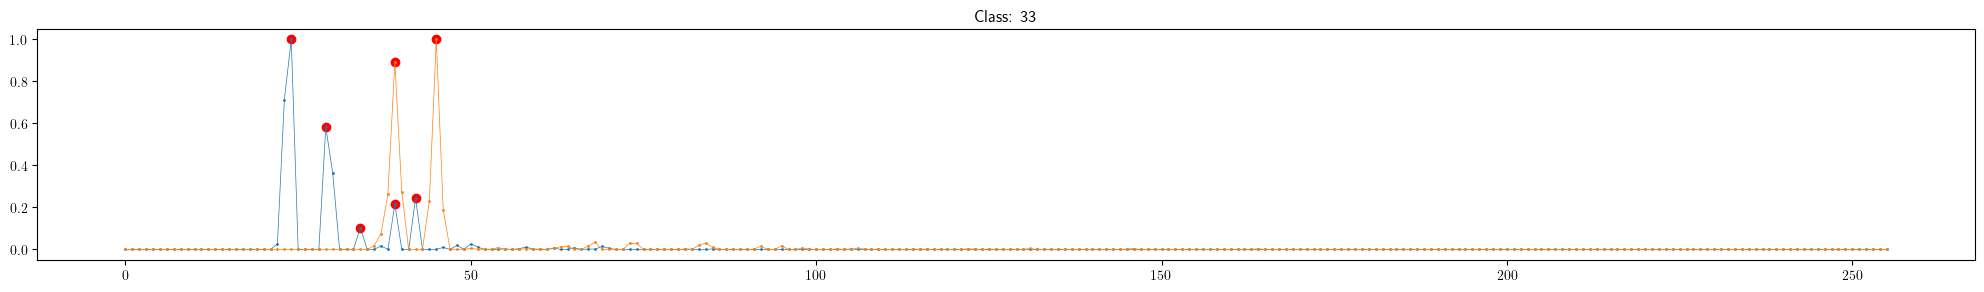

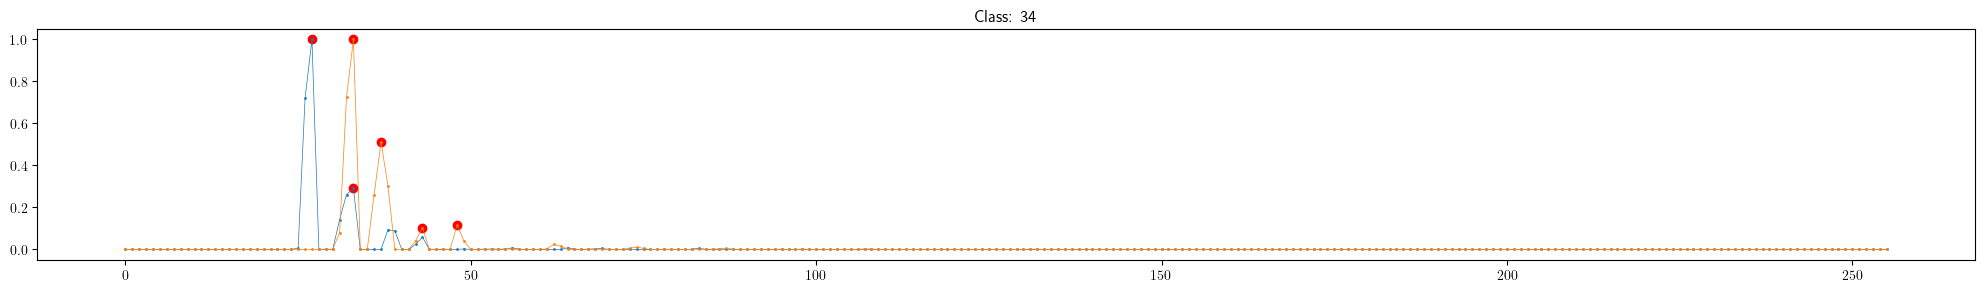

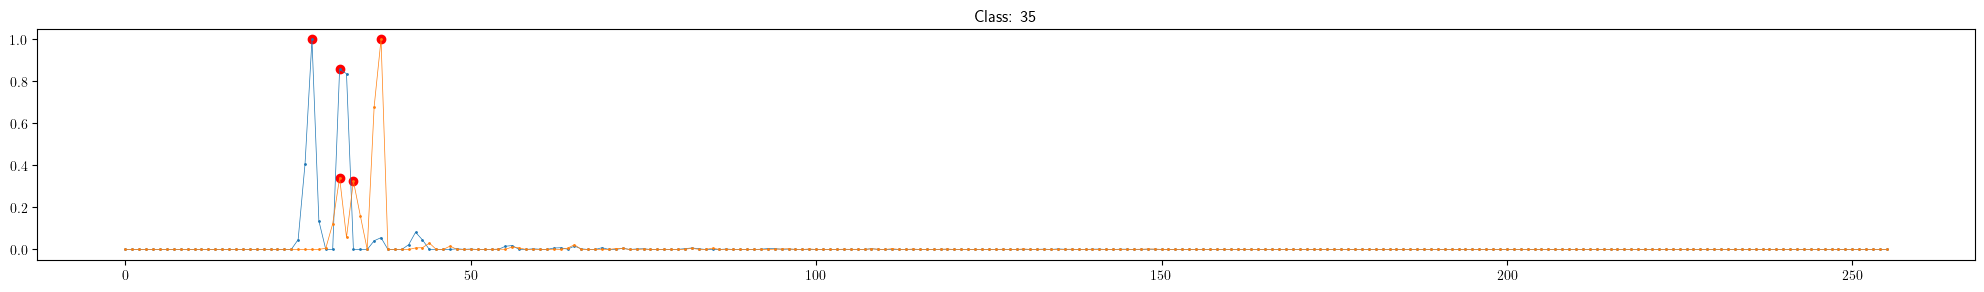

In [60]:
plt.rcParams['figure.max_open_warning'] = 50
peaks_l_0,peaks_r_0 = energy_based_novelty(samples0,denorm=True,N=4,c=NUM_CLASSES, type=1)

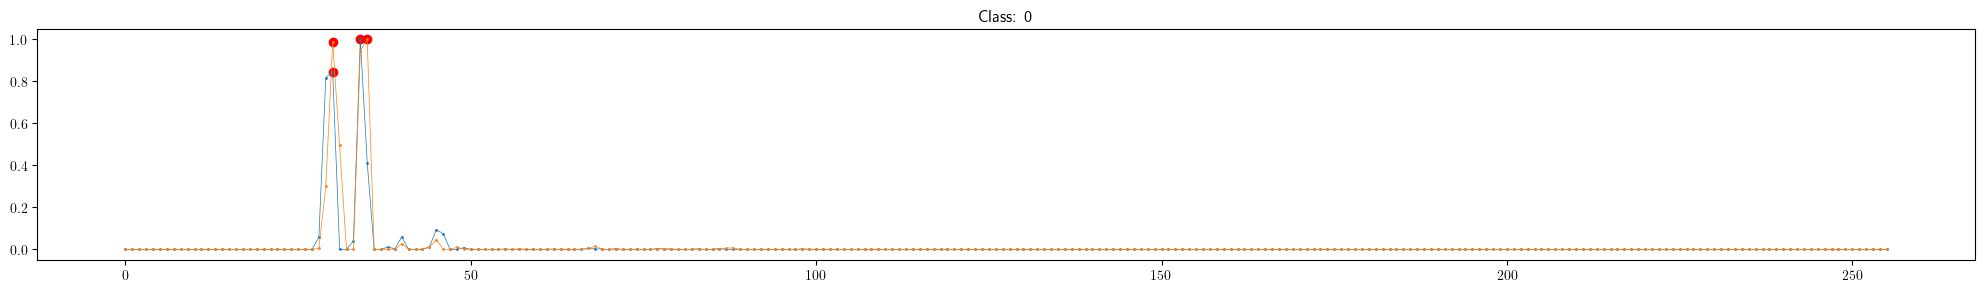

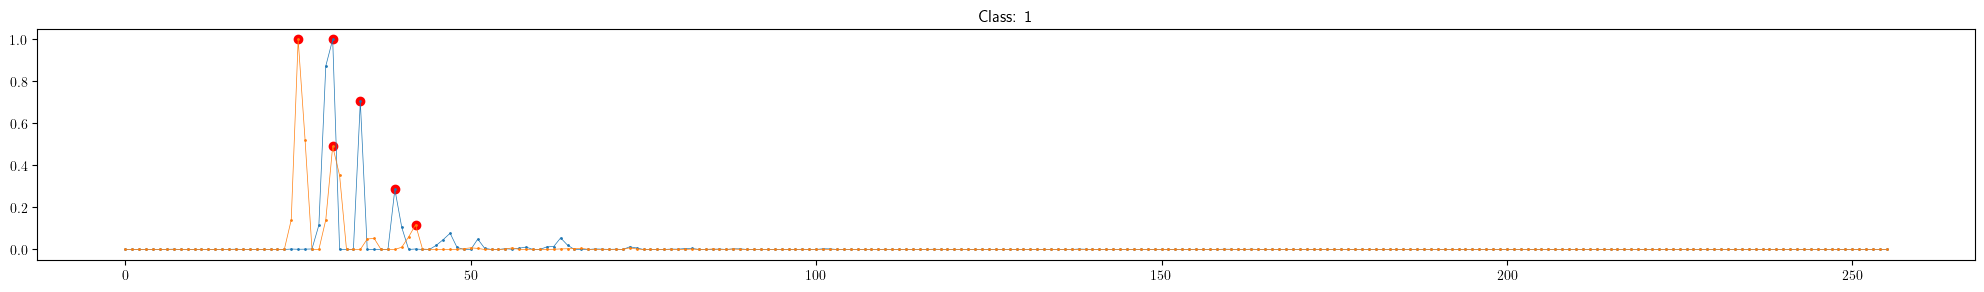

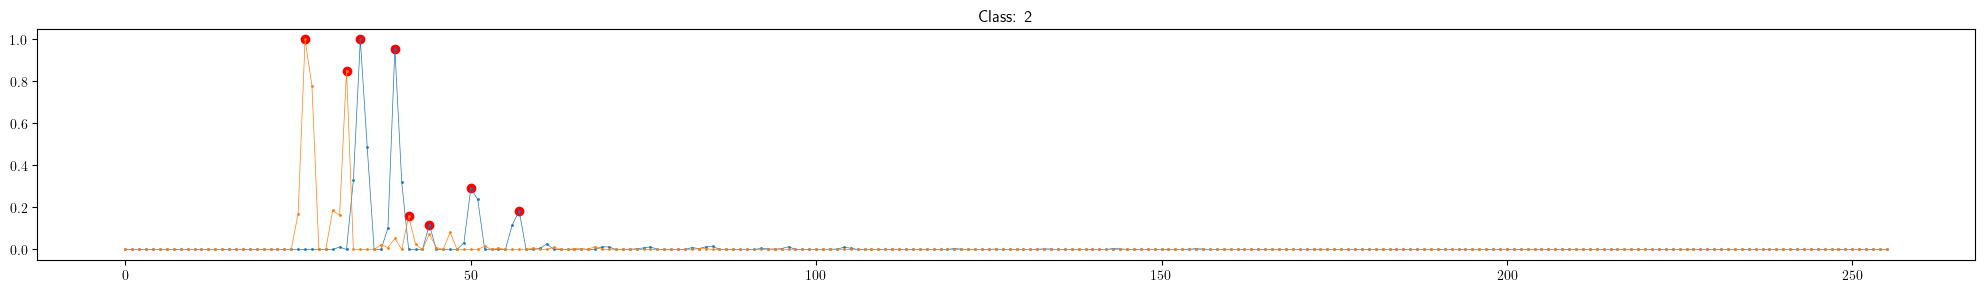

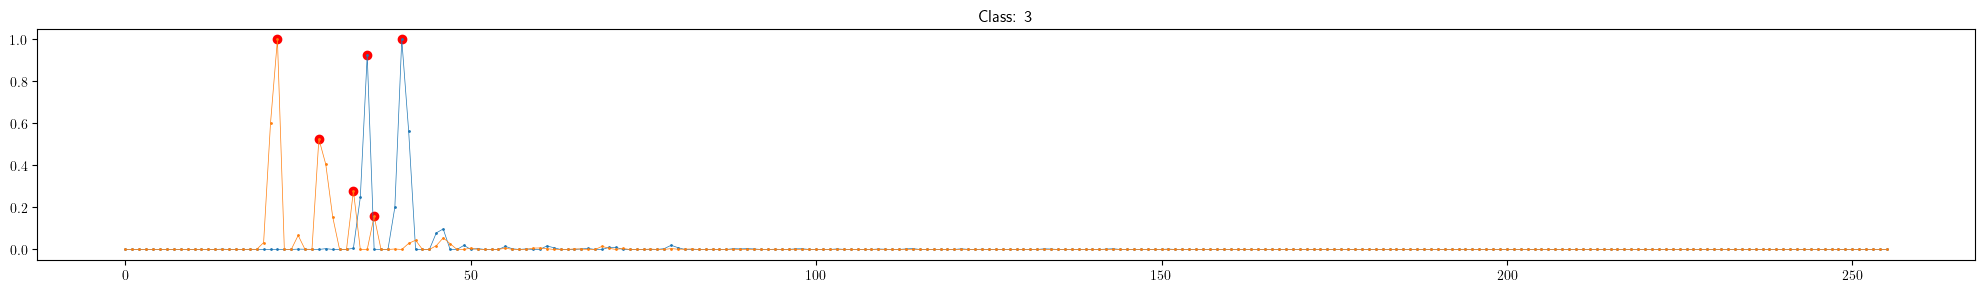

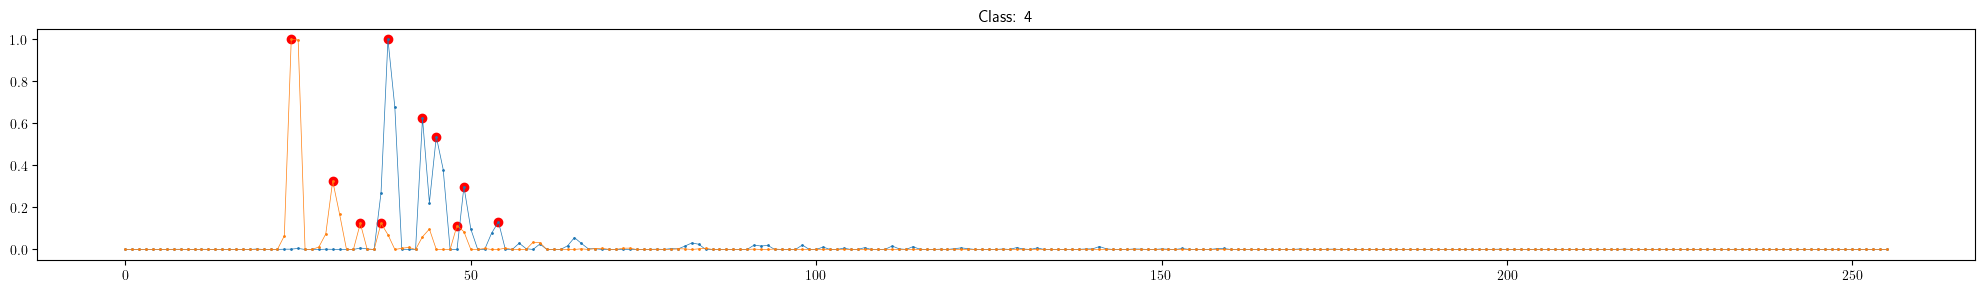

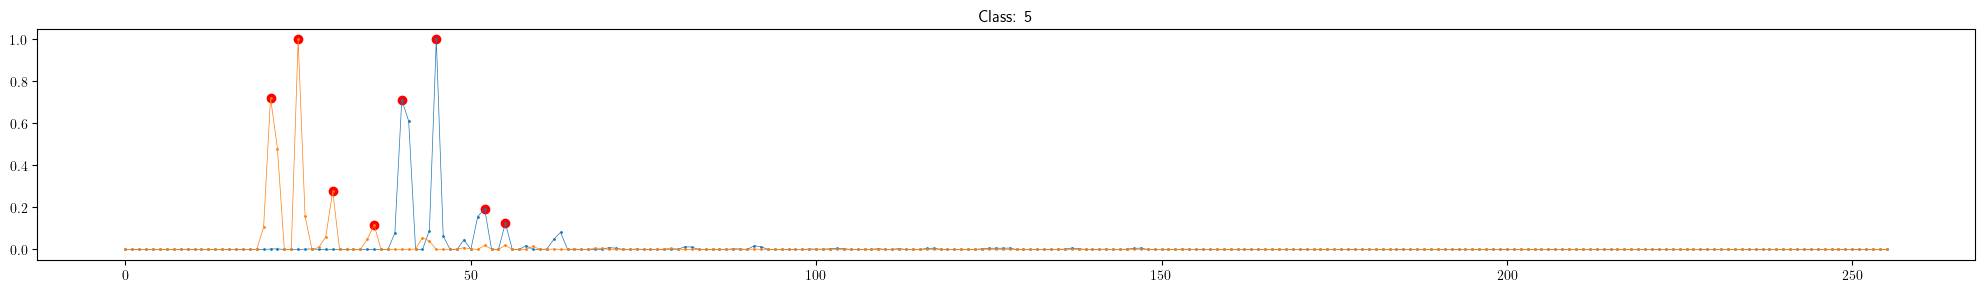

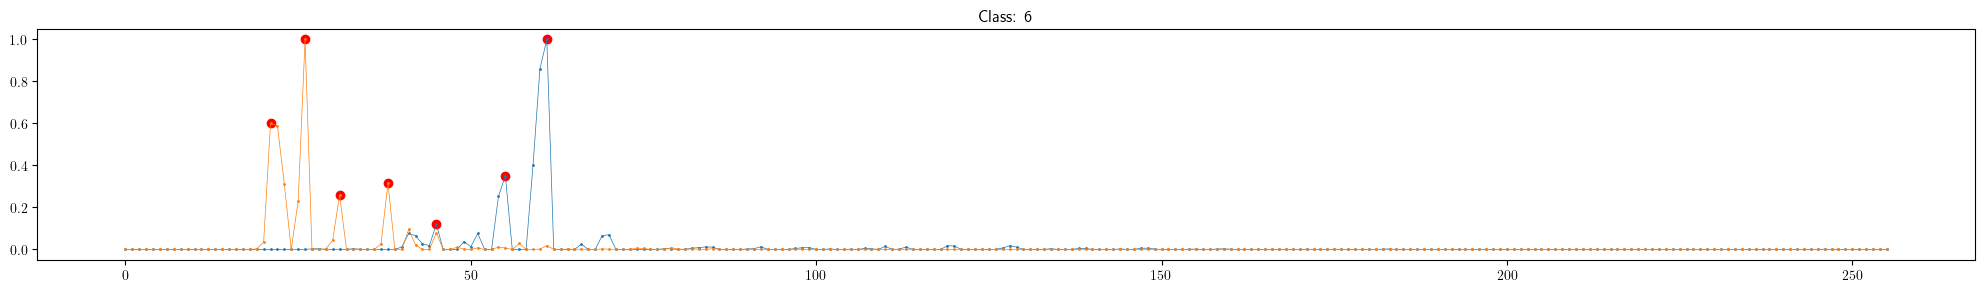

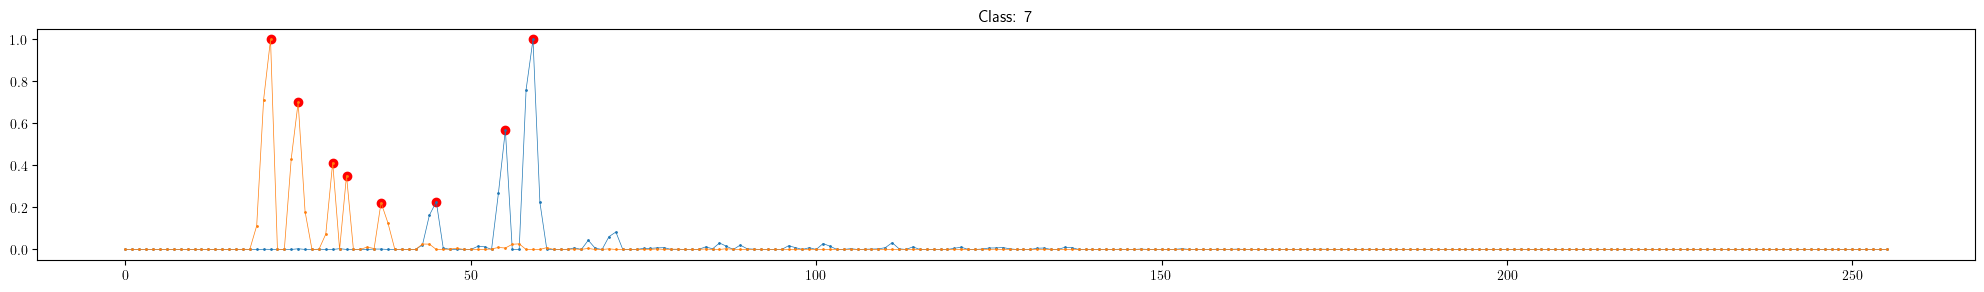

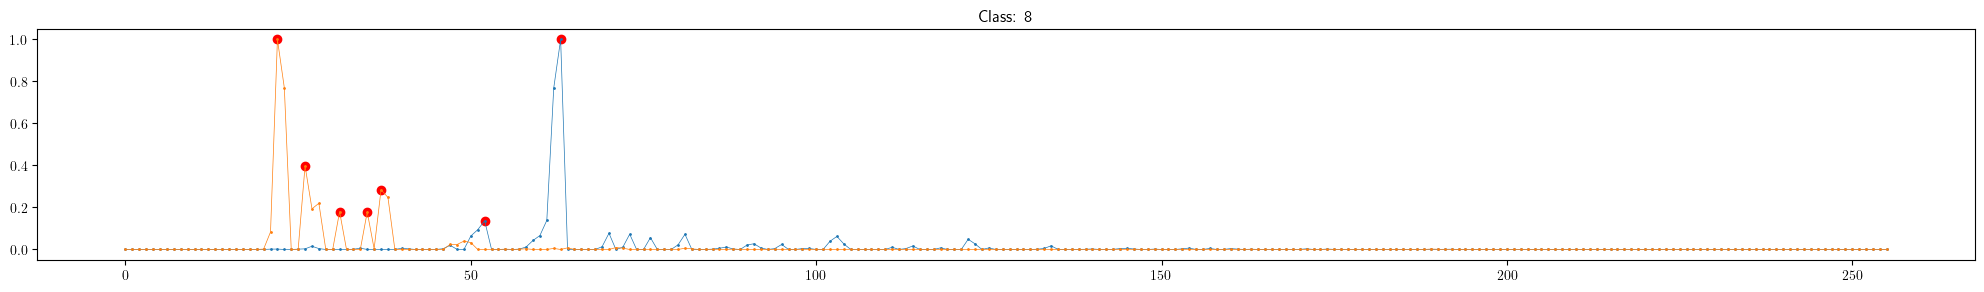

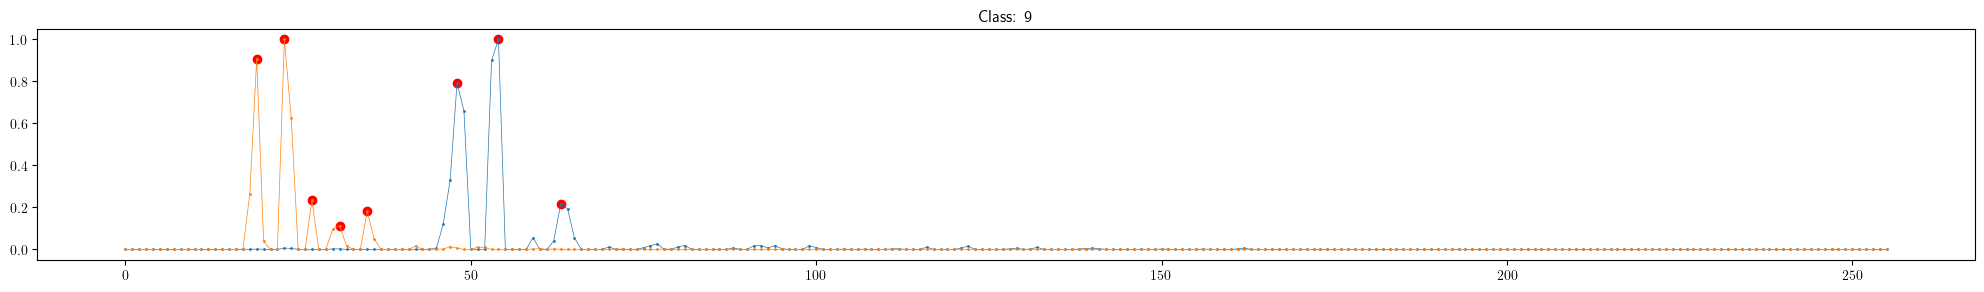

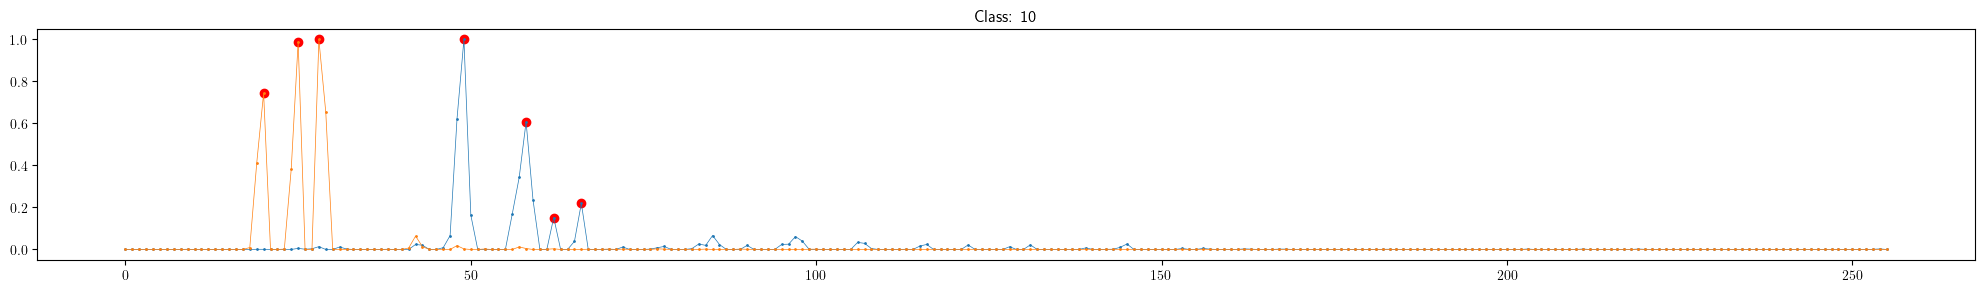

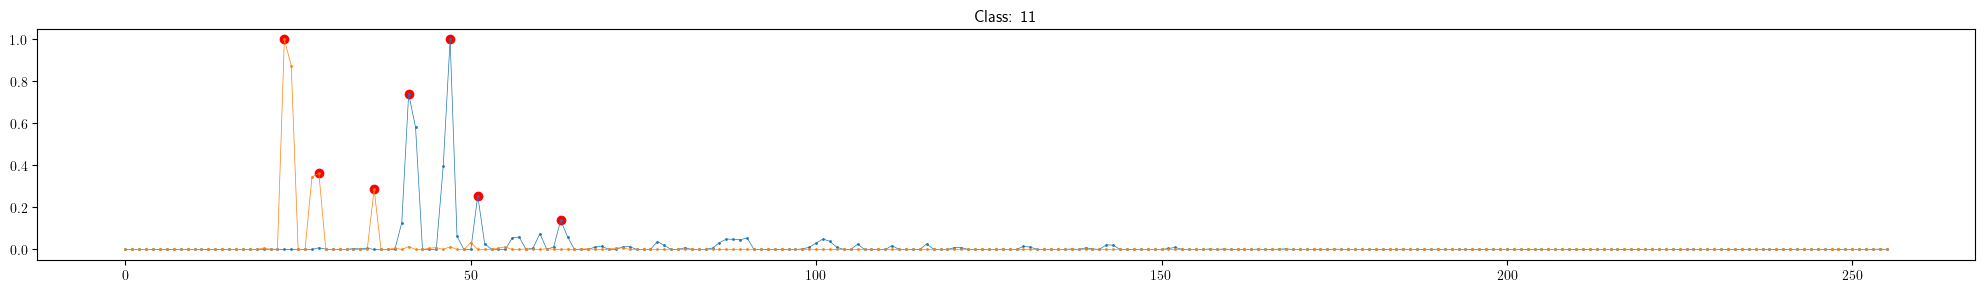

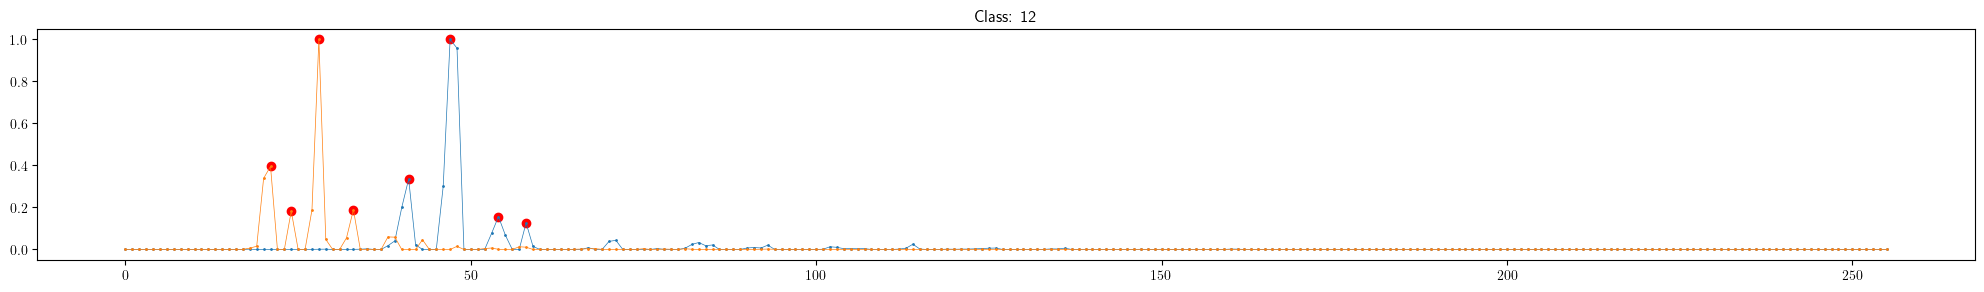

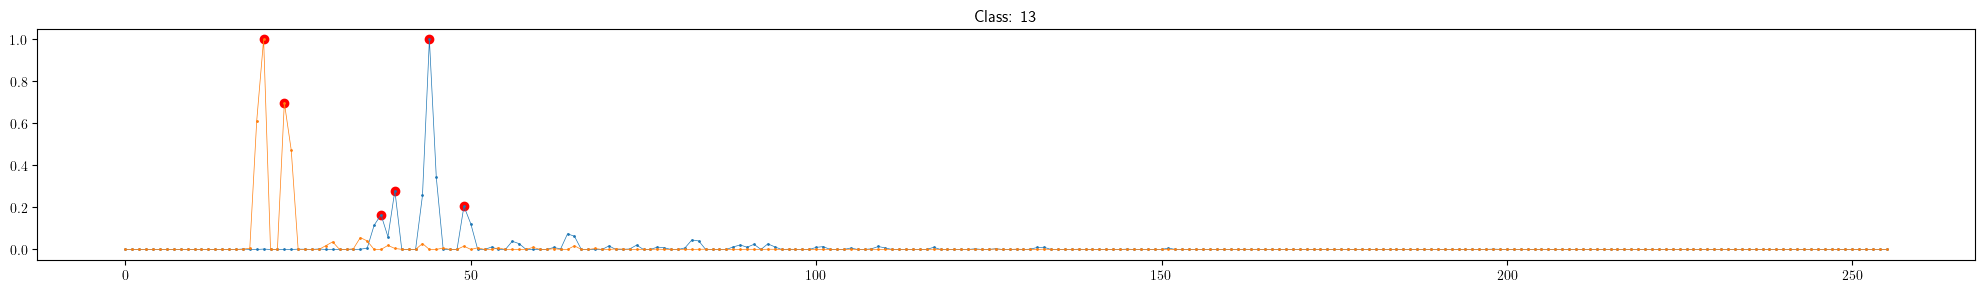

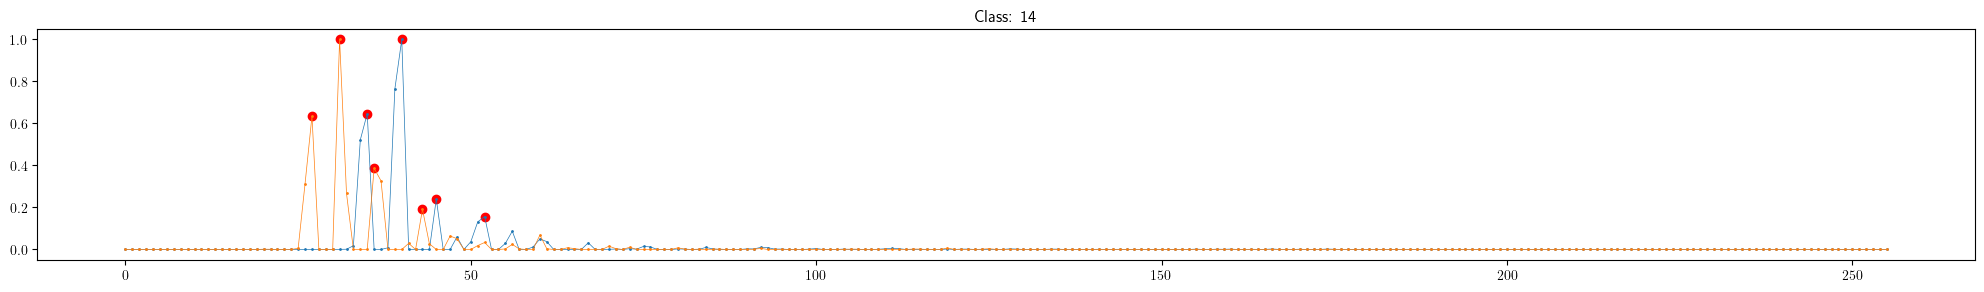

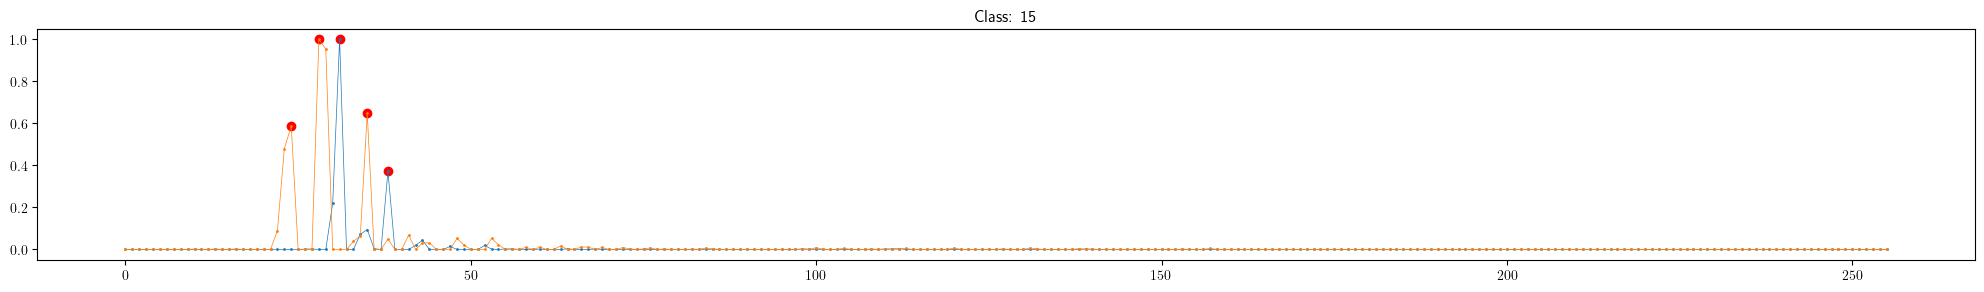

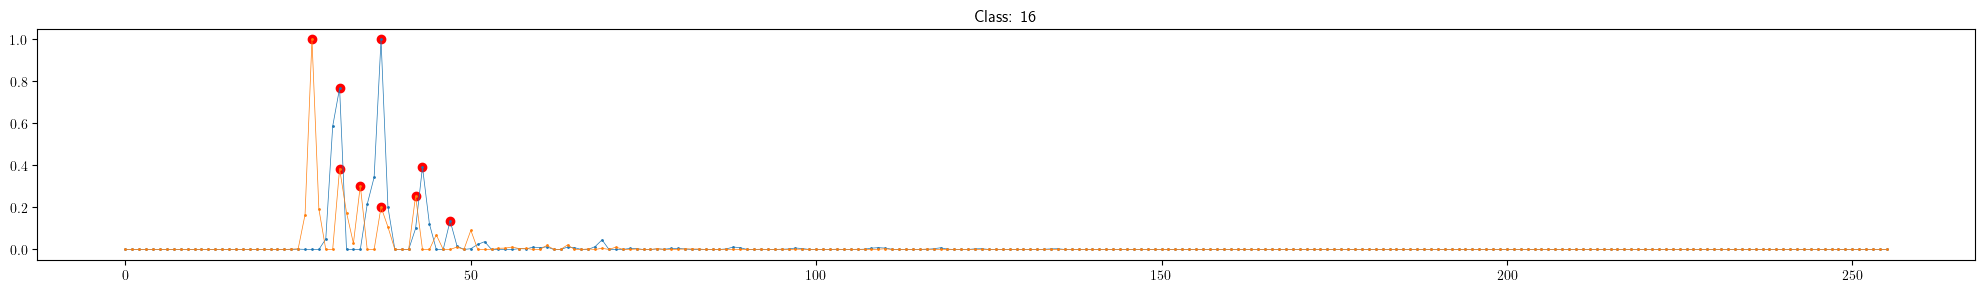

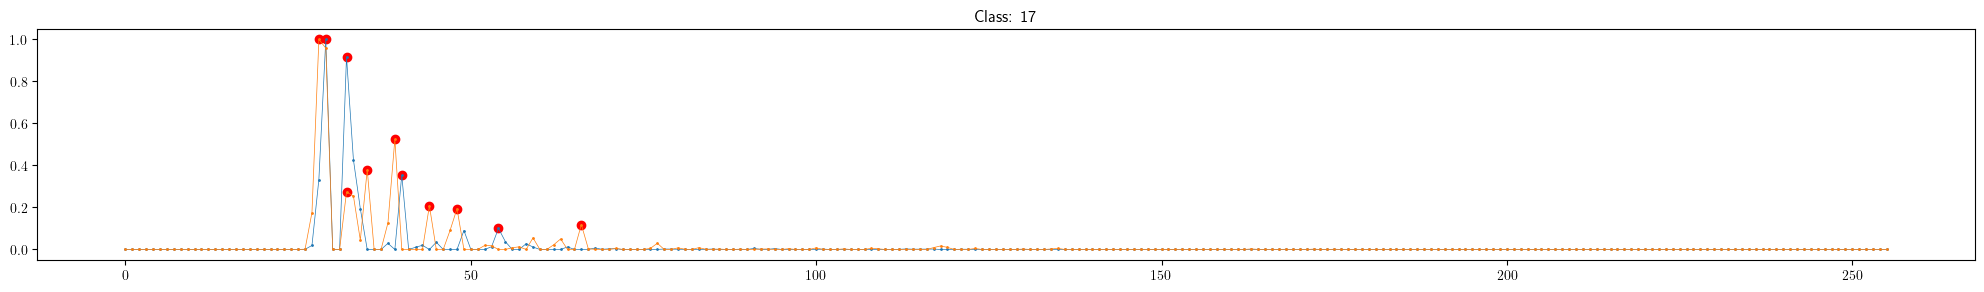

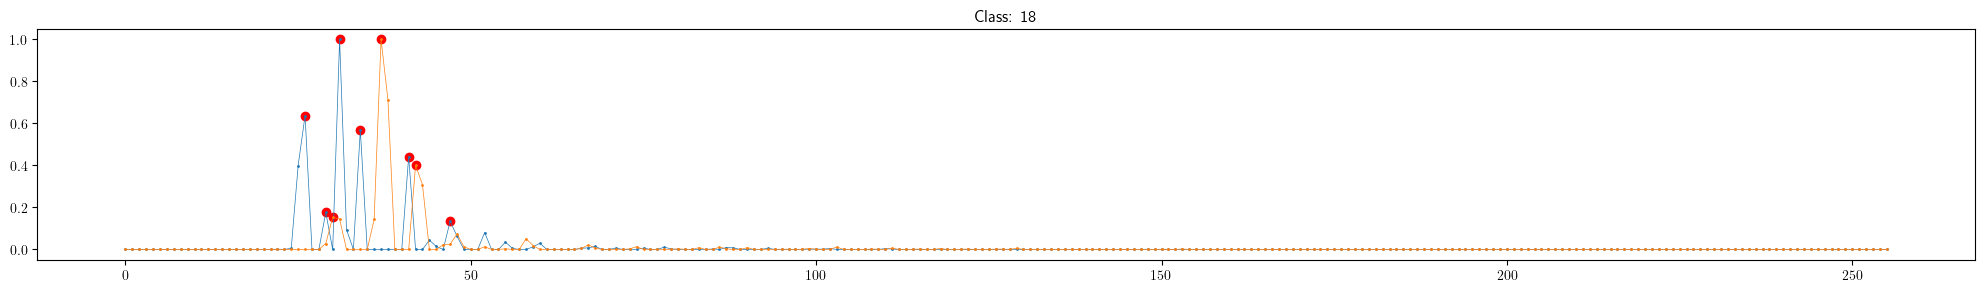

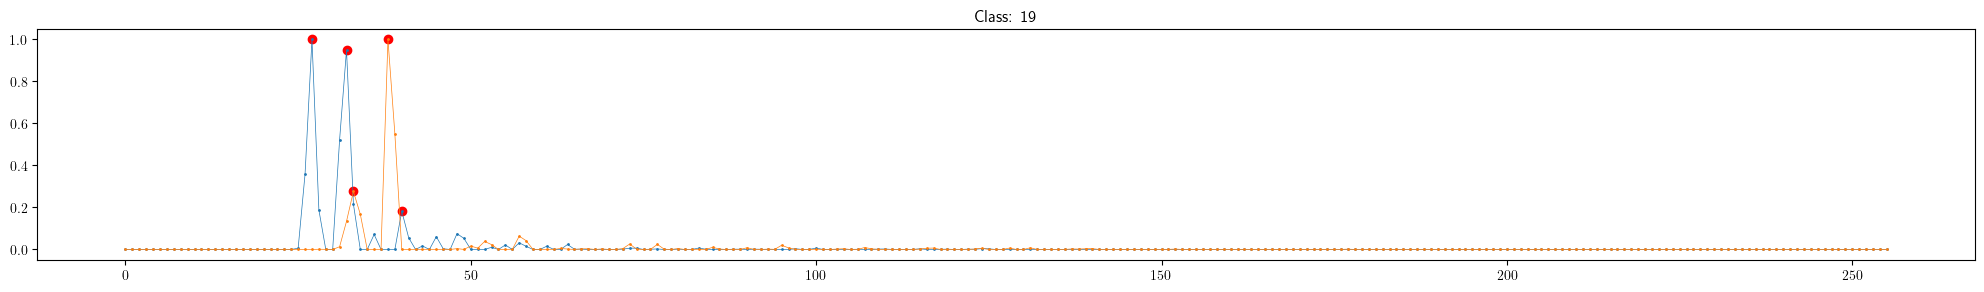

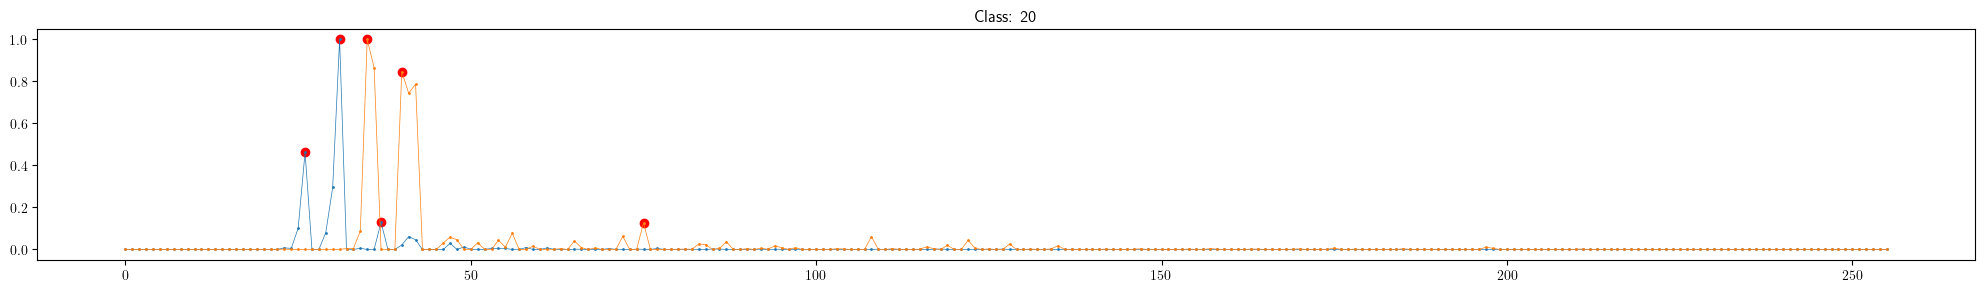

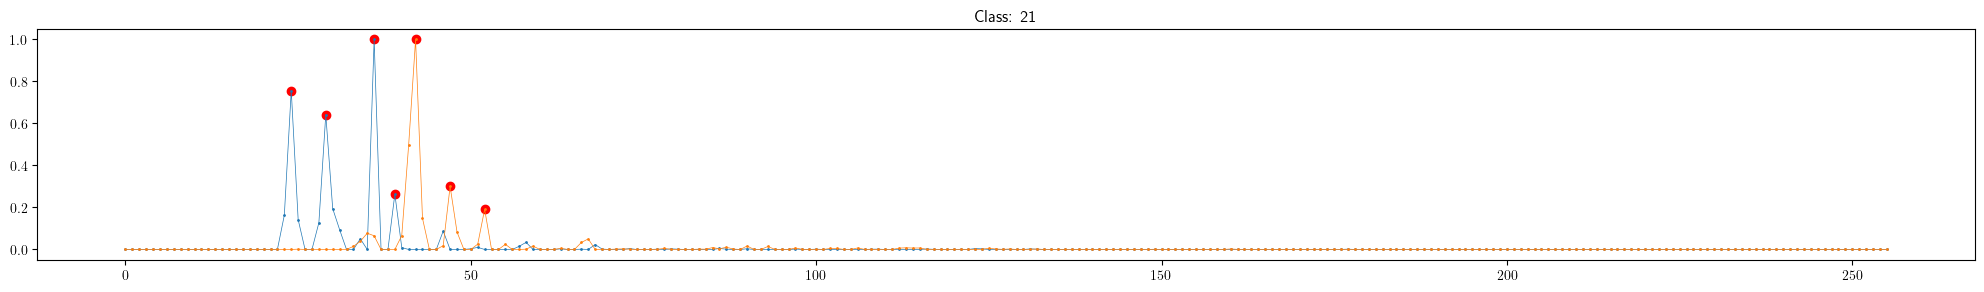

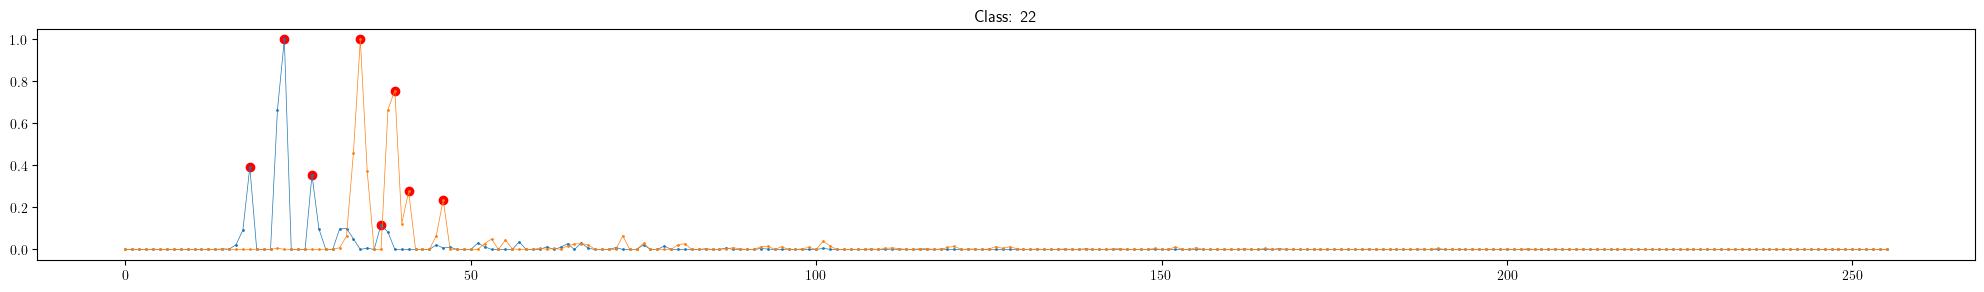

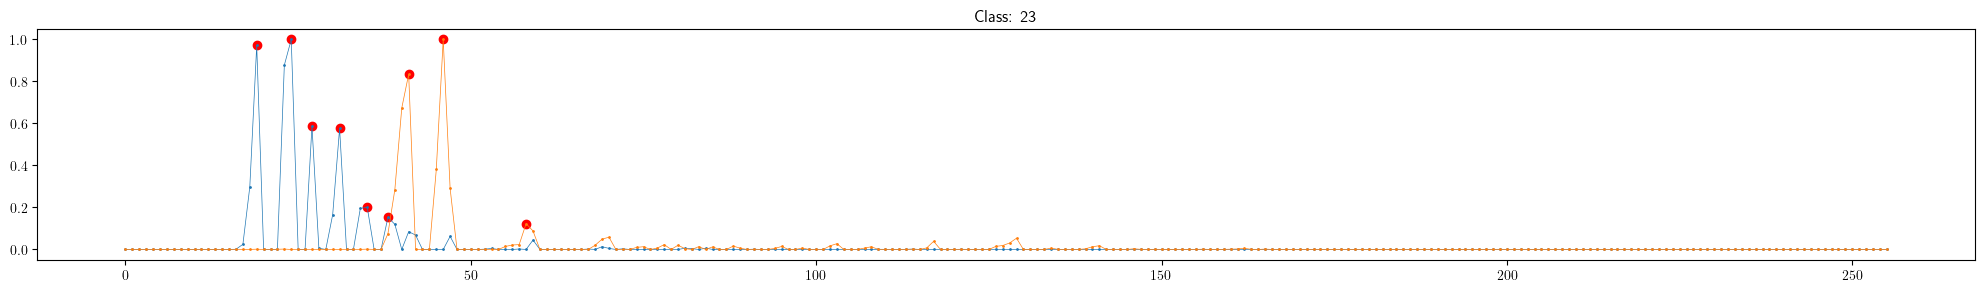

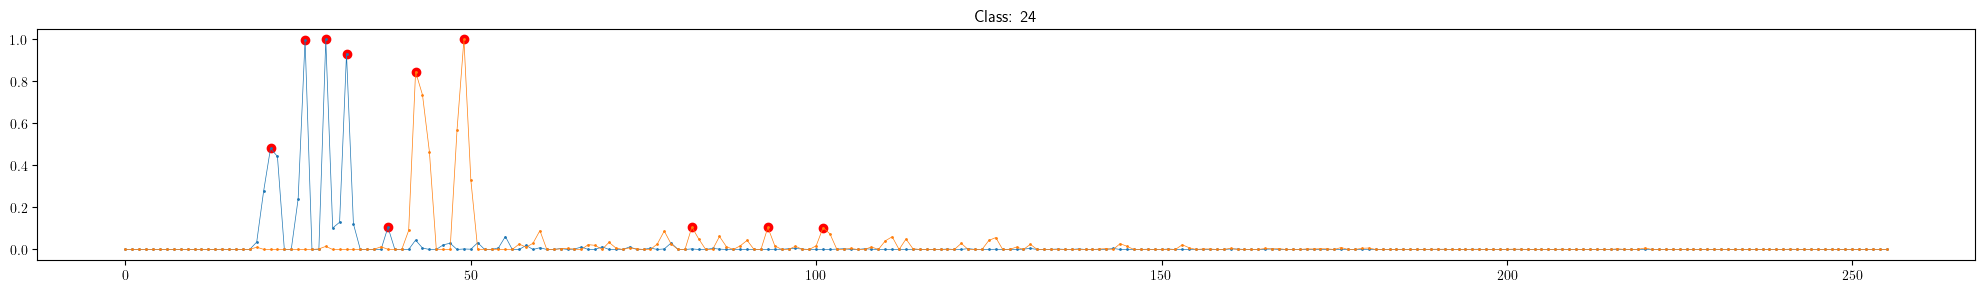

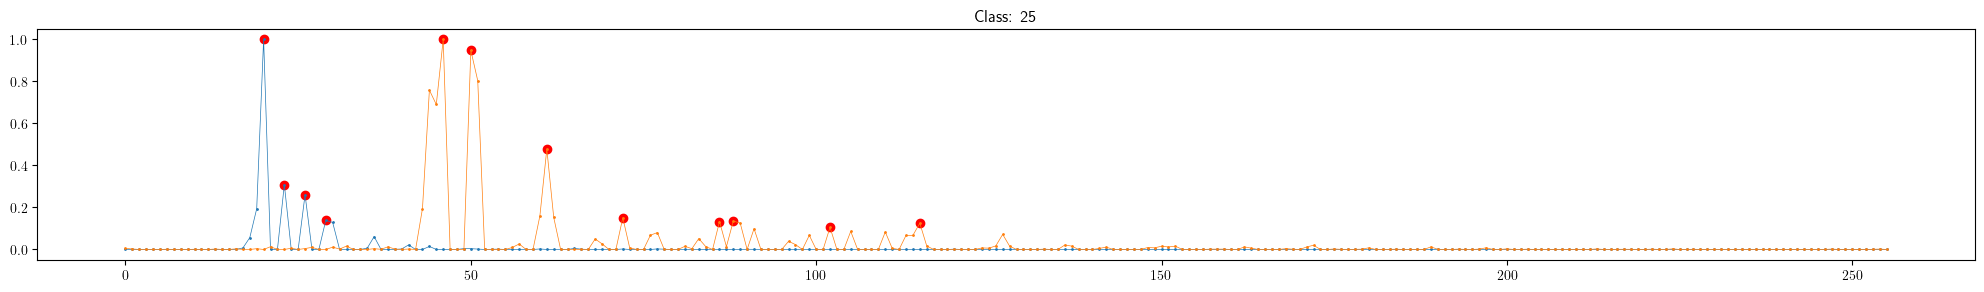

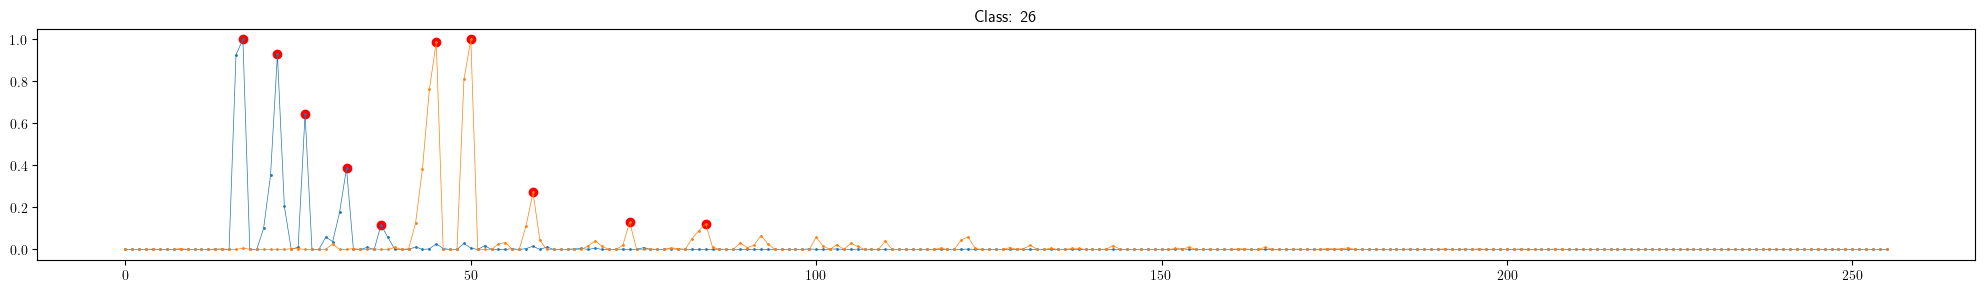

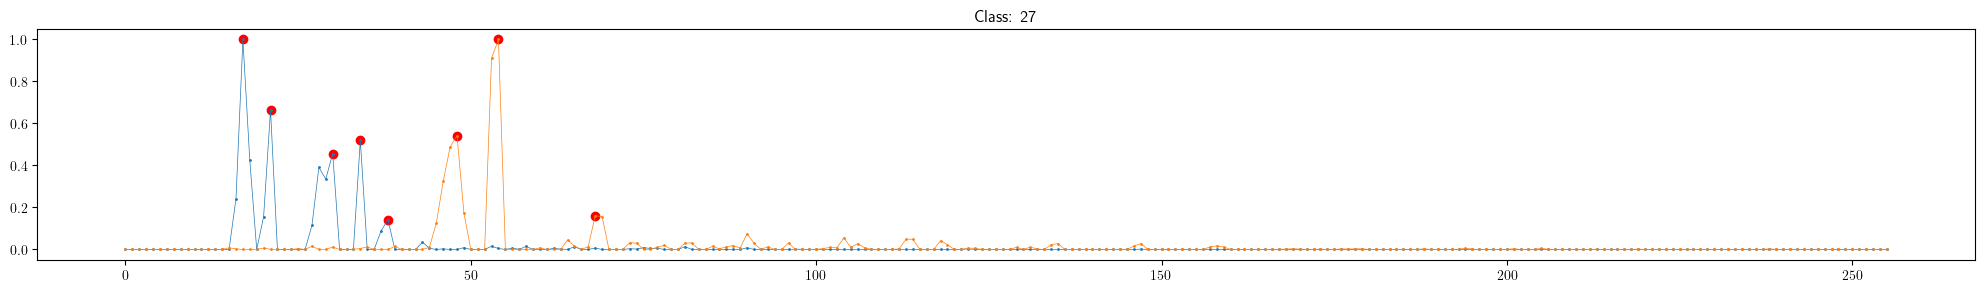

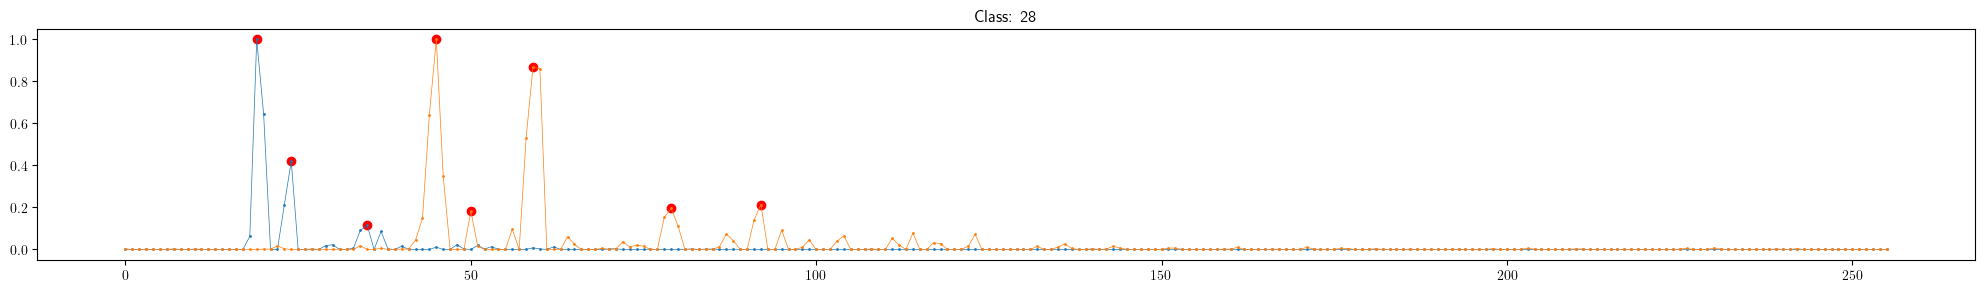

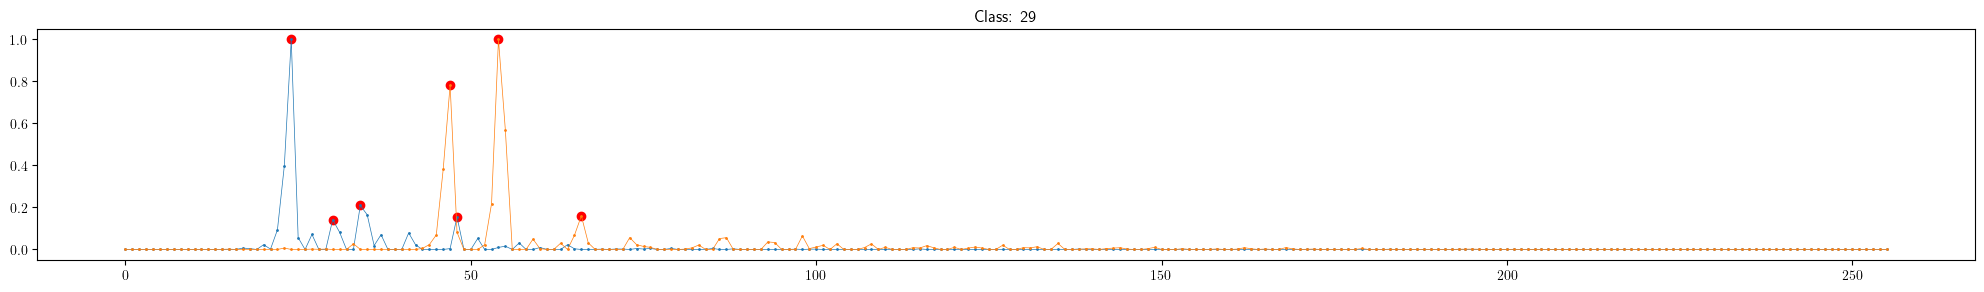

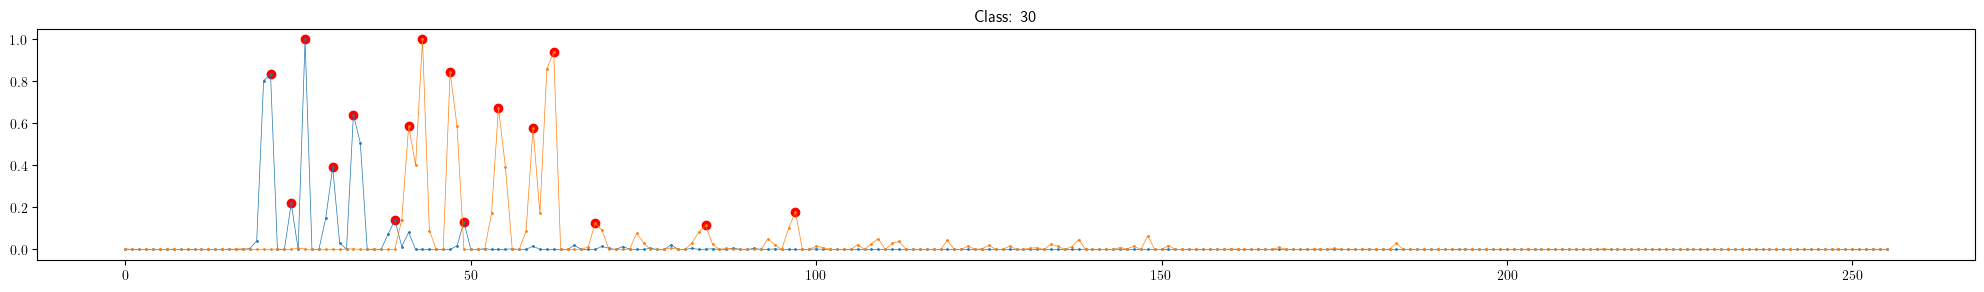

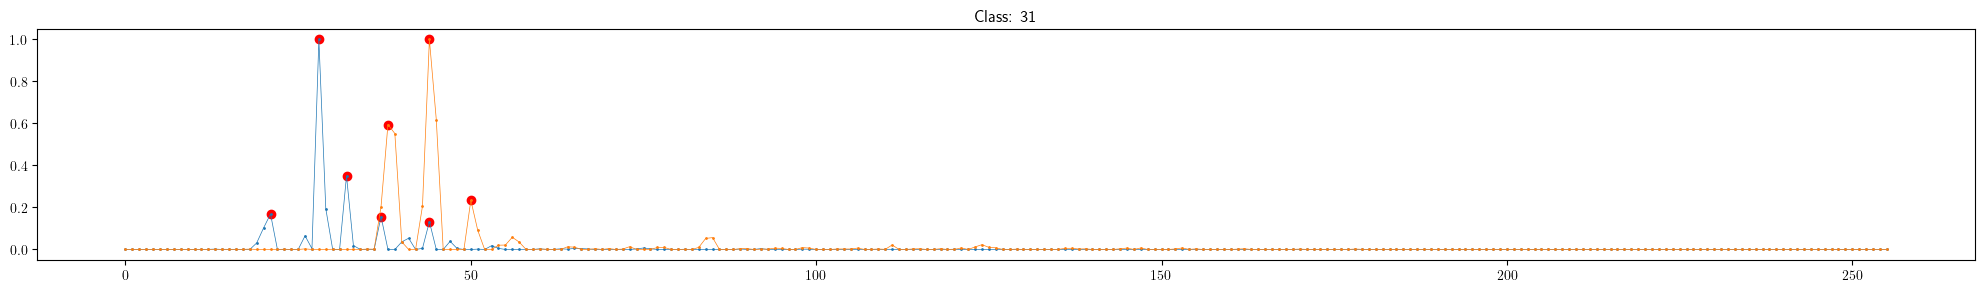

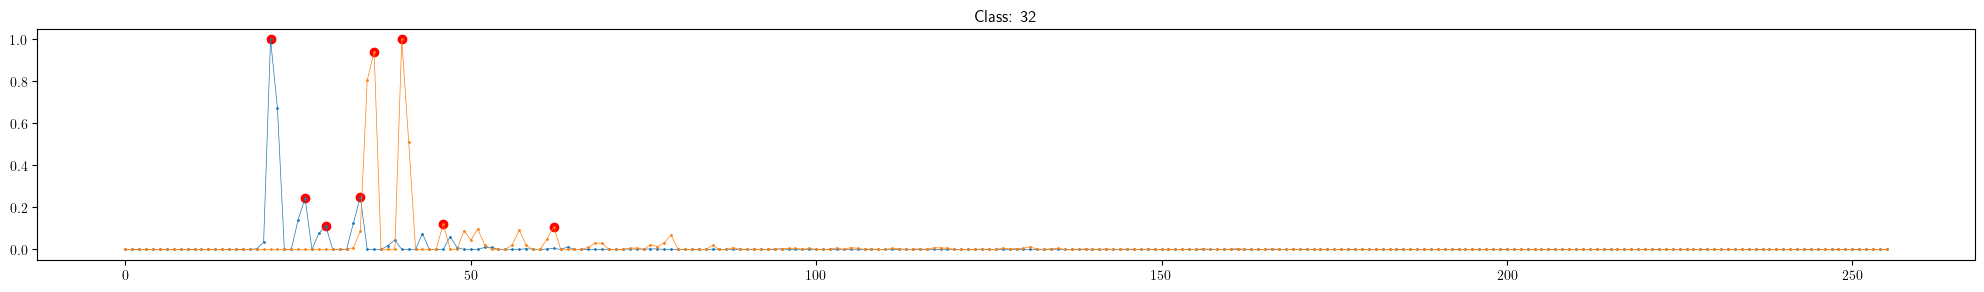

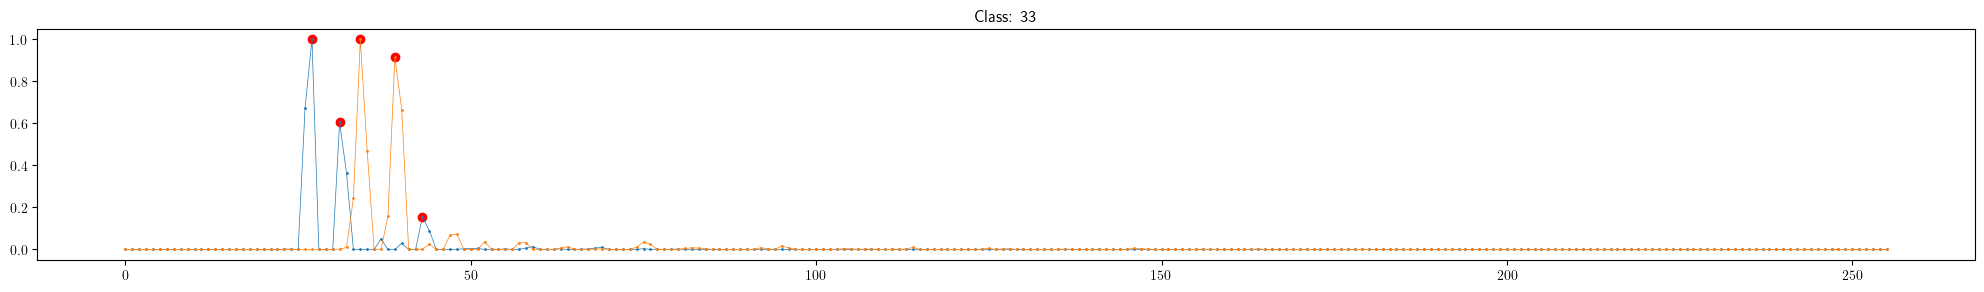

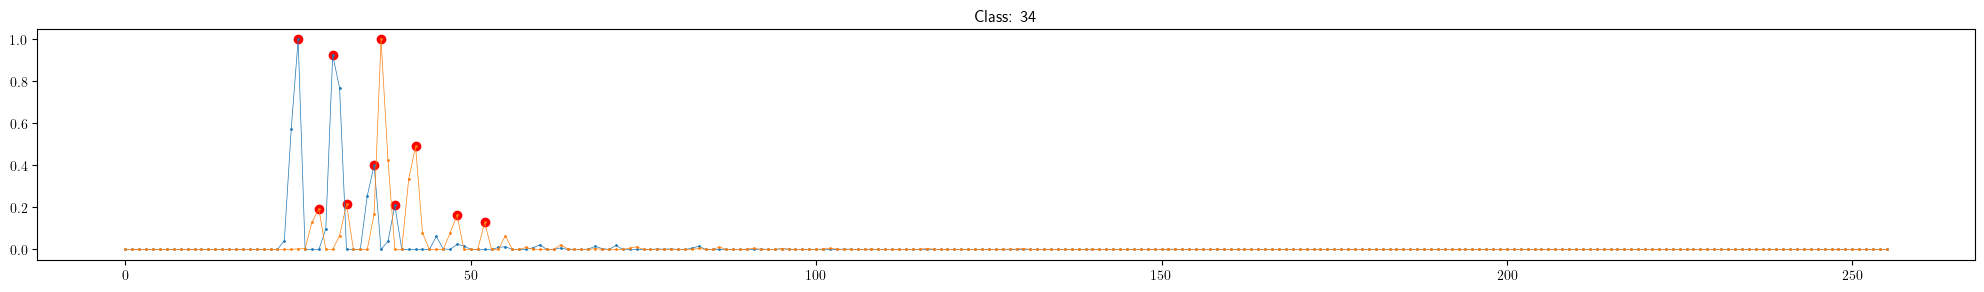

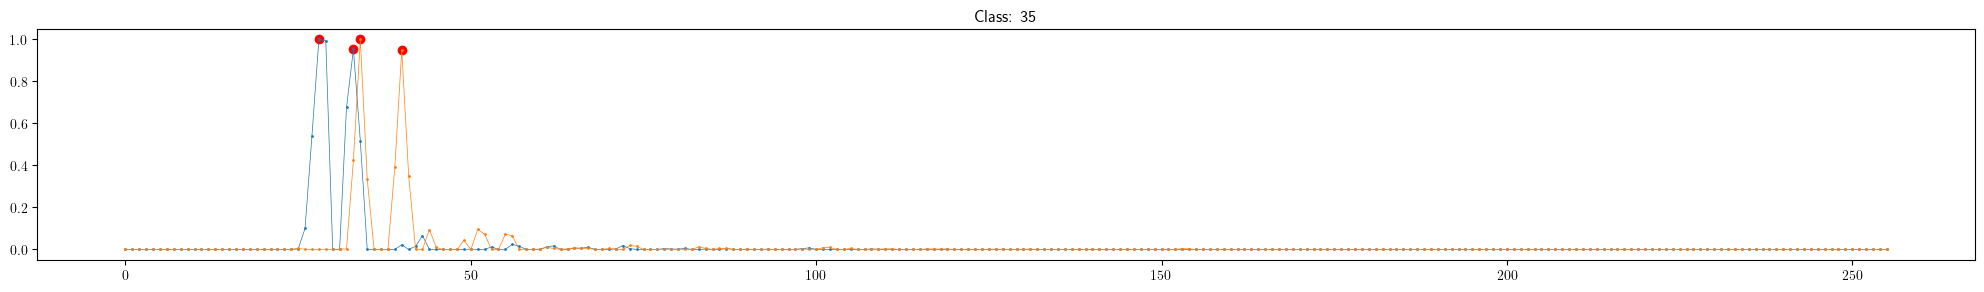

In [61]:
plt.rcParams['figure.max_open_warning'] = 50
peaks_l_3,peaks_r_3 = energy_based_novelty(samples3,denorm=True,N=4,c=NUM_CLASSES, type=1)

In [17]:
head_meas = data['head_measurements'].to(device)
#print(head_meas.shape)
head_enc = HeadMeasureEncoder(head_anthro_dim=13,head_emb_dim=1).to(device)
#print(head_enc)
head_encoded = head_enc(head_meas)
print(head_encoded)

tensor([[ 0.7731],
        [ 0.8739],
        [ 0.7898],
        [ 0.8621],
        [ 0.8611],
        [ 0.8006],
        [ 0.7917],
        [ 0.8029],
        [ 0.7809],
        [ 0.7917],
        [ 0.7925],
        [ 0.8793],
        [ 0.7761],
        [ 0.8533],
        [ 0.7982],
        [ 0.8006],
        [ 0.7697],
        [ 0.8029],
        [ 0.8063],
        [ 0.7954],
        [ 0.7377],
        [ 0.7752],
        [ 0.8739],
        [ 0.8611],
        [ 0.8447],
        [ 0.7752],
        [ 0.8006],
        [ 0.9361],
        [ 0.8317],
        [ 0.6117],
        [ 0.8751],
        [ 0.8112],
        [ 0.8419],
        [ 0.8029],
        [ 0.7377],
        [ 0.8533],
        [ 0.7787],
        [ 0.7064],
        [ 0.7558],
        [ 0.8611],
        [ 0.8112],
        [ 0.8682],
        [ 0.8431],
        [ 0.8751],
        [ 0.7916],
        [ 0.7917],
        [ 0.7954],
        [ 0.7809],
        [ 0.7549],
        [ 0.7954],
        [ 0.8026],
        [ 0.7170],
        [ 0.

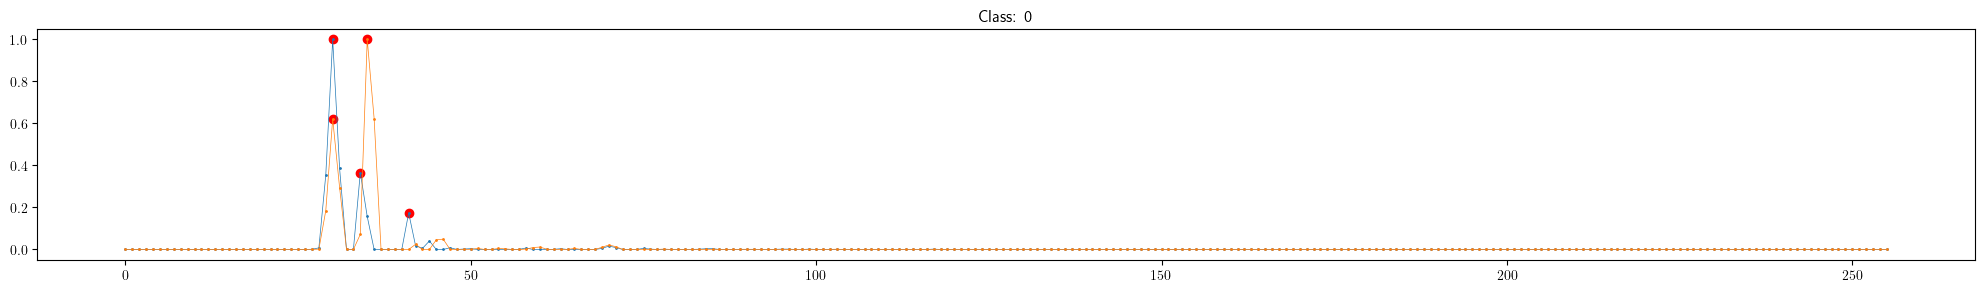

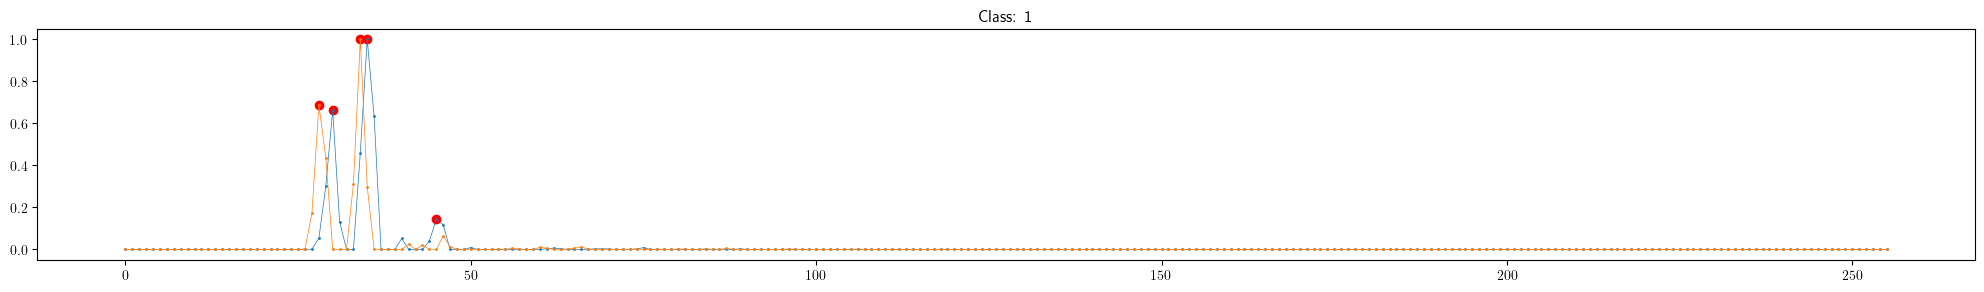

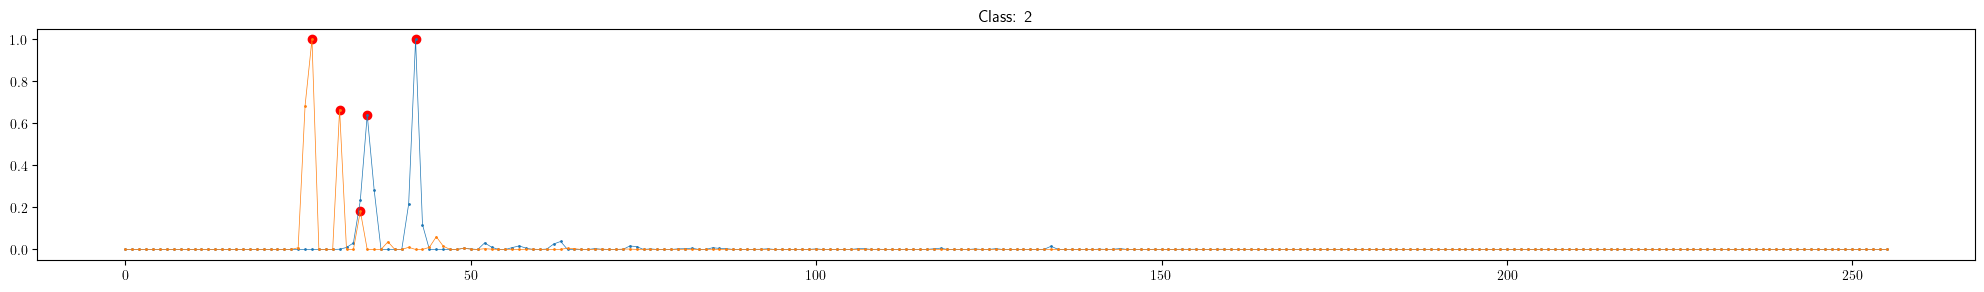

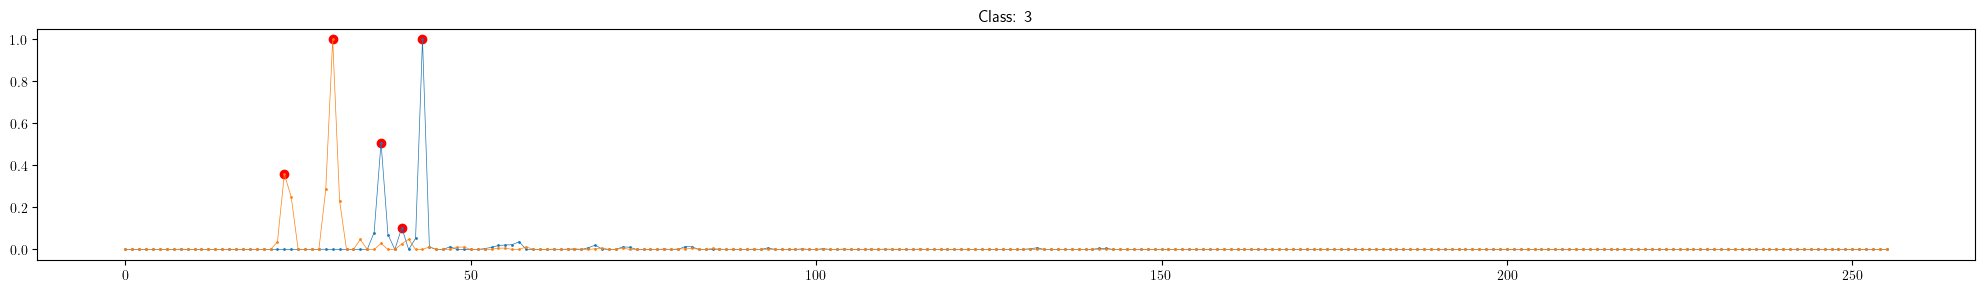

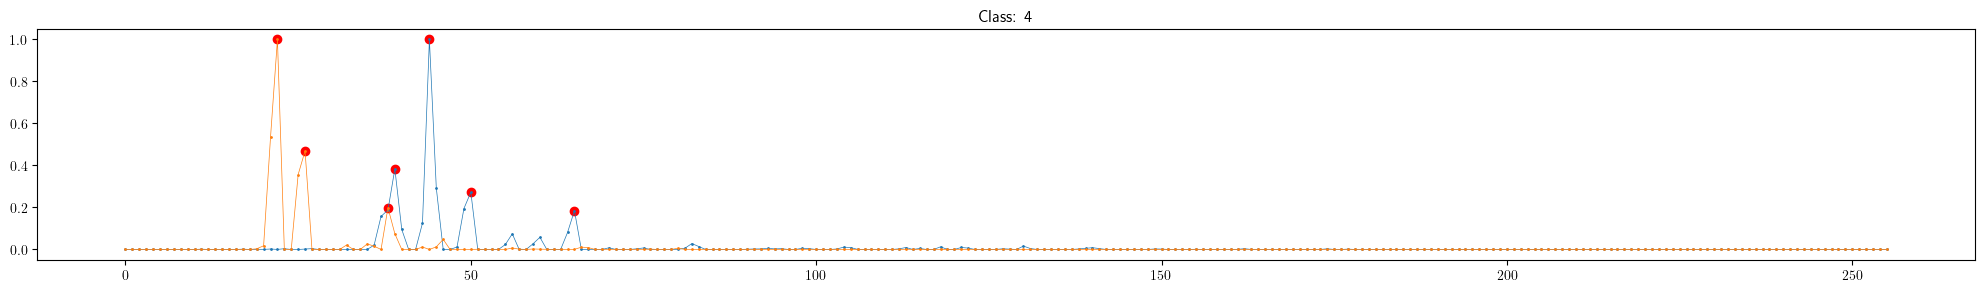

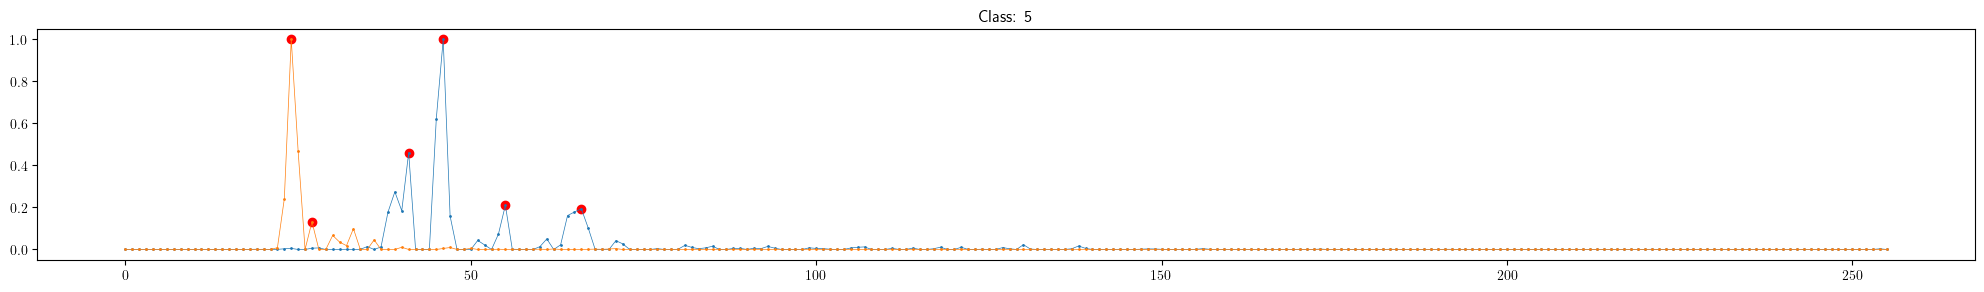

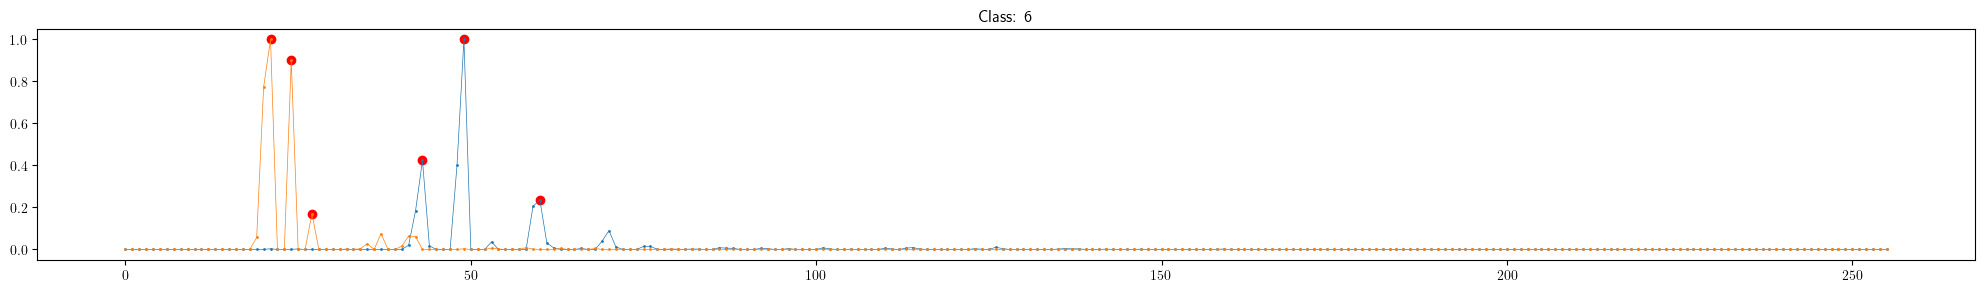

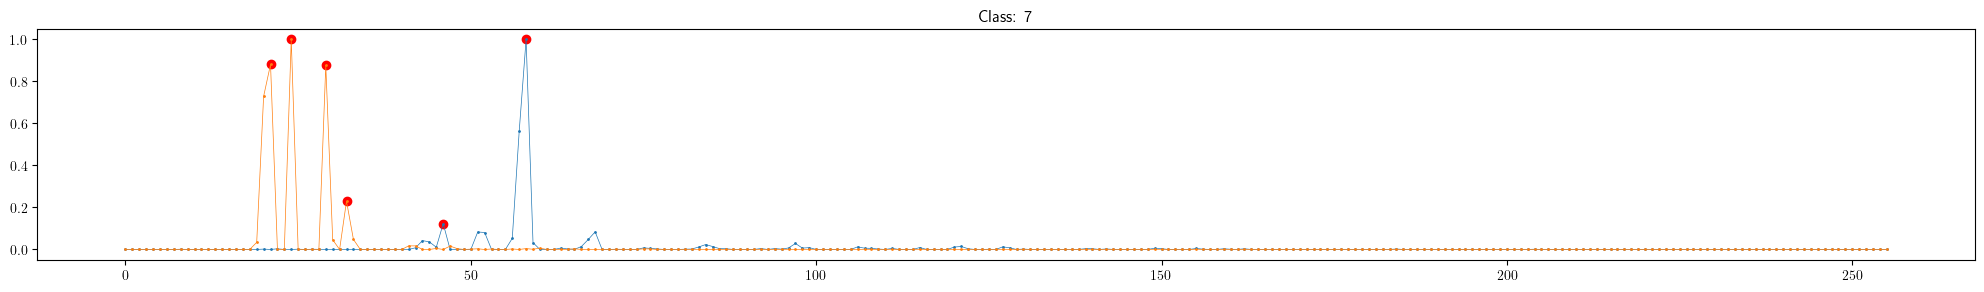

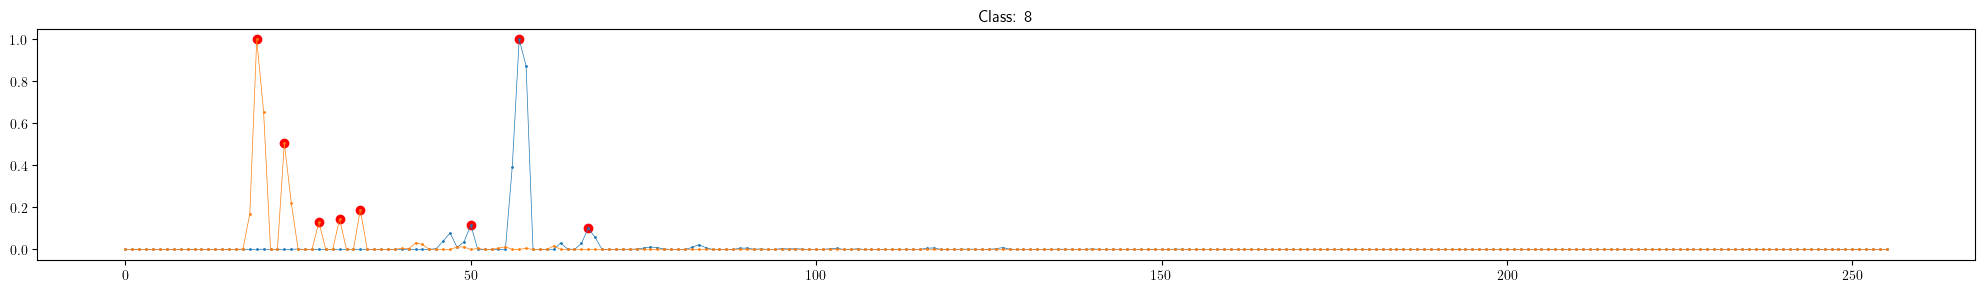

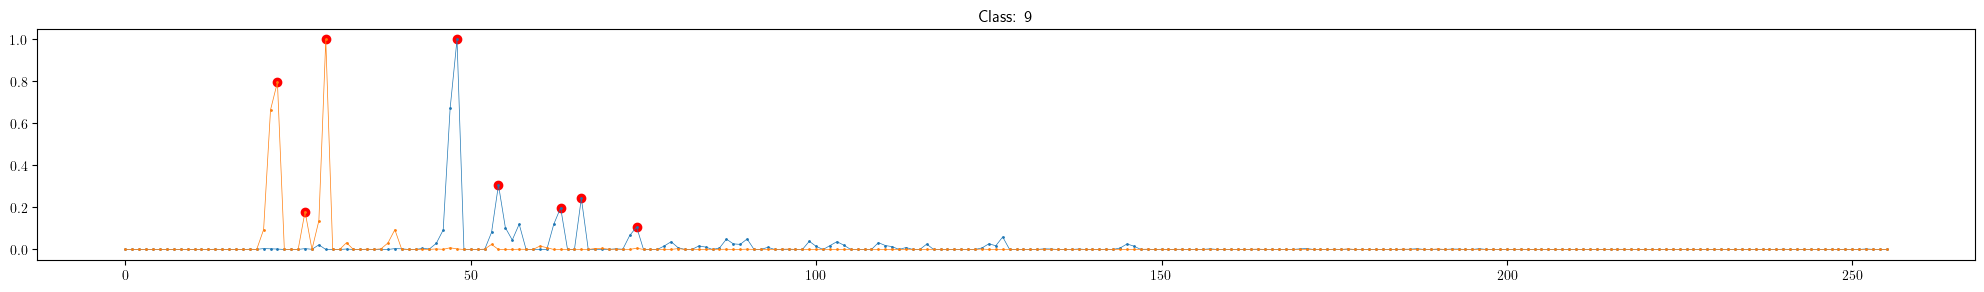

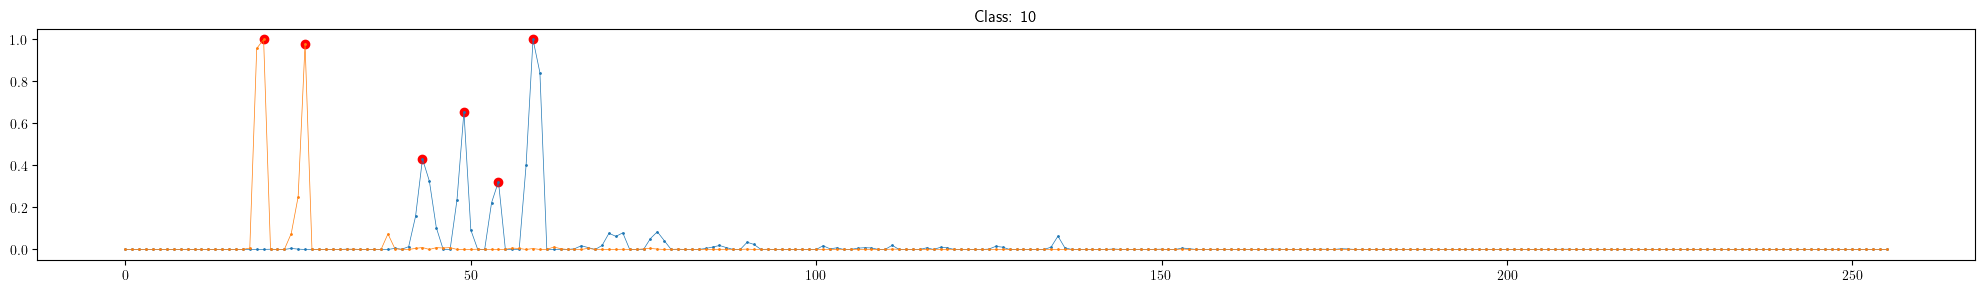

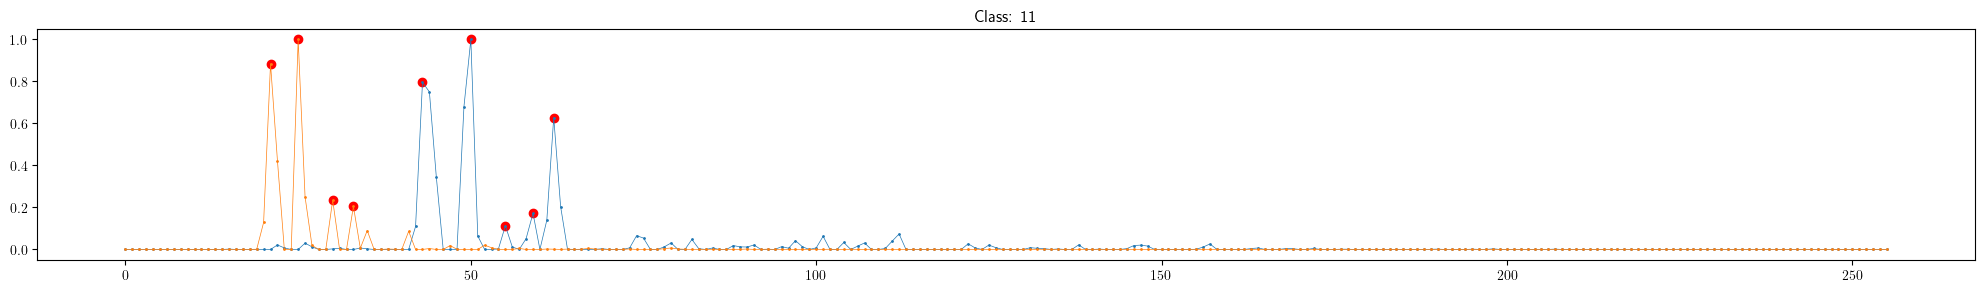

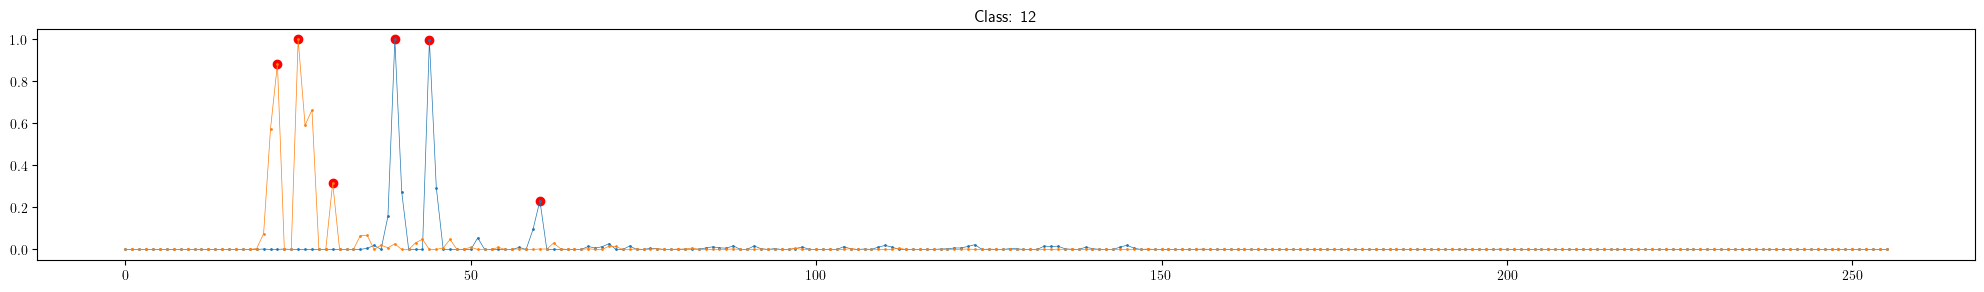

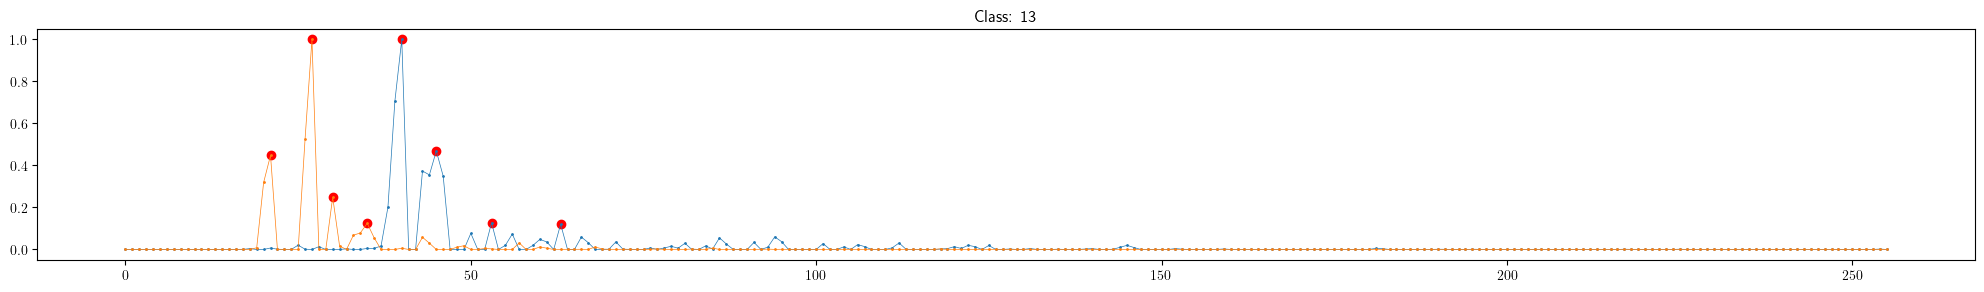

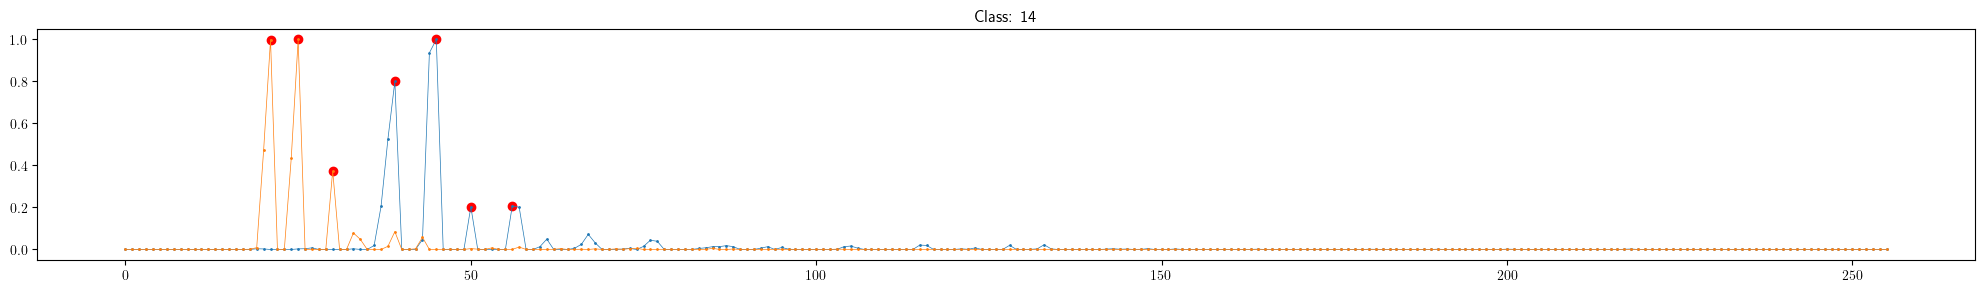

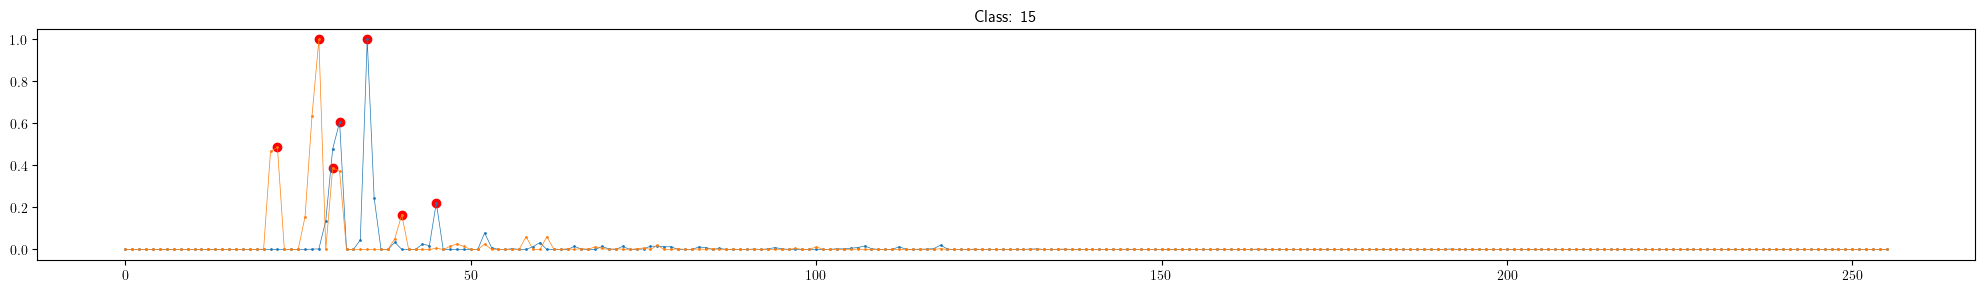

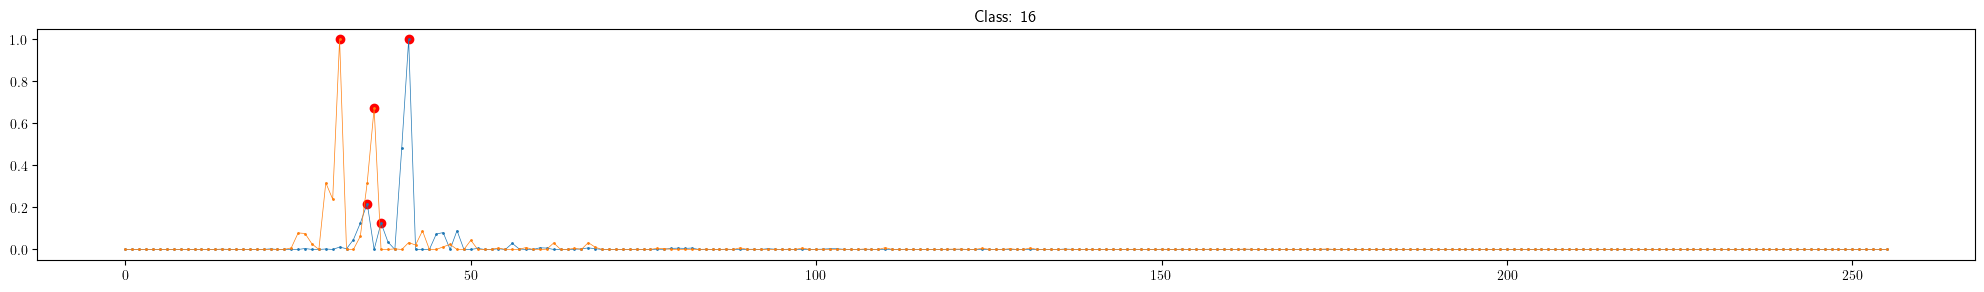

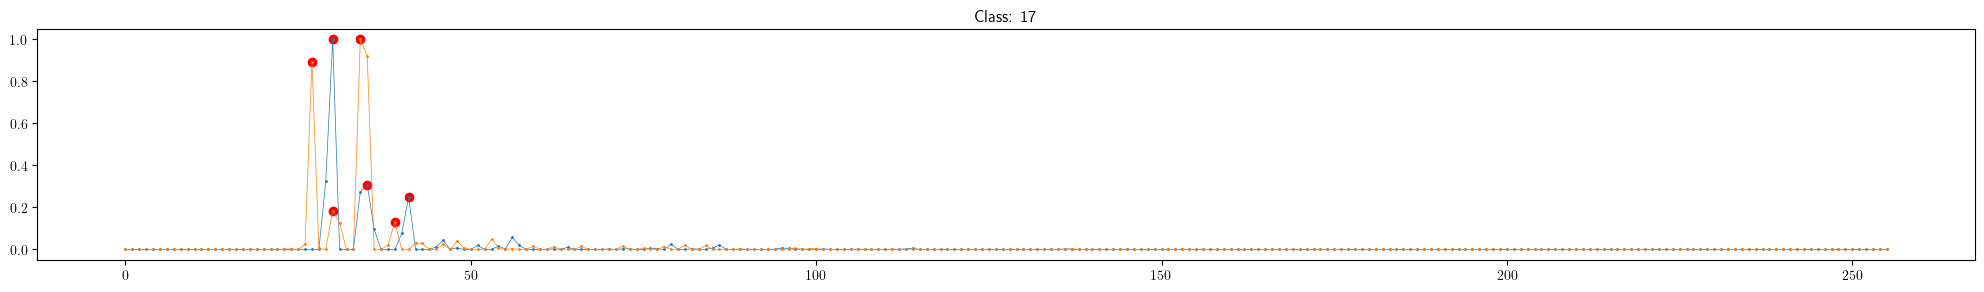

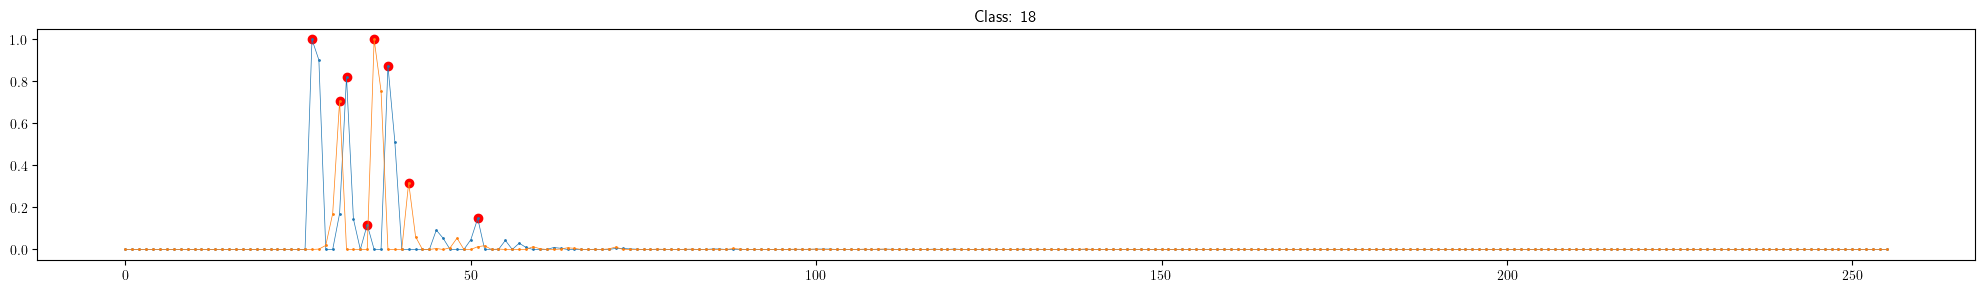

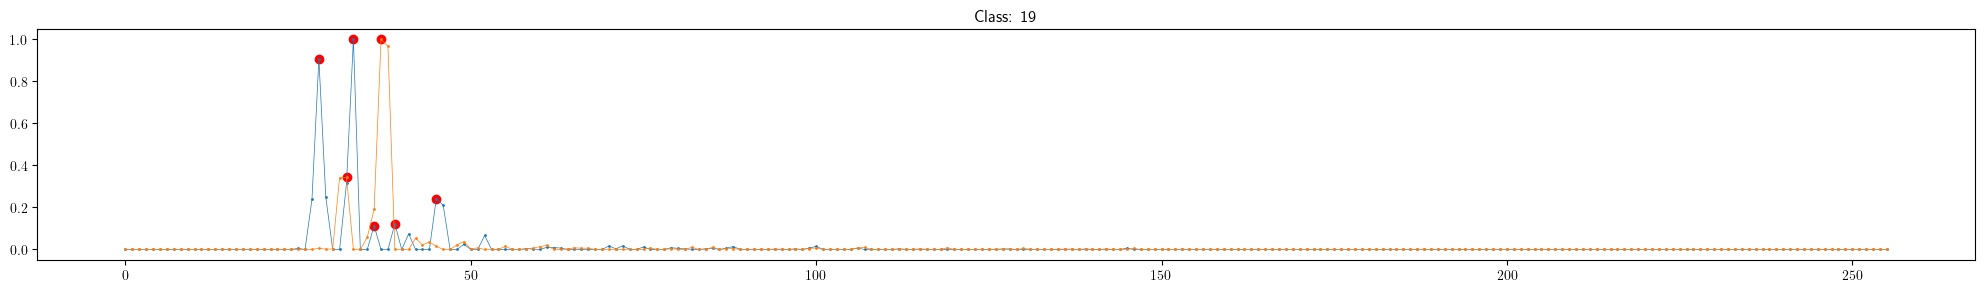

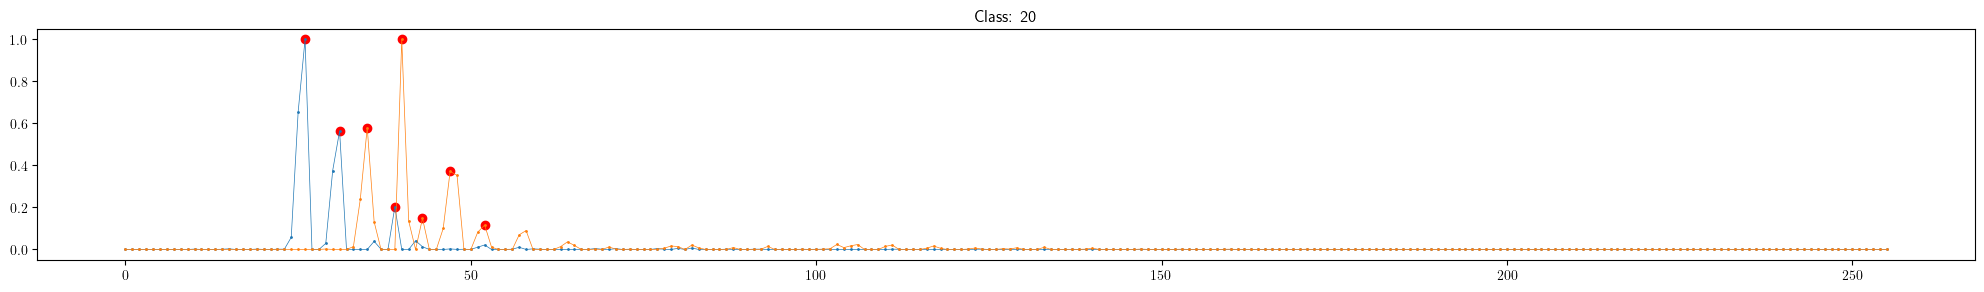

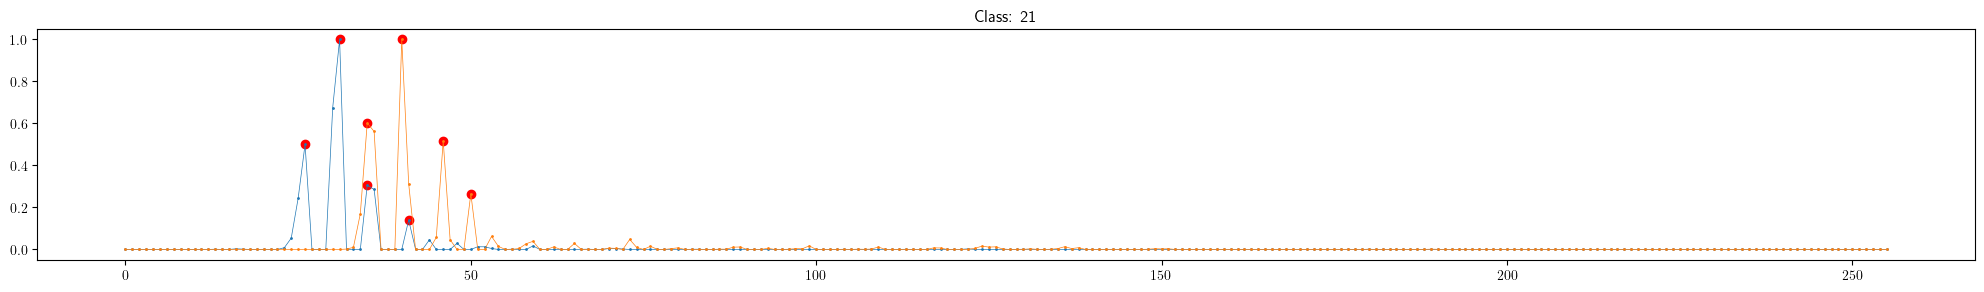

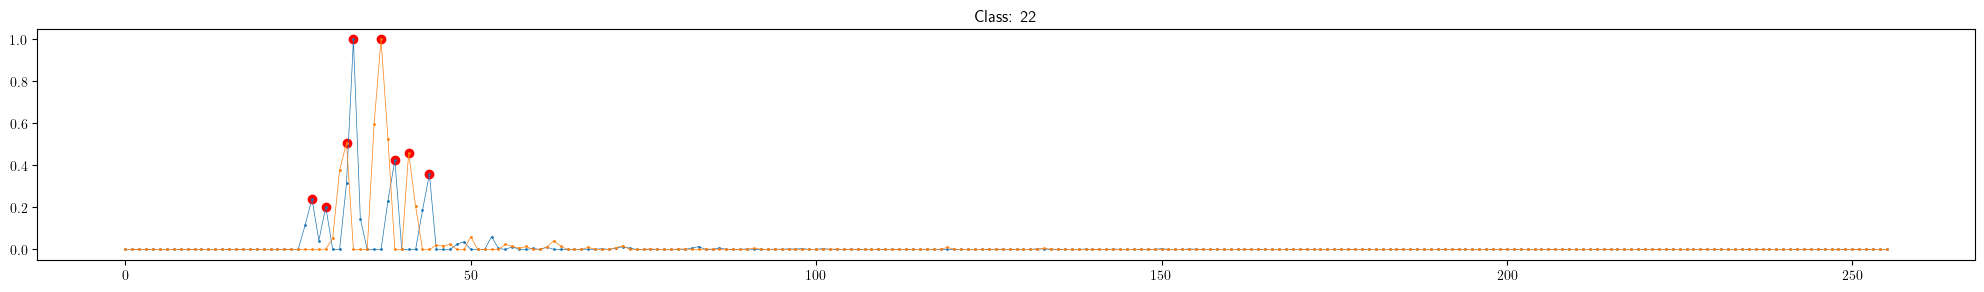

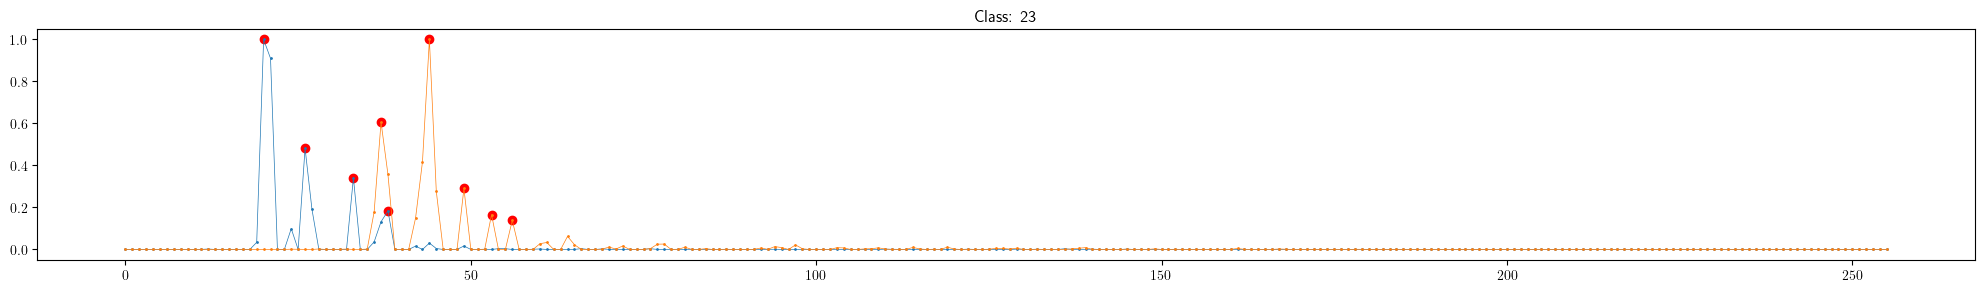

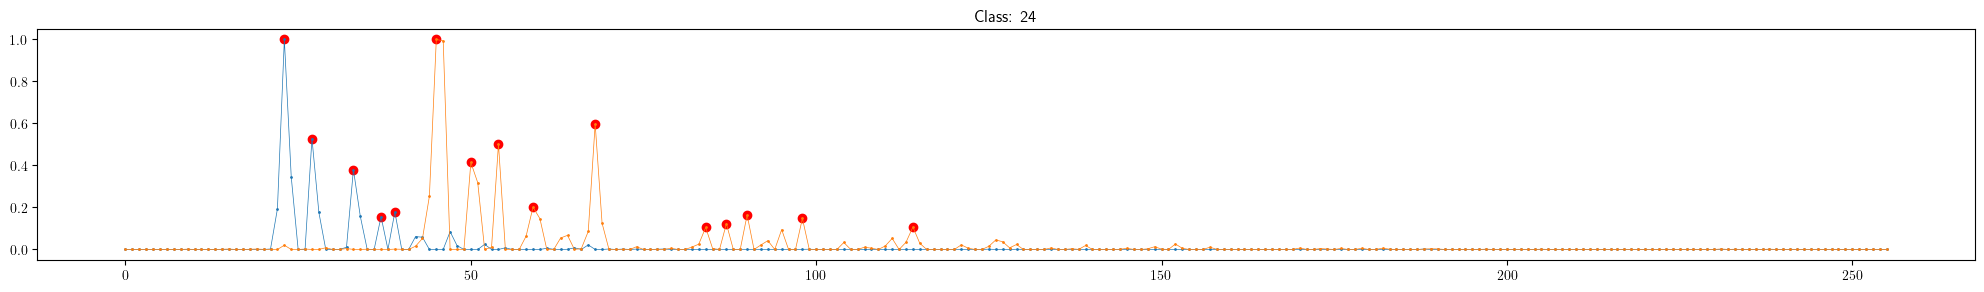

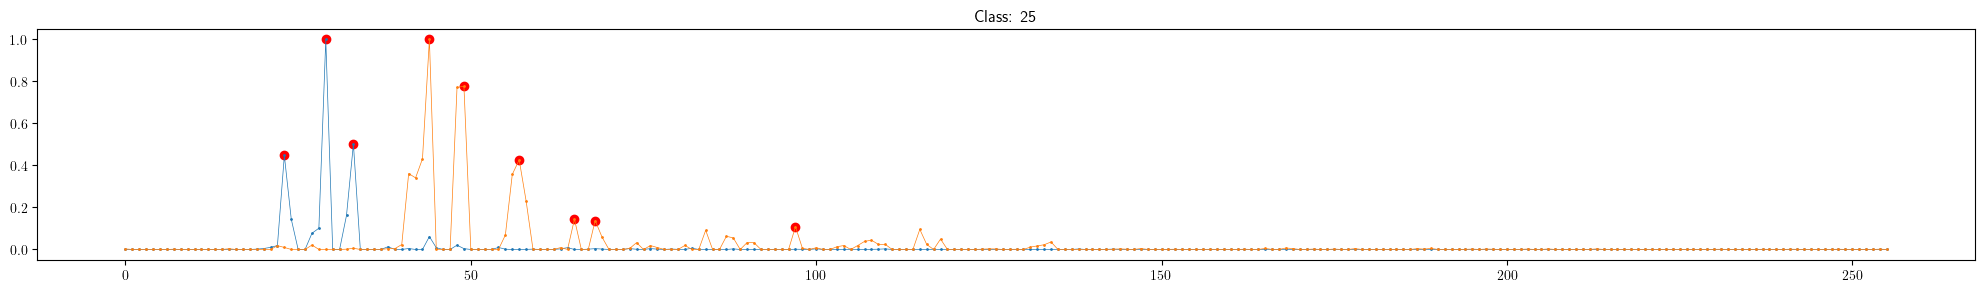

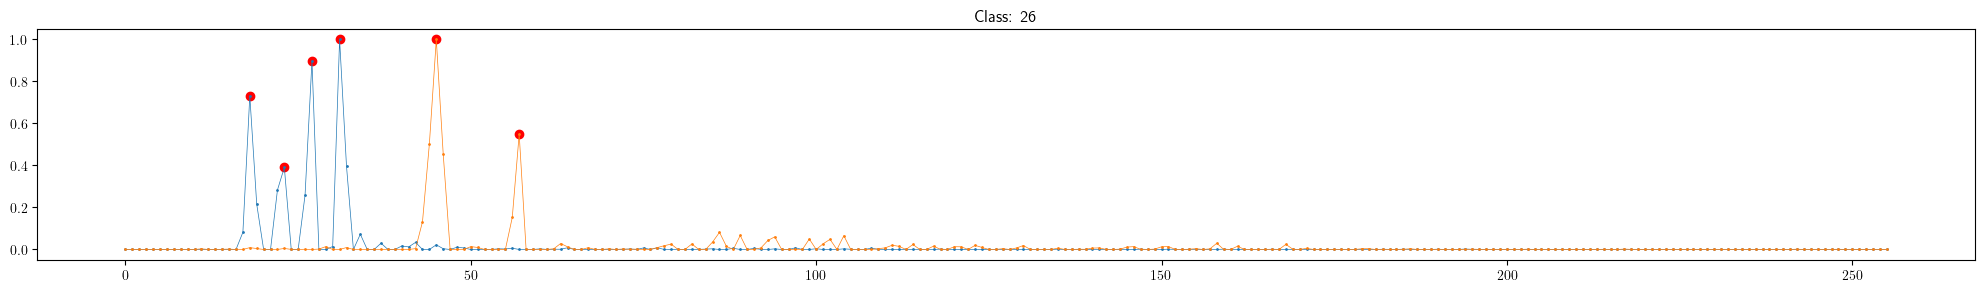

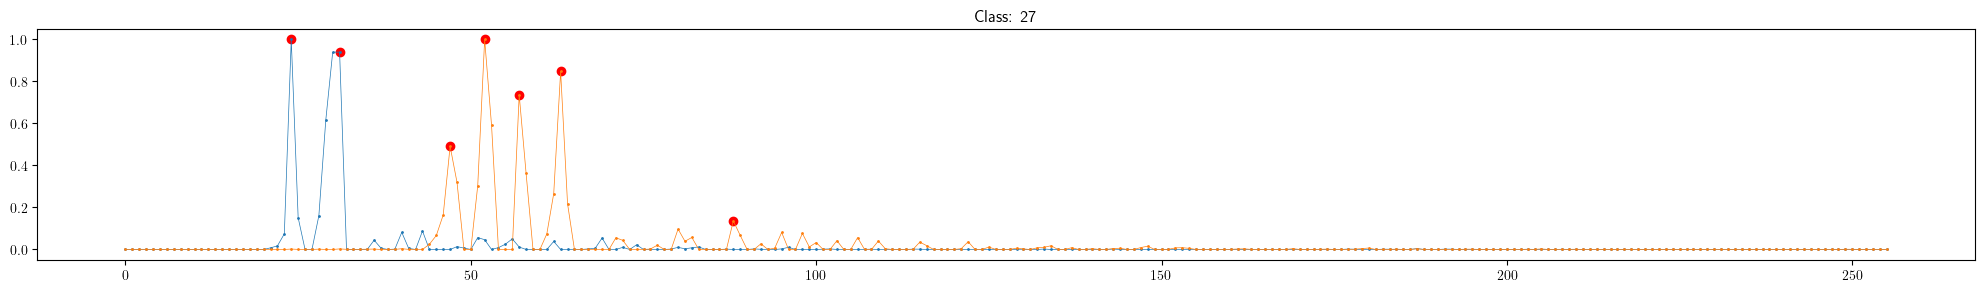

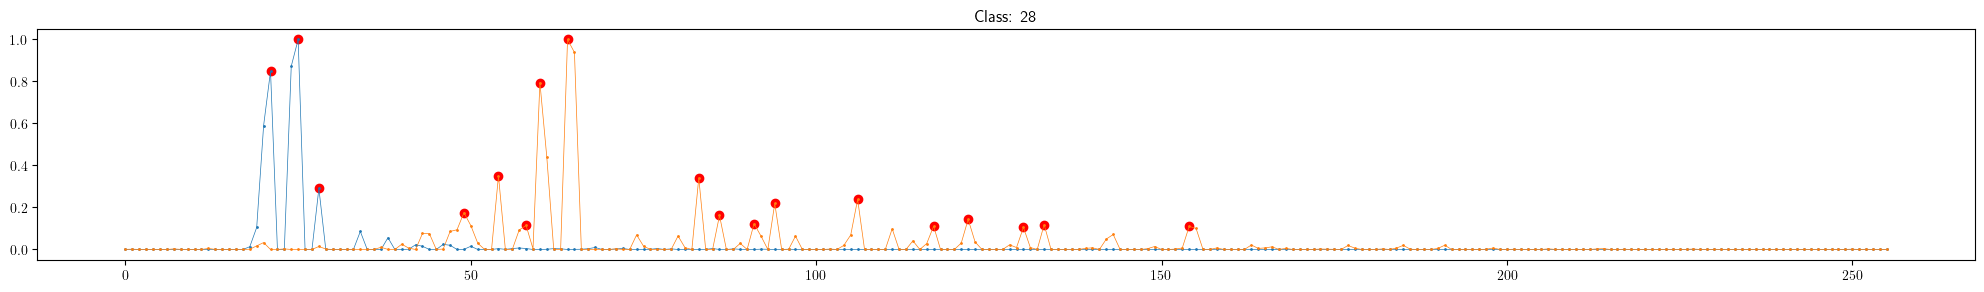

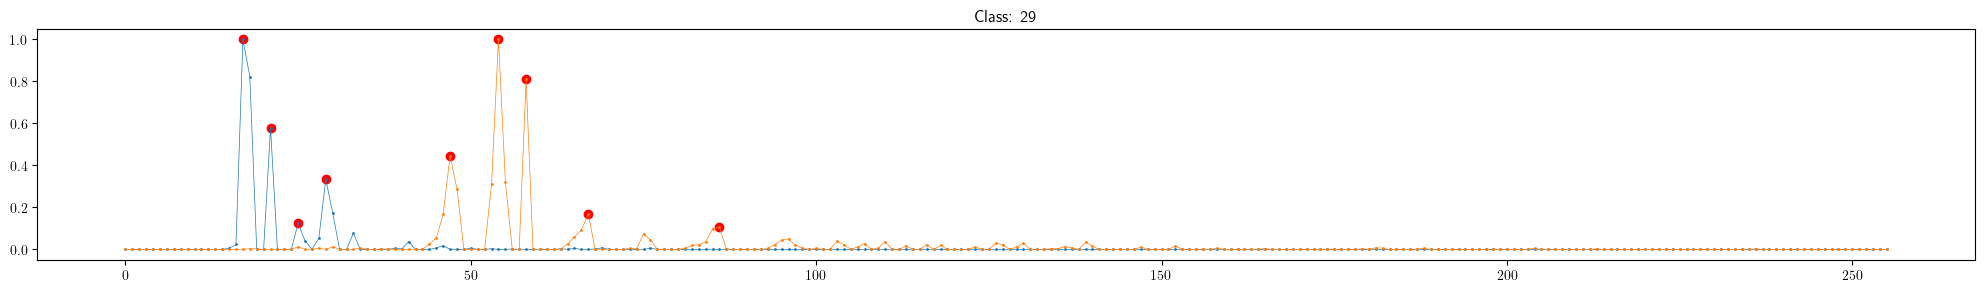

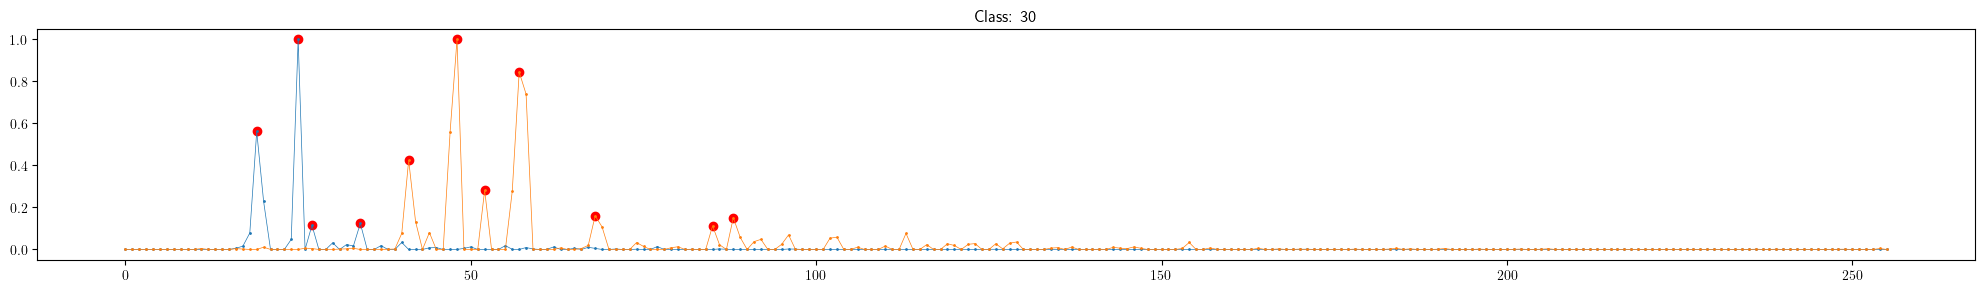

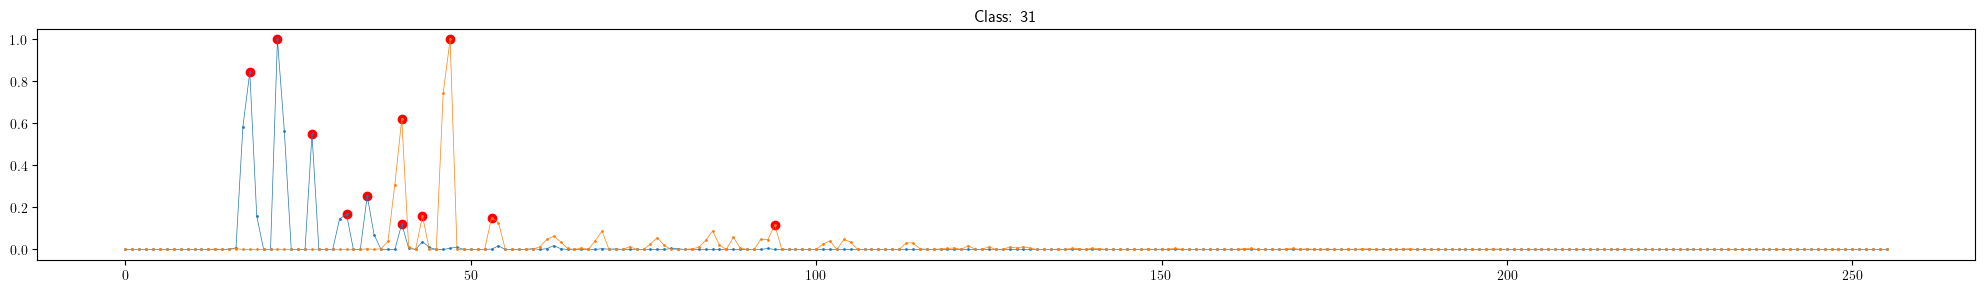

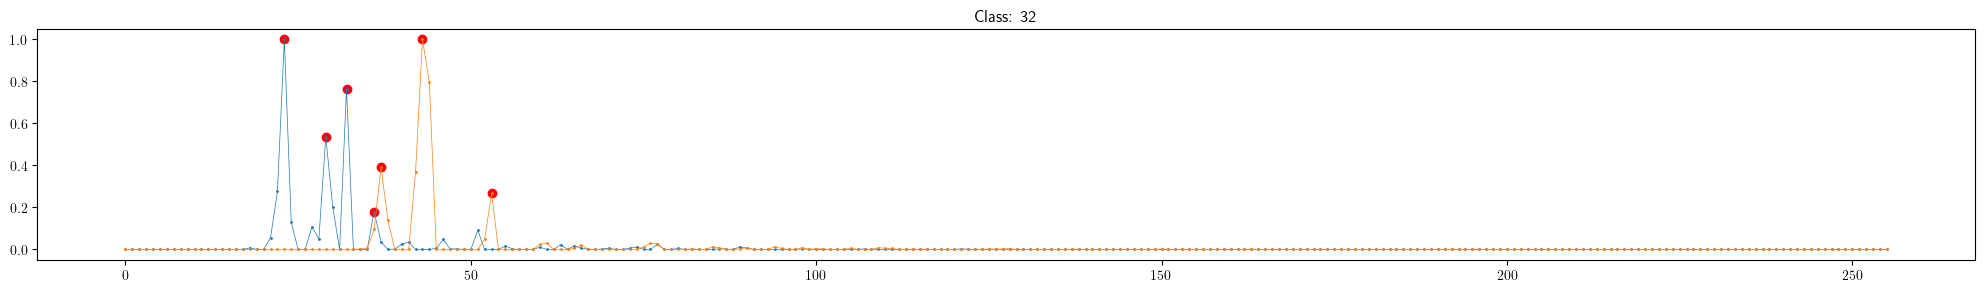

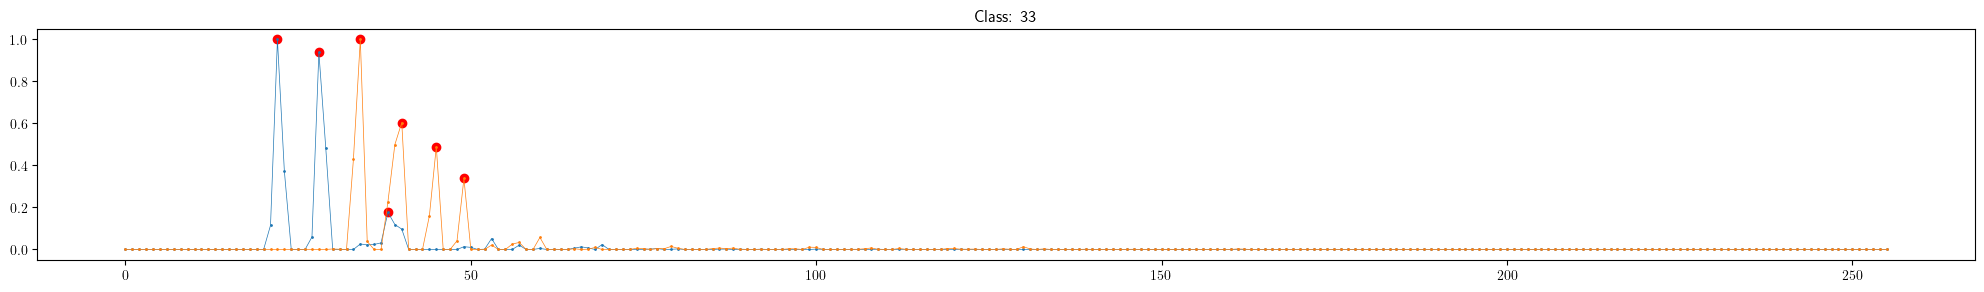

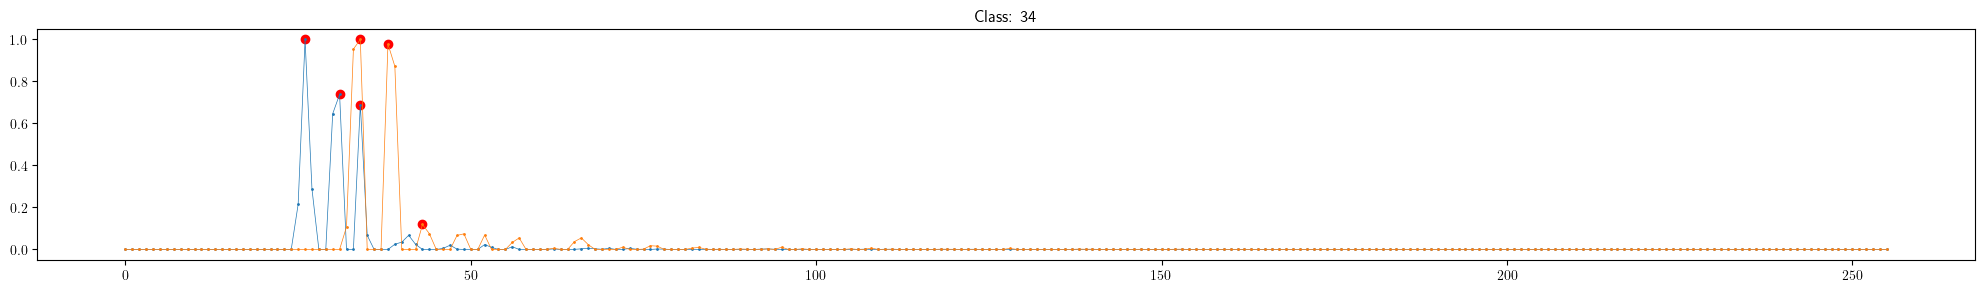

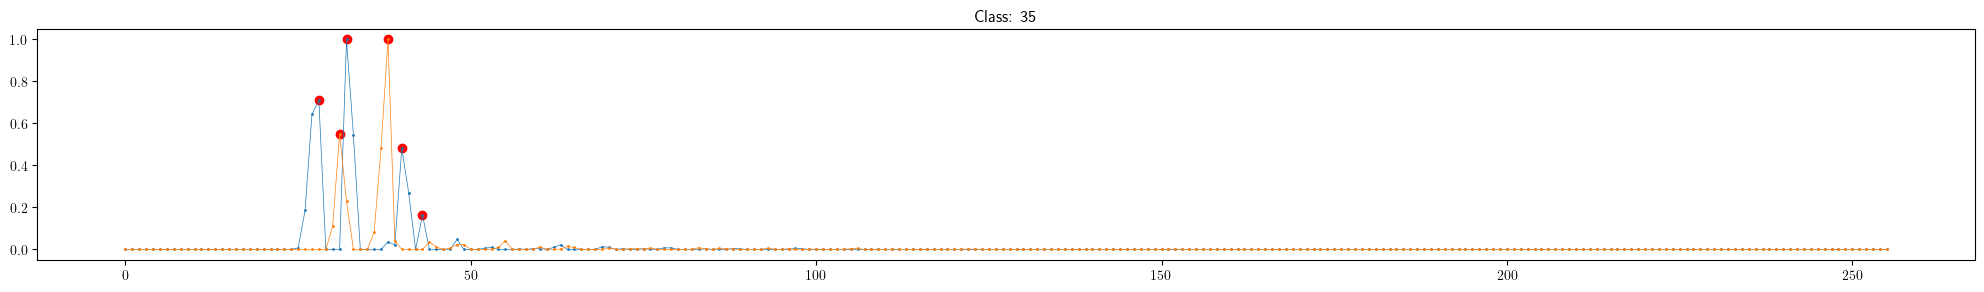

In [62]:
plt.rcParams['figure.max_open_warning'] = 50
peaks_l_4,peaks_r_4 = energy_based_novelty(samples4,denorm=True,N=4,c=NUM_CLASSES,type=1)

In [63]:
onset_l_0 = [None] * NUM_CLASSES
onset_r_0 = [None] * NUM_CLASSES

onset_l_3 = [None] * NUM_CLASSES
onset_r_3 = [None] * NUM_CLASSES

onset_l_4 = [None] * NUM_CLASSES
onset_r_4 = [None] * NUM_CLASSES

ITD_0 = [None] * NUM_CLASSES
ITD_3 = [None] * NUM_CLASSES
ITD_4 = [None] * NUM_CLASSES

for n in range(NUM_CLASSES):
    onset_l_0[n] = (peaks_l_0[n][0]/44100)*1000000
    onset_r_0[n] = (peaks_r_0[n][0]/44100)*1000000
    
    #print(f"peaks L pos {n}: ",onset_l[n])
    #print(f"peaks R pos {n}: ",onset_r[n])
    
    ITD_0[n] = onset_l_0[n]-onset_r_0[n]
    print(f"ITD Sample 0, position {n}:", ITD_0[n])
    
print('-------------------------------')

for n in range(NUM_CLASSES):
    onset_l_3[n] = (peaks_l_3[n][0]/44100)*1000000
    onset_r_3[n] = (peaks_r_3[n][0]/44100)*1000000
    
    #print(f"peaks L pos {n}: ",onset_l[n])
    #print(f"peaks R pos {n}: ",onset_r[n])
    
    ITD_3[n] = onset_l_3[n]-onset_r_3[n]
    print(f"ITD Sample 3, position {n}:", ITD_3[n])
    
print('-------------------------------')

for n in range(NUM_CLASSES):
    onset_l_4[n] = (peaks_l_4[n][0]/44100)*1000000
    onset_r_4[n] = (peaks_r_4[n][0]/44100)*1000000
    
    #print(f"peaks L pos {n}: ",onset_l[n])
    #print(f"peaks R pos {n}: ",onset_r[n])
    
    ITD_4[n] = onset_l_4[n]-onset_r_4[n]
    print(f"ITD Sample 4, position {n}:", ITD_4[n])


ITD Sample 0, position 0: 0.0
ITD Sample 0, position 1: 68.02721088435374
ITD Sample 0, position 2: 226.75736961451253
ITD Sample 0, position 3: 249.43310657596373
ITD Sample 0, position 4: 362.81179138321994
ITD Sample 0, position 5: 408.1632653061224
ITD Sample 0, position 6: 476.19047619047615
ITD Sample 0, position 7: 453.51473922902494
ITD Sample 0, position 8: 680.2721088435374
ITD Sample 0, position 9: 634.9206349206349
ITD Sample 0, position 10: 634.9206349206347
ITD Sample 0, position 11: 521.5419501133788
ITD Sample 0, position 12: 453.514739229025
ITD Sample 0, position 13: 385.4875283446712
ITD Sample 0, position 14: 272.10884353741494
ITD Sample 0, position 15: 340.1360544217687
ITD Sample 0, position 16: 136.05442176870758
ITD Sample 0, position 17: 68.02721088435374
ITD Sample 0, position 18: -90.70294784580494
ITD Sample 0, position 19: -22.675736961451207
ITD Sample 0, position 20: -181.40589569160989
ITD Sample 0, position 21: -90.70294784580506
ITD Sample 0, position

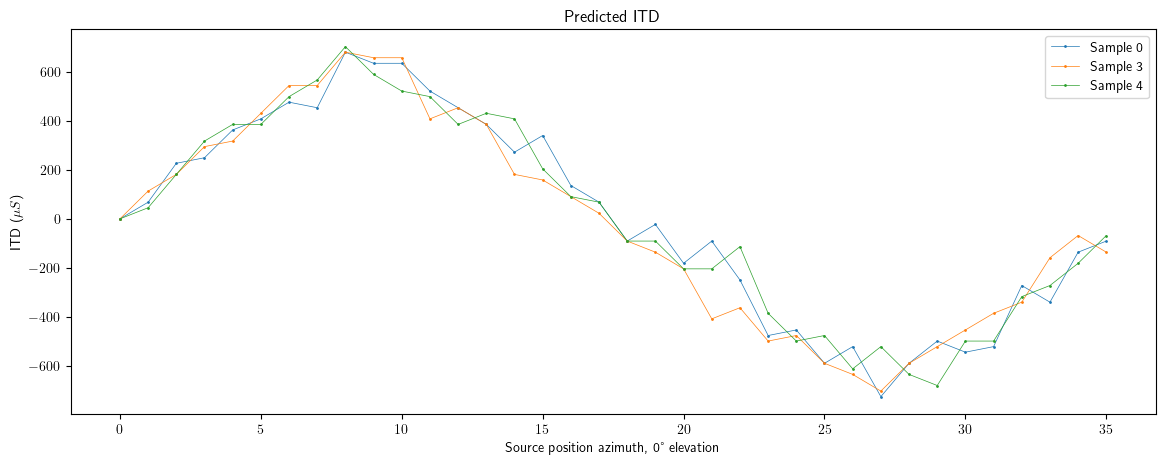

In [65]:
plt.rcParams["text.usetex"] = True
plt.figure(figsize=(14, 5))
plt.plot(ITD_0,label='Sample 0', linewidth=0.5, marker='o', markersize=1)
plt.plot(ITD_3,label='Sample 3', linewidth=0.5, marker='o', markersize=1)
plt.plot(ITD_4,label='Sample 4', linewidth=0.5, marker='o', markersize=1)
plt.legend()
plt.xlabel("Source position azimuth, 0° elevation")
plt.ylabel(r"ITD ($\mu S$)")
plt.title(r"Predicted ITD")
plt.show()

In [9]:
normalized_dataset.keys()
#for n in range(len(nonormalized_dataset)):
    

AttributeError: 'list' object has no attribute 'keys'

In [31]:
subject_id = 11
audio_samples_subject11 = []
for desired_measurement_point in range(NUM_CLASSES):
    # List to store audio samples for the current 'subject_id' and 'measurement_point'
    audio_samples_for_subject11_and_measurement_point = []

    # Iterate over samples in the non-normalized dataset
    for sample in nonormalized_dataset:
        if sample['subject_id'] == subject_id and sample['measurement_point'] == desired_measurement_point:
            audio_samples_for_subject11_and_measurement_point.append(sample['audio'])
    audio_samples_subject11.append(audio_samples_for_subject11_and_measurement_point)


subject_id = 45
audio_samples_subject45 = []
for desired_measurement_point in range(NUM_CLASSES):
    # List to store audio samples for the current 'subject_id' and 'measurement_point'
    audio_samples_for_subject45_and_measurement_point = []

    # Iterate over samples in the non-normalized dataset
    for sample in nonormalized_dataset:
        if sample['subject_id'] == subject_id and sample['measurement_point'] == desired_measurement_point:
            audio_samples_for_subject45_and_measurement_point.append(sample['audio'])
    audio_samples_subject45.append(audio_samples_for_subject45_and_measurement_point)
    
subject_id = 90
audio_samples_subject90 = []
for desired_measurement_point in range(NUM_CLASSES):
    # List to store audio samples for the current 'subject_id' and 'measurement_point'
    audio_samples_for_subject90_and_measurement_point = []

    # Iterate over samples in the non-normalized dataset
    for sample in nonormalized_dataset:
        if sample['subject_id'] == subject_id and sample['measurement_point'] == desired_measurement_point:
            audio_samples_for_subject90_and_measurement_point.append(sample['audio'])
    audio_samples_subject90.append(audio_samples_for_subject90_and_measurement_point)

#print(audio_samples_subject11[0][0][1,:])

tensor([ 0.0000e+00, -1.0000e+00,  0.0000e+00,  1.9000e+01,  3.7000e+01,
         0.0000e+00, -3.0000e+00, -4.6000e+01,  1.5000e+01, -1.1000e+02,
        -1.6300e+02,  1.8100e+02,  8.3000e+01,  1.0000e+00,  3.0000e+00,
         1.0000e+01,  1.6100e+02, -4.0000e+01,  1.1000e+02,  1.0700e+02,
         5.5000e+01,  1.3000e+02, -2.6500e+02,  3.8000e+01,  1.7100e+02,
        -7.7000e+01, -1.5400e+02, -7.5000e+01, -5.6500e+02,  5.4240e+03,
         2.2917e+04,  2.1185e+04, -1.9780e+03, -1.0099e+04, -1.4735e+04,
        -2.5641e+04, -1.4688e+04,  8.4490e+03,  3.8500e+03,  9.8500e+02,
         1.0091e+04, -7.6800e+02, -4.6400e+03, -2.3260e+03, -5.8700e+02,
        -2.9960e+03, -4.1190e+03, -5.4700e+02, -5.6840e+03,  1.5760e+03,
         4.6280e+03,  1.5440e+03, -3.3200e+02, -6.9300e+02, -2.7100e+02,
        -2.5070e+03,  7.3700e+02,  1.5500e+02,  1.8420e+03,  2.1240e+03,
         1.7960e+03,  2.1400e+02, -4.4900e+02,  2.5400e+02, -1.2590e+03,
         6.0000e+01, -3.1500e+02,  1.6850e+03,  3.3

In [ ]:
plt.rcParams['figure.max_open_warning'] = 50
peaks_l_11, peaks_r_11 = energy_based_novelty(audio_samples_subject11,denorm=False,N=4,c=NUM_CLASSES, type=0)

In [ ]:
plt.rcParams['figure.max_open_warning'] = 50
peaks_l_45, peaks_r_45 = energy_based_novelty(audio_samples_subject45,denorm=False,N=4,c=NUM_CLASSES, type=0)

In [ ]:
plt.rcParams['figure.max_open_warning'] = 50
peaks_l_90, peaks_r_90 = energy_based_novelty(audio_samples_subject90,denorm=False,N=4,c=NUM_CLASSES, type=0)

In [41]:
onset_l_11 = [None] * NUM_CLASSES
onset_r_11 = [None] * NUM_CLASSES

onset_l_45 = [None] * NUM_CLASSES
onset_r_45 = [None] * NUM_CLASSES

onset_l_90 = [None] * NUM_CLASSES
onset_r_90 = [None] * NUM_CLASSES

ITD_11 = [None] * NUM_CLASSES
ITD_45 = [None] * NUM_CLASSES
ITD_90 = [None] * NUM_CLASSES

for n in range(NUM_CLASSES):
    onset_l_11[n] = (peaks_l_11[n][0]/44100)*1000000
    onset_r_11[n] = (peaks_r_11[n][0]/44100)*1000000
    
    #print(f"peaks L pos {n}: ",onset_l[n])
    #print(f"peaks R pos {n}: ",onset_r[n])
    
    ITD_11[n] = onset_l_11[n]-onset_r_11[n]
    print(f"ITD Subject 11 , position {n}:", ITD_11[n])
    
print('-------------------------------')

for n in range(NUM_CLASSES):
    onset_l_45[n] = (peaks_l_45[n][0]/44100)*1000000
    onset_r_45[n] = (peaks_r_45[n][0]/44100)*1000000
    
    #print(f"peaks L pos {n}: ",onset_l[n])
    #print(f"peaks R pos {n}: ",onset_r[n])
    
    ITD_45[n] = onset_l_45[n]-onset_r_45[n]
    print(f"ITD Subject, position {n}:", ITD_45[n])
    
print('-------------------------------')

for n in range(NUM_CLASSES):
    onset_l_90[n] = (peaks_l_90[n][0]/44100)*1000000
    onset_r_90[n] = (peaks_r_90[n][0]/44100)*1000000
    
    #print(f"peaks L pos {n}: ",onset_l[n])
    #print(f"peaks R pos {n}: ",onset_r[n])
    
    ITD_90[n] = onset_l_90[n]-onset_r_90[n]
    print(f"ITD Subject 90, position {n}:", ITD_90[n])


ITD Subject 11 , position 0: 22.675736961451207
ITD Subject 11 , position 1: 113.37868480725626
ITD Subject 11 , position 2: 181.40589569161
ITD Subject 11 , position 3: 272.10884353741494
ITD Subject 11 , position 4: 362.8117913832199
ITD Subject 11 , position 5: 453.51473922902494
ITD Subject 11 , position 6: 521.5419501133788
ITD Subject 11 , position 7: 566.8934240362812
ITD Subject 11 , position 8: 725.6235827664399
ITD Subject 11 , position 9: 680.2721088435372
ITD Subject 11 , position 10: 634.920634920635
ITD Subject 11 , position 11: 566.8934240362812
ITD Subject 11 , position 12: 498.8662131519274
ITD Subject 11 , position 13: 408.16326530612247
ITD Subject 11 , position 14: 340.1360544217687
ITD Subject 11 , position 15: 249.43310657596368
ITD Subject 11 , position 16: 158.73015873015868
ITD Subject 11 , position 17: 68.02721088435374
ITD Subject 11 , position 18: 0.0
ITD Subject 11 , position 19: -68.02721088435374
ITD Subject 11 , position 20: -158.73015873015868
ITD Subje

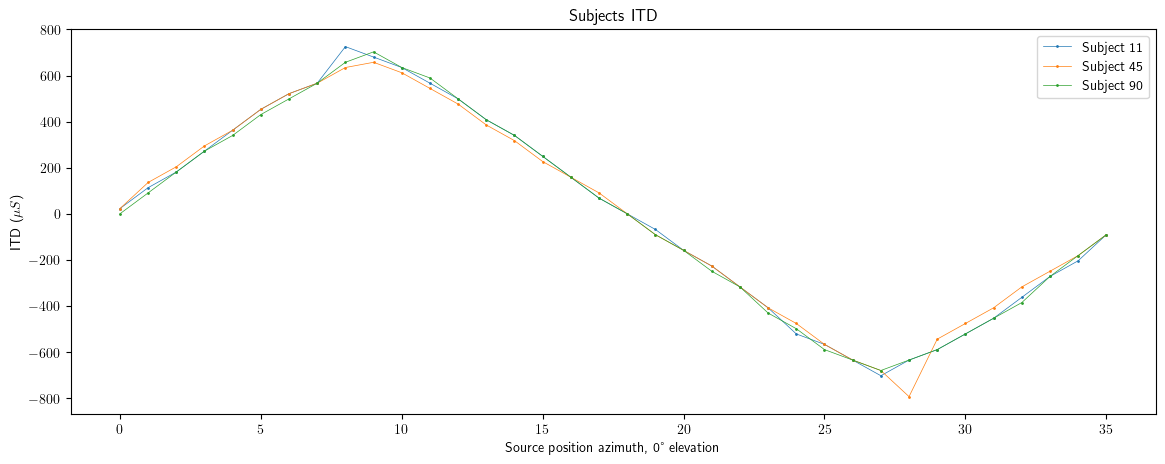

In [66]:
plt.rcParams["text.usetex"] = True
plt.figure(figsize=(14, 5))
plt.plot(ITD_11,label='Subject 11', linewidth=0.5, marker='o', markersize=1)
plt.plot(ITD_45,label='Subject 45', linewidth=0.5, marker='o', markersize=1)
plt.plot(ITD_90,label='Subject 90', linewidth=0.5, marker='o', markersize=1)
plt.legend()
plt.xlabel("Source position azimuth, 0° elevation")
plt.ylabel(r"ITD ($\mu S$)")
plt.title(r"Subjects ITD")
plt.show()

In [89]:
print(random_audio_sample.shape)

torch.Size([2, 256])


In [84]:
print(len(audio_list))

1


In [ ]:
torch.manual_seed(16)
all_hrir = []
# Iterate over classes
for c in range(NUM_CLASSES):
    # Create a single row of subplots for each class
    fig, axes = plt.subplots(1, NUM_DISPLAY_IMAGES, figsize=(25, 3))
    
    # Create subplots for each display image
    for idx in range(NUM_DISPLAY_IMAGES):
        # Generate random audio data
        audio_result = torch.randn((1,) + (2, 256)).to(device)

        # Iterate over time steps in reverse
        for i in reversed(range(diffusion_model.timesteps)):
            t = torch.full((1,), i, dtype=torch.long, device=device)
            labels = torch.tensor([c]).float().to(device).view(1, 1)
            
            # Run the diffusion model backward
            audio_result = diffusion_model.backward(x=audio_result, t=t, model=unet.eval().to(device), labels=labels)
        all_hrir.append(audio_result.clone().detach().cpu())
        
        # Plot the audio for the current class and display image
        if NUM_DISPLAY_IMAGES>1:
            axes[idx].plot(audio_result[0, 0].detach().cpu(), label='L', linewidth=0.5, marker='o', markersize=1)
            axes[idx].plot(audio_result[0, 1].detach().cpu(), label='R', linewidth=0.5, marker='o', markersize=1)
            axes[idx].legend()
            axes[idx].set_title(f"Class: {c}, Sample: {idx}")
        else:
            axes.plot(audio_result[0, 0].detach().cpu(), label='L', linewidth=0.5, marker='o', markersize=1)
            axes.plot(audio_result[0, 1].detach().cpu(), label='R', linewidth=0.5, marker='o', markersize=1)
            axes.legend()
            axes.set_title(f"Class: {c}")
    
    plt.subplots_adjust(wspace=0.1)
    plt.show()

Measurement Point: 34
Subject ID: 22
Audio Tensor shape: torch.Size([2, 256])


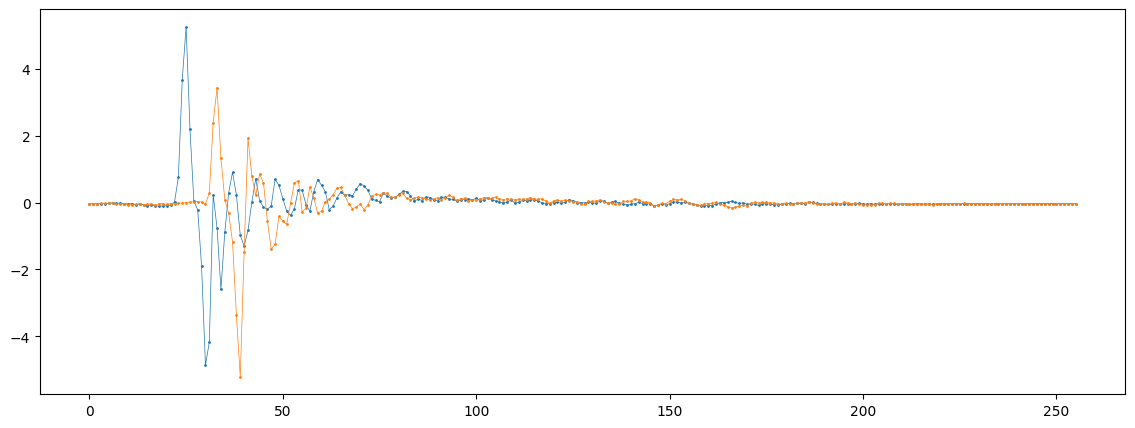

In [57]:
# Choose a specific measurement_point
desired_measurement_point = 34  # Replace with the desired measurement_point

# Filter the normalized dataset based on the chosen measurement_point
samples_from_desired_class = [sample for sample in normalized_dataset if sample['measurement_point'] == desired_measurement_point]

# Access the first sample from the filtered dataset
last_sample = samples_from_desired_class[0]['audio']

# Print information about the first sample
print(f"Measurement Point: {desired_measurement_point}")
print(f"Subject ID: {samples_from_desired_class[0]['subject_id']}")
print(f"Audio Tensor shape: {last_sample.shape}")

plt.figure(figsize=(14, 5))
plt.plot(last_sample[0],label='L', linewidth=0.5, marker='o', markersize=1)
plt.plot(last_sample[1],label='R', linewidth=0.5, marker='o', markersize=1)

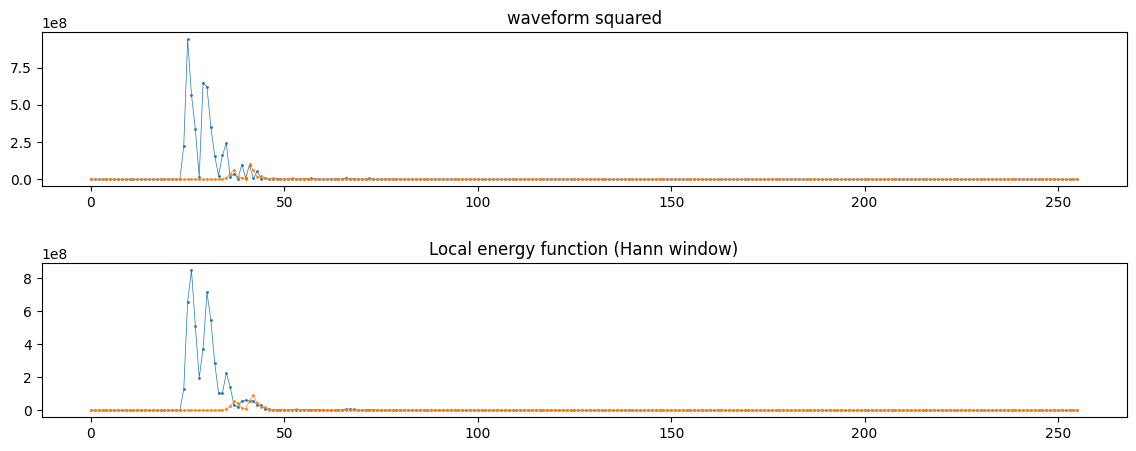

In [27]:
Fs = 44100 

x_l = x[0,0].detach().cpu()
x_r = x[0,1].detach().cpu()

x_duration = len(x_l)/Fs

N = 4
w = scipy.signal.windows.hann(N)

xl_square = x_l**2
xr_square = x_r**2
energy_l_local = np.convolve(xl_square,w**2,'same')
energy_r_local = np.convolve(xr_square,w**2,'same')

plt.figure(figsize=(14, 5))
plt.subplot(2, 1, 1)
plt.plot(xl_square,label='L', linewidth=0.5, marker='o', markersize=1)
plt.plot(xr_square,label='r', linewidth=0.5, marker='o', markersize=1)
plt.title('waveform squared')
plt.subplot(2, 1, 2)
plt.plot(energy_l_local,label='Energy', linewidth=0.5, marker='o', markersize=1)
plt.plot(energy_r_local,label='Energy', linewidth=0.5, marker='o', markersize=1)
plt.title('Local energy function (Hann window)')
plt.subplots_adjust(hspace=0.5)

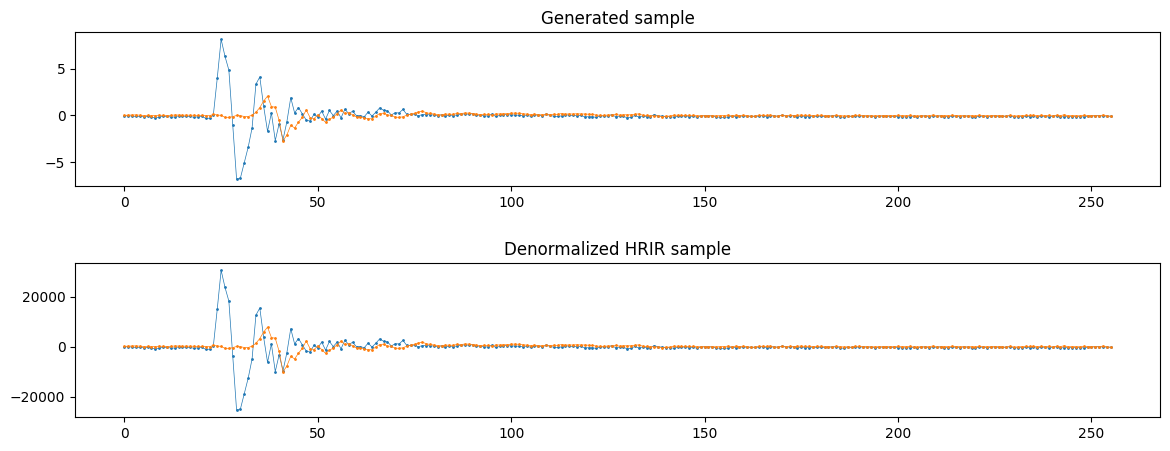

In [26]:
x = (audio_result * global_std) + global_mean

plt.figure(figsize=(14, 5))
plt.subplot(2,1,1)
plt.plot(audio_result[0,0].detach().cpu(),label='L', linewidth=0.5, marker='o', markersize=1)
plt.plot(audio_result[0,1].detach().cpu(),label='R', linewidth=0.5, marker='o', markersize=1)
plt.title('Generated sample')
plt.subplot(2,1,2)
plt.plot(x[0,0].detach().cpu(),label='L', linewidth=0.5, marker='o', markersize=1)
plt.plot(x[0,1].detach().cpu(),label='R', linewidth=0.5, marker='o', markersize=1)
plt.title('Denormalized HRIR sample')
plt.subplots_adjust(hspace=0.5)

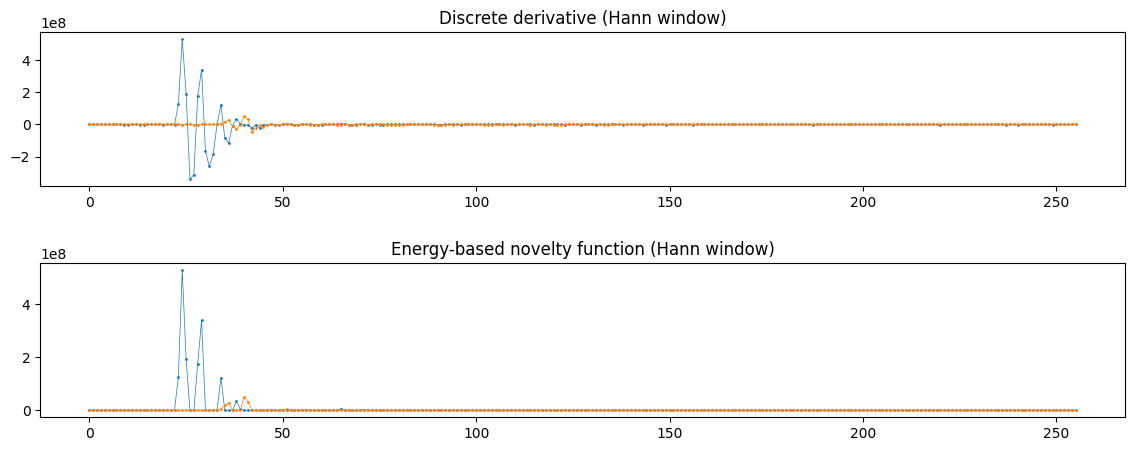

In [28]:
#Differentiation and half-wave rectification
energy_l_local_diff = np.diff(energy_l_local)
energy_l_local_diff = np.concatenate((energy_l_local_diff, np.array([0])))
novelty_l_energy = np.copy(energy_l_local_diff)
novelty_l_energy[energy_l_local_diff < 0] = 0

energy_r_local_diff = np.diff(energy_r_local)
energy_r_local_diff = np.concatenate((energy_r_local_diff, np.array([0])))
novelty_r_energy = np.copy(energy_r_local_diff)
novelty_r_energy[energy_r_local_diff < 0] = 0

plt.figure(figsize=(14, 5))
plt.subplot(2, 1, 1)
plt.plot(energy_l_local_diff, linewidth=0.5, marker='o', markersize=1)
plt.plot(energy_r_local_diff, linewidth=0.5, marker='o', markersize=1)
plt.title('Discrete derivative (Hann window)')
plt.subplot(2, 1, 2)
plt.plot(novelty_l_energy, linewidth=0.5, marker='o', markersize=1)
plt.plot(novelty_r_energy, linewidth=0.5, marker='o', markersize=1)
plt.title('Energy-based novelty function (Hann window)')
plt.subplots_adjust(hspace=0.5)

Text(0.5, 1.0, 'Peaks')

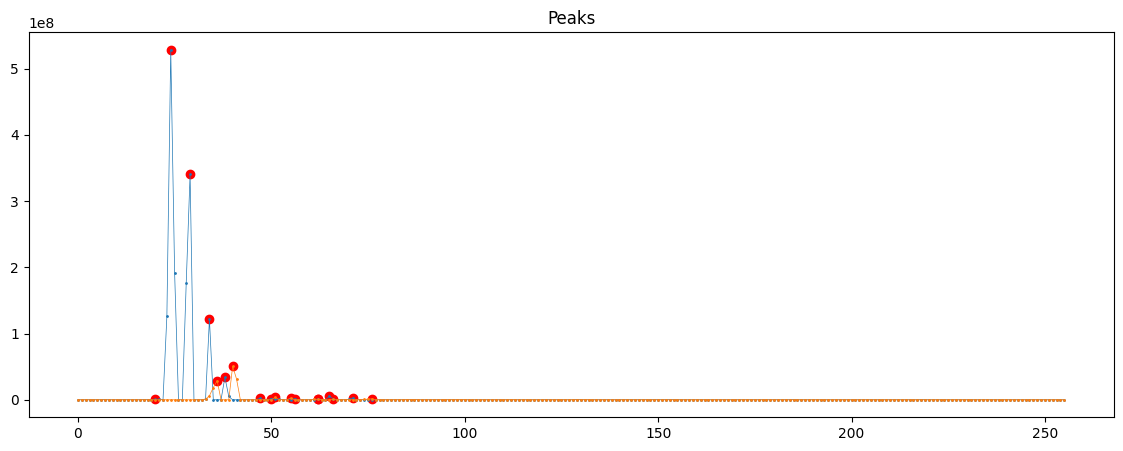

In [29]:
peaks_l, properties_l = scipy.signal.find_peaks(novelty_l_energy, prominence=0.05e7)
peaks_r, properties_r = scipy.signal.find_peaks(novelty_r_energy, prominence=0.05e7)

plt.figure(figsize=(14, 5))
plt.plot(novelty_l_energy, linewidth=0.5, marker='o', markersize=1)
plt.plot(novelty_r_energy, linewidth=0.5, marker='o', markersize=1)
plt.scatter(peaks_l,novelty_l_energy[peaks_l], marker='o', color='red' )
plt.scatter(peaks_r,novelty_r_energy[peaks_r], marker='o', color='red' )
plt.title('Peaks')

In [35]:
print("peaks left: ", peaks_l)
print("peaks right: ", peaks_r)

onset_l = (peaks_l[0]/Fs)*1000
onset_r = (peaks_r[0]/Fs)*1000

print('onset left: ', onset_l)
print('onset right: ', onset_r)
ITD = np.abs(onset_l-onset_r)
print('ITD:', ITD)

peaks left:  [28 31 35 38 41 43 64 72]
peaks right:  [25 31 34 39 61 66]
onset left:  0.5833333333333334
onset right:  0.5208333333333334
ITD: 0.0625


<Figure size 1500x1500 with 0 Axes>

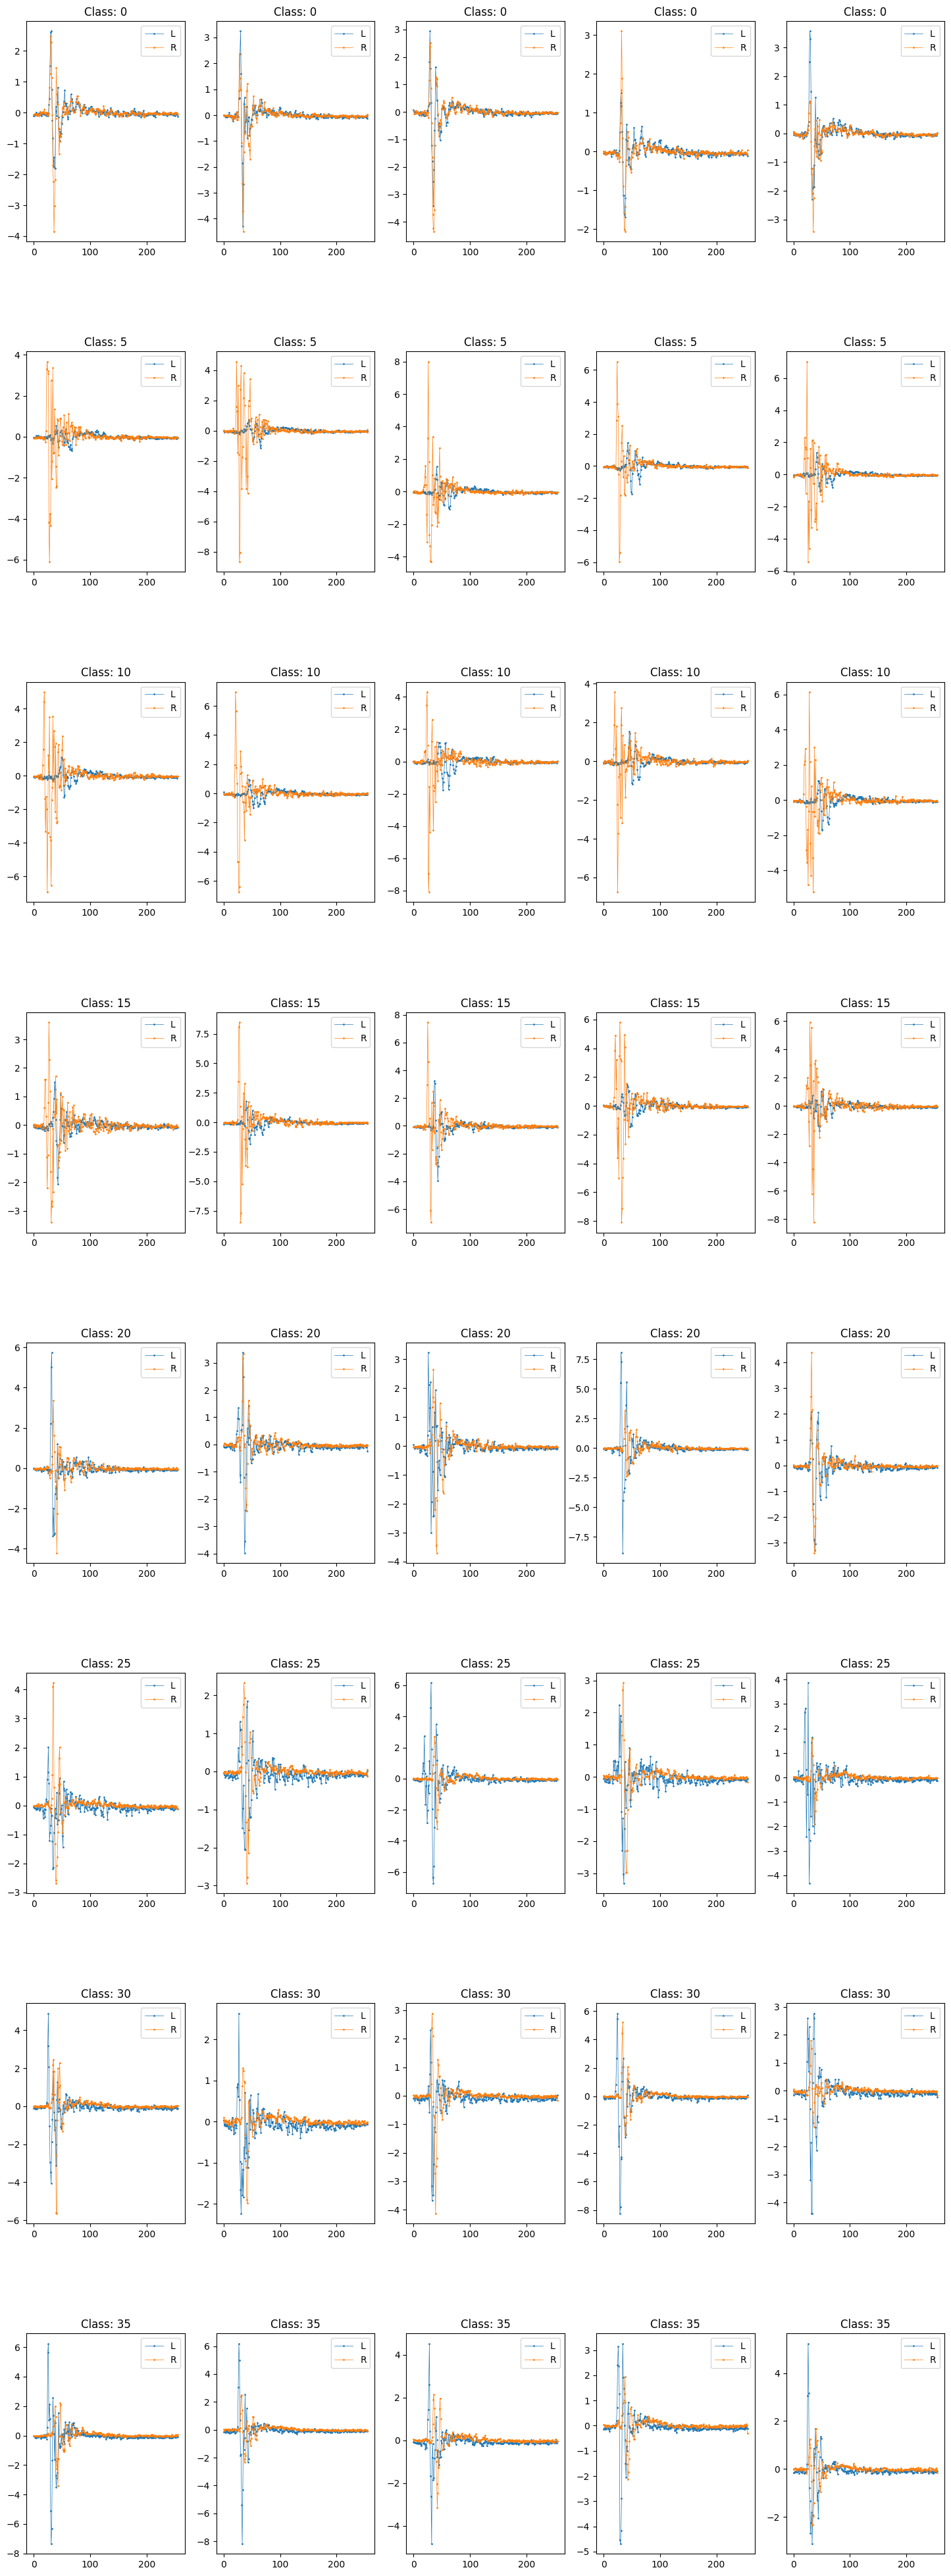

In [17]:
torch.manual_seed(16)
#AUDIO_SIZE = 256
plt.figure(figsize=(15,15))
f, ax = plt.subplots(NUM_CLASSES, NUM_DISPLAY_IMAGES, figsize = (18,50))

for c, class_label in enumerate(classes):  # Enumerate over classes and get the class label
    audio_result = torch.randn((NUM_DISPLAY_IMAGES,) + (2, 256)).to(device)
    for i in reversed(range(diffusion_model.timesteps)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        labels = torch.tensor([int(class_label)] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
        audio_result = diffusion_model.backward(x=audio_result, t=t, model=unet.eval().to(device), labels=labels)
        #audio_result = (audio_result * global_std)+global_mean
    
    for idx, audio in enumerate(audio_result):
        ax[c][idx].plot(audio_result[idx, 0].detach().cpu(), label='L', linewidth=0.5, marker='o', markersize=1)
        ax[c][idx].plot(audio_result[idx, 1].detach().cpu(), label='R', linewidth=0.5, marker='o', markersize=1)
        ax[c][idx].legend()
        ax[c][idx].set_title(f"Class: {class_label}")

plt.subplots_adjust(hspace=0.5)
plt.show()

In [25]:
print("global mean",global_mean)
print("global std",global_std)

global mean tensor(131.9117)
global std tensor(3753.0173)


<Figure size 1500x1500 with 0 Axes>

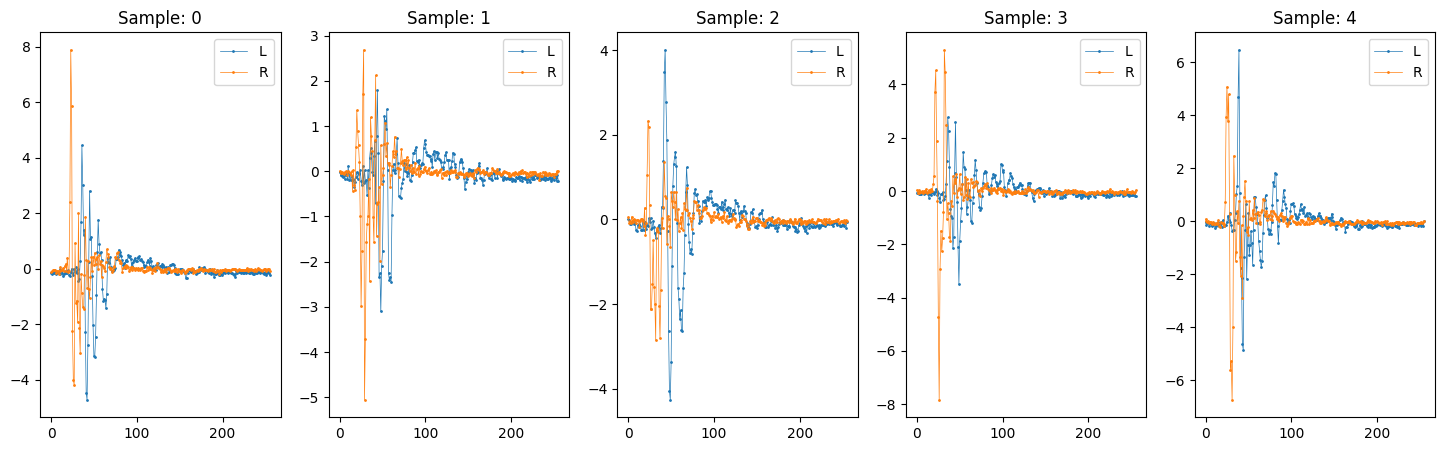

In [43]:
torch.manual_seed(16)
plt.figure(figsize=(15, 15))
f, ax = plt.subplots(1, NUM_DISPLAY_IMAGES, figsize=(18, 5))  # Adjust the number of subplots

# Choose the specific class you want to visualize
class_to_visualize = 4  # Replace with the desired class index

audio_result = torch.randn((NUM_DISPLAY_IMAGES, 2, 256)).to(device)

for i in reversed(range(diffusion_model.timesteps)):
    t = torch.full((1,), i, dtype=torch.long, device=device)
    labels = torch.tensor([class_to_visualize] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
    audio_result = diffusion_model.backward(x=audio_result, t=t, model=unet.eval().to(device), labels=labels)

for idx, audio in enumerate(audio_result):
    ax[idx].plot(audio_result[idx, 0].detach().cpu(), label='L', linewidth=0.5, marker='o', markersize=1)
    ax[idx].plot(audio_result[idx, 1].detach().cpu(), label='R', linewidth=0.5, marker='o', markersize=1)
    ax[idx].legend()
    ax[idx].set_title(f"Sample: {idx}")

plt.subplots_adjust(hspace=0.5)
plt.show()


Text(0.5, 1.0, 'Denoised')

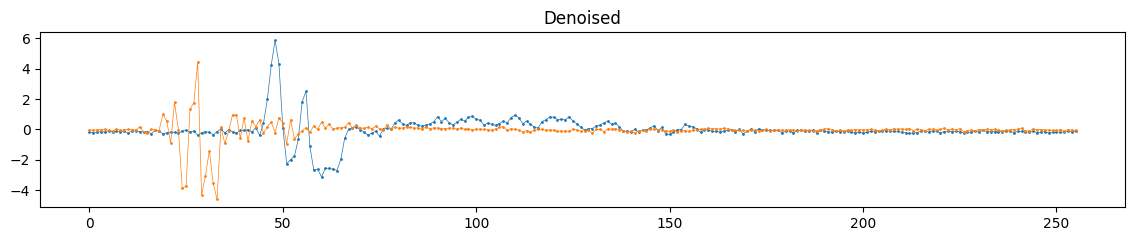

In [51]:
# Plot the first stereo audio file
plt.figure(figsize=(14, 5))
plt.subplot(2, 1, 1)
plt.plot(audio_result[4,0].detach().cpu(),label='L', linewidth=0.5, marker='o', markersize=1)
plt.plot(audio_result[4,1].detach().cpu(),label='R', linewidth=0.5, marker='o', markersize=1)
plt.title('Denoised')

<Figure size 1500x1500 with 0 Axes>

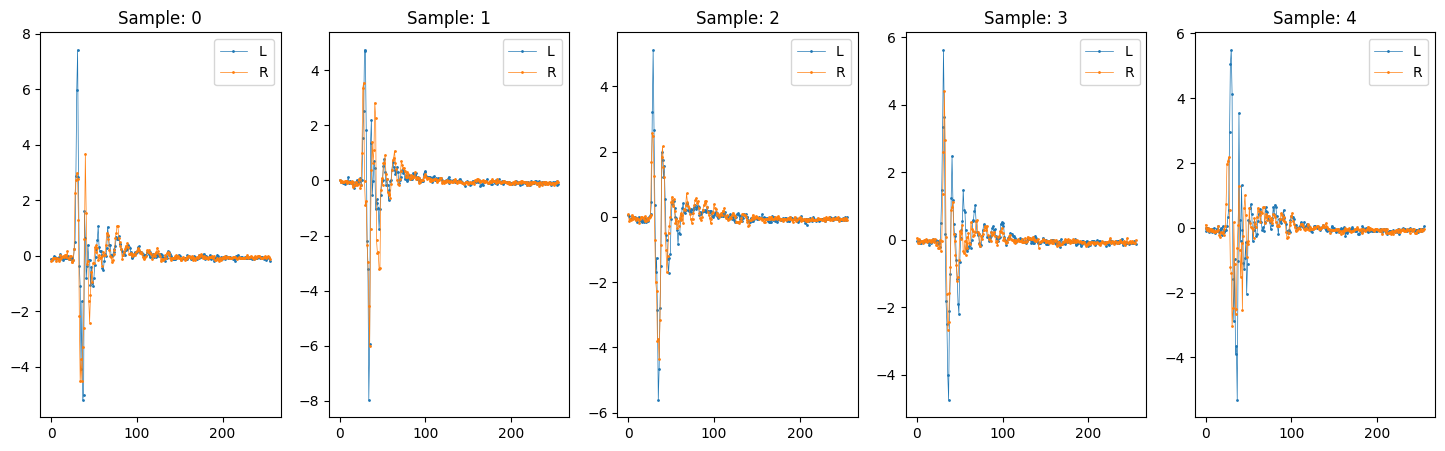

In [46]:
torch.manual_seed(16)
plt.figure(figsize=(15, 15))
f, ax = plt.subplots(1, NUM_DISPLAY_IMAGES, figsize=(18, 5))  # Adjust the number of subplots

# Choose the specific class you want to visualize
class_to_visualize = 0  # Replace with the desired class index

audio_result = torch.randn((NUM_DISPLAY_IMAGES, 2, 256)).to(device)

for i in reversed(range(diffusion_model.timesteps)):
    t = torch.full((1,), i, dtype=torch.long, device=device)
    labels = torch.tensor([class_to_visualize] * NUM_DISPLAY_IMAGES).resize(NUM_DISPLAY_IMAGES, 1).float().to(device)
    audio_result = diffusion_model.backward(x=audio_result, t=t, model=unet.eval().to(device), labels=labels)

for idx, audio in enumerate(audio_result):
    ax[idx].plot(audio_result[idx, 0].detach().cpu(), label='L', linewidth=0.5, marker='o', markersize=1)
    ax[idx].plot(audio_result[idx, 1].detach().cpu(), label='R', linewidth=0.5, marker='o', markersize=1)
    ax[idx].legend()
    ax[idx].set_title(f"Sample: {idx}")

plt.subplots_adjust(hspace=0.5)
plt.show()

In [5]:
# Define an embedding layer with a vocabulary size of 10 and embedding dimension of 3
embedding = nn.Embedding(10, 3)

# Input indices
input_indices = torch.LongTensor([1, 3, 2])

# Get the embeddings for the input indices
embeddings = embedding(input_indices)

print(embeddings.shape)

torch.Size([3, 3])
